## Import Packages

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, precision_recall_curve,
                            accuracy_score, precision_score, recall_score, f1_score,
                            silhouette_score, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [2]:
# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================
# Purpose: Load data and column names
columns_path = "/content/drive/MyDrive/Interview Assessment/census-bureau.columns"
data_path = "/content/drive/MyDrive/Interview Assessment/census-bureau.data"

with open(columns_path, "r") as f:
    colnames = [line.strip() for line in f]

df = pd.read_csv(data_path, header=None, names=colnames, sep=",", engine="python")

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")

Dataset shape: (199523, 42)

Column names:
['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's 

# Task 1: Income Classification

## Objective

As a data scientist, you are tasked by your retail business client with identifying two groups of people for marketing purposes:

- People who earn an income of **less than $50,000**

- People who earn an income of **more than $50,000**

## Dataset Description

To assist in this pursuit, the retail business client has developed a means of accessing **40 different demographic and employment related variables** for any person they are interested in marketing to.

Additionally, the client compiled a dataset that provides **gold labels** for a variety of observations of these 40 variables within the population.

## Goal

Using the dataset given, **train and validate a classifier** that predicts this outcome.


## Exploratory Data Analysis (EDA)

In [3]:
# ============================================================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*80)

# 2.1 Target variable analysis
print("\n2.1 Target Variable Distribution:")
print(df['label'].value_counts())
target_dist = df['label'].value_counts(normalize=True)
print(f"\nClass Balance:")
print(f"  Income ≤$50k: {target_dist.iloc[0]:.2%}")
print(f"  Income >$50k: {target_dist.iloc[1]:.2%}")

# 2.2 Data types identification
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n2.2 Data Types:")
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Categorical features: {len(categorical_cols)}")

# 2.3 Missing values
print(f"\n2.3 Missing Values Check:")
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
else:
    print("  ✓ No NULL values detected")

# 2.4 Key numeric features summary
print(f"\n2.4 Key Numeric Features Summary:")
key_numeric = ['age', 'capital gains', 'capital losses', 'dividends from stocks', 'weeks worked in year']
print(df[key_numeric].describe().round(2))


STEP 2: EXPLORATORY DATA ANALYSIS

2.1 Target Variable Distribution:
label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64

Class Balance:
  Income ≤$50k: 93.79%
  Income >$50k: 6.21%

2.2 Data Types:
  Numeric features: 13
  Categorical features: 29

2.3 Missing Values Check:
hispanic origin    874
dtype: int64

2.4 Key Numeric Features Summary:
             age  capital gains  capital losses  dividends from stocks  \
count  199523.00      199523.00       199523.00              199523.00   
mean       34.49         434.72           37.31                 197.53   
std        22.31        4697.53          271.90                1984.16   
min         0.00           0.00            0.00                   0.00   
25%        15.00           0.00            0.00                   0.00   
50%        33.00           0.00            0.00                   0.00   
75%        50.00           0.00            0.00                   0.00   
max        90.00       99999.00         46

In [4]:
# ============================================================================
# STEP 3: BUSINESS-DRIVEN FEATURE SELECTION
# ============================================================================

# 'weight' is the census survey sampling weight — it describes how many
# people each record represents in the population. It is NOT a demographic
# or employment attribute of a person, so it should not be a predictive feature.
# It can potentially be used as sample_weight during model training.

print("\n" + "="*80)
print("STEP 3: BUSINESS-DRIVEN FEATURE SELECTION")
print("="*80)

print("\n3.1 Feature Exclusion Strategy:")

# Identify features to exclude based on business logic
features_to_exclude = {
    'target_variable': ['label'],
    'temporal': ['year'],
    'too_granular': ['detailed industry recode', 'detailed occupation recode'],
    'survey_metadata': ['weight']
}

# Flatten exclusion list
all_excluded = []
for reason, features in features_to_exclude.items():
    if features:
        all_excluded.extend(features)
        print(f"  Excluding ({reason}): {features}")

print(f"\n  Total excluded features: {len(all_excluded)}")
print(f"  Remaining features for modeling: {len(df.columns) - len(all_excluded) - 1}")


STEP 3: BUSINESS-DRIVEN FEATURE SELECTION

3.1 Feature Exclusion Strategy:
  Excluding (target_variable): ['label']
  Excluding (temporal): ['year']
  Excluding (too_granular): ['detailed industry recode', 'detailed occupation recode']
  Excluding (survey_metadata): ['weight']

  Total excluded features: 5
  Remaining features for modeling: 36


In [5]:
# ============================================================================
# STEP 4: DATA PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("STEP 4: DATA PREPROCESSING")
print("="*80)

# 4.1 Create working copy
df_processed = df.copy()
survey_weights = df_processed['weight'].copy()

# 4.2 Create binary target variable
print("\n4.1 Creating Binary Target Variable:")
df_processed['target'] = (df_processed['label'].str.strip() == '50000+.').astype(int)
print(f"  Target encoding: 1 = Income >$50k, 0 = Income ≤$50k")
print(f"  Positive class (>$50k): {df_processed['target'].sum():,} samples")
print(f"  Negative class (≤$50k): {(df_processed['target']==0).sum():,} samples")

# 4.3 Handle missing values
print(f"\n4.2 Handling Missing Values:")
missing_indicators = ['Not in universe', '?', ' ?', 'nan', 'Unknown']

for col in categorical_cols:
    if col not in all_excluded:
        mask = df_processed[col].astype(str).str.strip().isin(missing_indicators)
        if mask.sum() > 0:
            df_processed.loc[mask, col] = 'Not_Applicable'
            if mask.sum() > 10000:  # Only print significant ones
                print(f"  {col}: {mask.sum():,} → 'Not_Applicable'")

# Handle actual NaN values
df_processed['hispanic origin'].fillna('Not Hispanic', inplace=True)


STEP 4: DATA PREPROCESSING

4.1 Creating Binary Target Variable:
  Target encoding: 1 = Income >$50k, 0 = Income ≤$50k
  Positive class (>$50k): 12,382 samples
  Negative class (≤$50k): 187,141 samples

4.2 Handling Missing Values:
  class of worker: 100,245 → 'Not_Applicable'
  enroll in edu inst last wk: 186,943 → 'Not_Applicable'
  major occupation code: 100,684 → 'Not_Applicable'
  member of a labor union: 180,459 → 'Not_Applicable'
  reason for unemployment: 193,453 → 'Not_Applicable'
  region of previous residence: 183,750 → 'Not_Applicable'
  state of previous residence: 184,458 → 'Not_Applicable'
  migration code-change in msa: 101,212 → 'Not_Applicable'
  migration code-change in reg: 101,212 → 'Not_Applicable'
  migration code-move within reg: 101,212 → 'Not_Applicable'
  migration prev res in sunbelt: 183,750 → 'Not_Applicable'
  family members under 18: 144,232 → 'Not_Applicable'
  fill inc questionnaire for veteran's admin: 197,539 → 'Not_Applicable'


In [6]:
# ============================================================================
# STEP 4.4: STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

print("="*80)
print("Objective: Identify features with statistically significant relationship to income")
print("NOTE: With 199,523 records, most features will be statistically significant (p<0.001).")
print("      Effect sizes (Cohen's d, Cramér's V) show PRACTICAL significance — whether")
print("      the difference is large enough to matter for business decisions.\n")


# 4.4.1 Numeric Features: T-Tests & Effect Size
print("4.4.1 T-Tests for Numeric Features (High-Income vs Low-Income)")
print("="*70)

numeric_features_test = [
    'age',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'weeks worked in year',
    'num persons worked for employer'
]

print(f"\n{'Feature':<30} {'Mean(≤50k)':<12} {'Mean(>50k)':<12} {'t-stat':<10} {'p-value':<13} {'Sig':<5} {'Cohen d':<10} {'Effect'}")
print(f"{'-'*120}")

significant_numeric = []

for feature in numeric_features_test:
    if feature in df_processed.columns:
        low_income = df_processed[df_processed['target']==0][feature].dropna()
        high_income = df_processed[df_processed['target']==1][feature].dropna()

        # Calculate means
        mean_low = low_income.mean()
        mean_high = high_income.mean()

        # T-test (Welch's t-test, unequal variance)
        t_stat, p_value = ttest_ind(low_income, high_income, equal_var=False)
        n_low = len(low_income)
        n_high = len(high_income)

        pooled_std = np.sqrt(
            ((n_low - 1) * low_income.std()**2 + (n_high - 1) * high_income.std()**2)
            / (n_low + n_high - 2)
        )

        cohens_d = (mean_high - mean_low) / pooled_std if pooled_std > 0 else 0

        # Classify effect size
        abs_d = abs(cohens_d)
        if abs_d >= 0.8:
            effect_label = "Large"
        elif abs_d >= 0.5:
            effect_label = "Medium"
        elif abs_d >= 0.2:
            effect_label = "Small"
        else:
            effect_label = "Negligible"

        # Significance stars
        if p_value < 0.001:
            significance = "***"
            significant_numeric.append(feature)
        elif p_value < 0.01:
            significance = "**"
            significant_numeric.append(feature)
        elif p_value < 0.05:
            significance = "*"
            significant_numeric.append(feature)
        else:
            significance = "ns"

        print(f"{feature:<30} {mean_low:<12.2f} {mean_high:<12.2f} "
              f"{t_stat:<10.2f} {p_value:<13.4e} {significance:<5} "
              f"d={cohens_d:<+8.3f} {effect_label}")

print(f"\n Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print(f" Effect Size:  |d|≥0.8 Large, ≥0.5 Medium, ≥0.2 Small, <0.2 Negligible")
print(f" {len(significant_numeric)} numeric features are statistically significant (p < 0.05)")
print(f"   → Features with Medium/Large effect sizes are the strongest predictors")

Objective: Identify features with statistically significant relationship to income
NOTE: With 199,523 records, most features will be statistically significant (p<0.001).
      Effect sizes (Cohen's d, Cramér's V) show PRACTICAL significance — whether
      the difference is large enough to matter for business decisions.

4.4.1 T-Tests for Numeric Features (High-Income vs Low-Income)

Feature                        Mean(≤50k)   Mean(>50k)   t-stat     p-value       Sig   Cohen d    Effect
------------------------------------------------------------------------------------------------------------------------
age                            33.72        46.27        -105.93    0.0000e+00    ***   d=+0.568   Medium
capital gains                  143.85       4830.93      -30.87     1.0930e-201   ***   d=+1.028   Large
capital losses                 27.00        193.14       -30.29     1.4708e-194   ***   d=+0.618   Medium
dividends from stocks          107.82       1553.45      -22.97     2

In [7]:
# ============================================================================
# 4.4.2 Categorical Features: Chi-Square Tests & Cramér's V
# ============================================================================
print("\n" + "="*70)
print("4.4.2 Chi-Square Tests for Categorical Features")
print("="*70)

categorical_features_test = [
    'sex',
    'marital stat',
    'education',
    'class of worker',
    'major occupation code',
    'member of a labor union',
    'race',
    'hispanic origin'
]

print(f"\n{'Feature':<30} {'Categories':<11} {'χ² Statistic':<14} {'p-value':<13} {'Sig':<5} {'Cramér V':<10} {'Effect'}")
print(f"{'-'*115}")

significant_categorical = []

for feature in categorical_features_test:
    if feature in df_processed.columns:
        # Clean feature
        feature_clean = df_processed[feature].astype(str).str.strip()

        # Skip if too many categories (>20)
        n_categories = feature_clean.nunique()
        if n_categories > 20:
            print(f"{feature:<30} {n_categories:<11} {'(too many categories - skipped)':<30}")
            continue

        # Create contingency table
        contingency_table = pd.crosstab(feature_clean, df_processed['target'])

        # Chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n_obs = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape[0], contingency_table.shape[1]) - 1
        cramers_v = np.sqrt(chi2 / (n_obs * min_dim)) if (n_obs * min_dim) > 0 else 0

        # Classify effect size
        if cramers_v >= 0.5:
            effect_label = "Large"
        elif cramers_v >= 0.3:
            effect_label = "Medium"
        elif cramers_v >= 0.1:
            effect_label = "Small"
        else:
            effect_label = "Negligible"

        # Significance stars
        if p_value < 0.001:
            significance = "***"
            significant_categorical.append(feature)
        elif p_value < 0.01:
            significance = "**"
            significant_categorical.append(feature)
        elif p_value < 0.05:
            significance = "*"
            significant_categorical.append(feature)
        else:
            significance = "ns"

        print(f"{feature:<30} {n_categories:<11} {chi2:<14.2f} "
              f"{p_value:<13.4e} {significance:<5} "
              f"V={cramers_v:<8.4f} {effect_label}")

print(f"\n Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print(f" Effect Size:  V≥0.5 Large, ≥0.3 Medium, ≥0.1 Small, <0.1 Negligible")
print(f" {len(significant_categorical)} categorical features are statistically significant (p < 0.05)")
print(f"   → Features with Negligible Cramér\'s V contribute little predictive power")
print(f"      even though they are statistically significant (large sample artifact)")


4.4.2 Chi-Square Tests for Categorical Features

Feature                        Categories  χ² Statistic   p-value       Sig   Cramér V   Effect
-------------------------------------------------------------------------------------------------------------------
sex                            2           4955.01        0.0000e+00    ***   V=0.1576   Small
marital stat                   7           7794.87        0.0000e+00    ***   V=0.1977   Small
education                      17          30322.05       0.0000e+00    ***   V=0.3898   Medium
class of worker                9           13542.95       0.0000e+00    ***   V=0.2605   Small
major occupation code          15          26765.88       0.0000e+00    ***   V=0.3663   Medium
member of a labor union        3           1122.30        1.9731e-244   ***   V=0.0750   Negligible
race                           5           688.36         1.1524e-147   ***   V=0.0587   Negligible
hispanic origin                10          939.18         2.2

In [8]:
# ============================================================================
# 4.4.3 Summary of Statistically Significant Features
# ============================================================================
print("\n" + "="*70)
print("4.4.3 SUMMARY: Statistically Significant Features")
print("="*70)

print(f"\n Significant Numeric Features ({len(significant_numeric)}):")
for i, feat in enumerate(significant_numeric, 1):
    print(f"  {i}. {feat}")

print(f"\n Significant Categorical Features ({len(significant_categorical)}):")
for i, feat in enumerate(significant_categorical, 1):
    print(f"  {i}. {feat}")

total_significant = len(significant_numeric) + len(significant_categorical)
print(f"\n Total: {total_significant} features show statistically significant relationship with income")

print(f"\n IMPORTANT NOTE ON STATISTICAL vs PRACTICAL SIGNIFICANCE:")
print(f"    With N=199,523 records, virtually ALL features achieve p < 0.001.")
print(f"    This does NOT mean all features are equally useful for prediction.")
print(f"    Effect sizes (Cohen\'s d for numeric, Cramér\'s V for categorical)")
print(f"    reveal which features have PRACTICALLY meaningful differences.")
print(f"    Prioritize features with Medium/Large effect sizes for modeling.")
print(f"    Features with Negligible effect sizes may add noise, not signal.")


4.4.3 SUMMARY: Statistically Significant Features

 Significant Numeric Features (6):
  1. age
  2. capital gains
  3. capital losses
  4. dividends from stocks
  5. weeks worked in year
  6. num persons worked for employer

 Significant Categorical Features (8):
  1. sex
  2. marital stat
  3. education
  4. class of worker
  5. major occupation code
  6. member of a labor union
  7. race
  8. hispanic origin

 Total: 14 features show statistically significant relationship with income

 IMPORTANT NOTE ON STATISTICAL vs PRACTICAL SIGNIFICANCE:
    With N=199,523 records, virtually ALL features achieve p < 0.001.
    This does NOT mean all features are equally useful for prediction.
    Effect sizes (Cohen's d for numeric, Cramér's V for categorical)
    reveal which features have PRACTICALLY meaningful differences.
    Prioritize features with Medium/Large effect sizes for modeling.
    Features with Negligible effect sizes may add noise, not signal.


In [9]:
# ============================================================================
# STEP 4.5: DATA-DRIVEN FEATURE GROUPING
# ============================================================================
print("\n" + "="*80)
print("STEP 4.4: DATA-DRIVEN FEATURE GROUPING")
print("="*80)

# 4.5.1 STATE - Binary indicator
print("\n4.4.1 State of Previous Residence → moved_state:")
df_processed['moved_state'] = (df_processed['state of previous residence'] != 'Not_Applicable').astype(int)
print(f"   Movers: {df_processed['moved_state'].sum():,} ({df_processed['moved_state'].mean()*100:.1f}%)")

# 4.5.2 HOUSEHOLD STATUS - Income-based grouping
print("\n4.4.2 Household Status → 7 Categories:")

def group_household_status(status):
    status = str(status).strip()
    if 'Householder' in status and 'Non' not in status:
        return 'Householder'
    elif 'Nonfamily householder' in status:
        return 'Nonfamily_Householder'
    elif 'Spouse of householder' in status:
        return 'Spouse'
    elif 'Secondary individual' in status:
        return 'Secondary_Individual'
    elif 'RP of' in status or ('Other Rel 18+' in status and 'spouse' in status):
        return 'Related_Adult'
    elif 'Child' in status or 'Grandchild' in status or '<18' in status:
        return 'Child_Dependent'
    elif 'Group' in status or 'quarters' in status:
        return 'Group_Quarters'
    else:
        return 'Other'

df_processed['household_status_grouped'] = df_processed['detailed household and family stat'].apply(group_household_status)

# 4.5.3 COUNTRY - Income-based regional grouping
print("\n4.4.3 Country of Birth → 8 Income-Based Categories:")

def group_country_by_income(country):
    country = str(country).strip()
    if country in ['United-States', 'Puerto-Rico', 'Outlying-U S (Guam USVI etc)']:
        return 'US_Born'
    elif country in ['Iran', 'India', 'Scotland', 'Holand-Netherlands']:
        return 'High_Income_Country'
    elif country in ['Taiwan', 'England', 'France', 'Japan', 'Ireland', 'Greece']:
        return 'Upper_Middle_Income_Country'
    elif country in ['Canada', 'Philippines', 'Hong Kong', 'China', 'Germany', 'Italy',
                     'Poland', 'Cuba', 'South Korea', 'Portugal', 'Hungary', 'Yugoslavia']:
        return 'Middle_Income_Country'
    elif country in ['Peru', 'Ecuador', 'Haiti', 'Columbia', 'Jamaica', 'Thailand',
                     'Vietnam', 'Cambodia']:
        return 'Lower_Middle_Income_Country'
    elif country in ['Mexico', 'Guatemala', 'El-Salvador', 'Honduras', 'Nicaragua',
                     'Dominican-Republic', 'Trinadad&Tobago', 'Laos', 'Panama']:
        return 'Low_Income_Country'
    elif country == 'Not_Applicable':
        return 'Not_Applicable'
    else:
        return 'Other_Country'

df_processed['country_birth_self_grouped'] = df_processed['country of birth self'].apply(group_country_by_income)

# Create indicators
df_processed['is_foreign_born'] = (
    (df_processed['country_birth_self_grouped'] != 'US_Born') &
    (df_processed['country_birth_self_grouped'] != 'Not_Applicable')
).astype(int)

df_processed['is_high_income_country'] = (
    df_processed['country_birth_self_grouped'] == 'High_Income_Country'
).astype(int)

print(f"    Foreign-born: {df_processed['is_foreign_born'].sum():,}")
print(f"    High-income country: {df_processed['is_high_income_country'].sum():,}")


STEP 4.4: DATA-DRIVEN FEATURE GROUPING

4.4.1 State of Previous Residence → moved_state:
   Movers: 15,065 (7.6%)

4.4.2 Household Status → 7 Categories:

4.4.3 Country of Birth → 8 Income-Based Categories:
    Foreign-born: 17,622
    High-income country: 663


In [10]:
# ============================================================================
# STEP 4.6: ENCODE CATEGORICAL VARIABLES
# ============================================================================
print("\n" + "="*80)
print("STEP 4.5: ENCODE CATEGORICAL VARIABLES")
print("="*80)

label_encoders = {}

features_to_exclude_encoding = [
    'state of previous residence',
    'detailed household and family stat',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
]

print("\n4.5.1 Encoding Original Categorical Features:")
for col in categorical_cols:
    if col not in all_excluded and col not in features_to_exclude_encoding:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str).str.strip())
        label_encoders[col] = le

print(f"  Encoded {len([c for c in categorical_cols if c not in all_excluded and c not in features_to_exclude_encoding])} features")

# Encode grouped features
print("\n4.5.2 Encoding Grouped Features:")
for col in ['household_status_grouped', 'country_birth_self_grouped']:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"  ✓ {col}: {len(le.classes_)} categories")


STEP 4.5: ENCODE CATEGORICAL VARIABLES

4.5.1 Encoding Original Categorical Features:
  Encoded 23 features

4.5.2 Encoding Grouped Features:
  ✓ household_status_grouped: 8 categories
  ✓ country_birth_self_grouped: 7 categories


## Feature Engineering

In [11]:
# ============================================================================
# STEP 5: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("STEP 5: FEATURE ENGINEERING")
print("="*80)

print("\n5.1 Creating Derived Features:")

# 5.1 Age groups
df_processed['age_group'] = pd.cut(
    df_processed['age'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=[0, 1, 2, 3, 4, 5],
    include_lowest=True
)
if df_processed['age_group'].isnull().any():
    df_processed['age_group'] = df_processed['age_group'].cat.add_categories([6])
    df_processed['age_group'].fillna(6, inplace=True)
df_processed['age_group'] = df_processed['age_group'].astype(int)

# 5.2 Capital features
df_processed['has_capital_gains'] = (df_processed['capital gains'] > 0).astype(int)
df_processed['has_capital_losses'] = (df_processed['capital losses'] > 0).astype(int)
df_processed['has_dividends'] = (df_processed['dividends from stocks'] > 0).astype(int)
df_processed['net_capital'] = df_processed['capital gains'] - df_processed['capital losses']
df_processed['total_investment_income'] = (
    df_processed['capital gains'] +
    df_processed['dividends from stocks'] -
    df_processed['capital losses']
)

# 5.3 Work features
df_processed['is_full_year_worker'] = (df_processed['weeks worked in year'] >= 50).astype(int)
df_processed['work_intensity_ratio'] = df_processed['weeks worked in year'] / 52.0
print(f"  ✓ 2 work intensity features")

# 5.4 Education level (ordinal)
education_order = {
    'Children': 0, 'Less than 1st grade': 1, '1st 2nd 3rd or 4th grade': 2,
    '5th or 6th grade': 3, '7th and 8th grade': 4, '9th grade': 5,
    '10th grade': 6, '11th grade': 7, '12th grade no diploma': 8,
    'High school graduate': 9, 'Some college but no degree': 10,
    'Associates degree-occup /vocational': 11, 'Associates degree-academic program': 12,
    'Bachelors degree(BA AB BS)': 13, 'Masters degree(MA MS MEng MEd MSW MBA)': 14,
    'Prof school degree (MD DDS DVM LLB JD)': 15, 'Doctorate degree(PhD EdD)': 16
}
df_processed['education_level'] = df_processed['education'].map(education_order).fillna(0).astype(int)

# 5.5 Family structure
df_processed['has_children'] = df_processed['family members under 18'].apply(
    lambda x: 0 if 'Not' in str(x) else 1
).astype(int)


STEP 5: FEATURE ENGINEERING

5.1 Creating Derived Features:
  ✓ 2 work intensity features


In [12]:
# ============================================================================
# STEP 6: FEATURE VALIDATION
# ============================================================================
print("\n" + "="*80)
print("STEP 6: FEATURE VALIDATION & QUALITY CHECKS")
print("="*80)

print("\n6.1 Checking for Data Quality Issues:")

# Check 1: No missing values in engineered features
engineered_features = [
    'age_group', 'has_capital_gains', 'has_capital_losses', 'has_dividends',
    'net_capital', 'total_investment_income', 'is_full_year_worker',
    'work_intensity_ratio', 'education_level', 'has_children',
    'moved_state', 'is_foreign_born', 'is_high_income_country'
]

missing_check = df_processed[engineered_features].isnull().sum()
if missing_check.sum() == 0:
    print(f"  No missing values in engineered features")
else:
    print(f" Missing values detected:")
    print(missing_check[missing_check > 0])

# Check 2: Value ranges are valid
print(f"\n6.2 Validating Feature Ranges:")

validation_checks = {
    'age_group': (0, 6),
    'has_capital_gains': (0, 1),
    'work_intensity_ratio': (0, 1),
    'education_level': (0, 16),
    'is_foreign_born': (0, 1),
}

all_valid = True
for feature, (min_val, max_val) in validation_checks.items():
    actual_min = df_processed[feature].min()
    actual_max = df_processed[feature].max()
    if actual_min >= min_val and actual_max <= max_val:
        print(f"  ✓ {feature}: [{actual_min}, {actual_max}] within expected [{min_val}, {max_val}]")
    else:
        print(f"  {feature}: [{actual_min}, {actual_max}] OUTSIDE expected [{min_val}, {max_val}]")
        all_valid = False

if all_valid:
    print(f"\n  All features passed validation!")

# Check 3: Distribution checks
print(f"\n6.3 Feature Distribution Checks:")

# Age groups should be reasonably distributed
age_dist = df_processed['age_group'].value_counts(normalize=True).sort_index()
print(f"  Age group distribution:")
for group, pct in age_dist.items():
    print(f"    Group {group}: {pct*100:.1f}%")

# Investment features should be minority
print(f"\n  Investment feature prevalence:")
print(f"    Has capital gains: {df_processed['has_capital_gains'].mean()*100:.1f}%")
print(f"    Has dividends: {df_processed['has_dividends'].mean()*100:.1f}%")
print(f"    Foreign-born: {df_processed['is_foreign_born'].mean()*100:.1f}%")

# Check 4: Correlation with target
print(f"\n6.4 Correlation with Target Variable:")
correlations = {}
for feature in engineered_features:
    corr = df_processed[feature].corr(df_processed['target'])
    correlations[feature] = corr

# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(f"\n  Top 5 Most Correlated Features:")
for feat, corr in sorted_corr[:5]:
    print(f"    {feat}: {corr:.4f}")

if abs(sorted_corr[0][1]) > 0.1:
    print(f"  Strong predictive features identified")
else:
    print(f"  Warning: Weak correlations - may need more feature engineering")


STEP 6: FEATURE VALIDATION & QUALITY CHECKS

6.1 Checking for Data Quality Issues:
  No missing values in engineered features

6.2 Validating Feature Ranges:
  ✓ age_group: [0, 5] within expected [0, 6]
  ✓ has_capital_gains: [0, 1] within expected [0, 1]
  ✓ work_intensity_ratio: [0.0, 1.0] within expected [0, 1]
  ✓ education_level: [0, 16] within expected [0, 16]
  ✓ is_foreign_born: [0, 1] within expected [0, 1]

  All features passed validation!

6.3 Feature Distribution Checks:
  Age group distribution:
    Group 0: 38.4%
    Group 1: 15.8%
    Group 2: 15.4%
    Group 3: 11.1%
    Group 4: 7.9%
    Group 5: 11.4%

  Investment feature prevalence:
    Has capital gains: 3.7%
    Has dividends: 10.6%
    Foreign-born: 8.8%

6.4 Correlation with Target Variable:

  Top 5 Most Correlated Features:
    education_level: 0.2770
    has_dividends: 0.2699
    total_investment_income: 0.2696
    is_full_year_worker: 0.2665
    work_intensity_ratio: 0.2623
  Strong predictive features ide

In [13]:
# ============================================================================
# STEP 6.5: ADDRESSING MULTICOLLINEARITY
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6.5: ADDRESSING MULTICOLLINEARITY")
print("=" * 80)


print("\n6.5.1 Identifying Highly Correlated Features:")


# Check correlations (threshold 0.80)
correlation_matrix = df_processed[engineered_features].corr()
high_corr_pairs = []


for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.80:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))


if high_corr_pairs:
    print(f"  Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.80):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"    {feat1} ↔ {feat2}: {corr_val:.4f}")
else:
    print(f" No high correlations found")


print("\n6.5.2 Feature Selection - Removing Redundant Features:")


features_to_remove = []


# Remove work_intensity_ratio (redundant with weeks_worked_in_year)
if 'work_intensity_ratio' in engineered_features:
    features_to_remove.append('work_intensity_ratio')
    print(f"  Removing 'work_intensity_ratio' (= weeks_worked / 52, perfectly correlated)")
    print(f"  Keeping: 'weeks worked in year' (more interpretable)")


# Remove net_capital (redundant with capital gains)
if 'net_capital' in engineered_features:
    features_to_remove.append('net_capital')
    print(f"  Removing 'net_capital' (redundant with 'capital gains')")
    print(f"  Keeping: has_capital_gains, capital gains, capital losses (more granular)")


# Remove total_investment_income (composite of existing features)
if 'total_investment_income' in engineered_features:
    features_to_remove.append('total_investment_income')
    print(f"  Removing 'total_investment_income' (composite feature, redundant)")
    print(f"  Keeping: Individual components for better interpretability")


# Remove is_full_year_worker (r=0.899 with weeks worked in year)
if 'is_full_year_worker' in engineered_features:
    features_to_remove.append('is_full_year_worker')
    print(f"  Removing 'is_full_year_worker' (correlation 0.899 with 'weeks worked in year')")
    print(f"  Reason: Binary simplification loses information vs continuous 'weeks worked'")
    print(f"  Keeping: 'weeks worked in year' (continuous, more predictive power)")


# Remove has_children (r=-0.819 with education_level)
if 'has_children' in engineered_features:
    features_to_remove.append('has_children')
    print(f"  Removing 'has_children' (correlation -0.819 with 'education_level')")
    print(f"  Reason: education_level is more interpretable and has stronger")
    print(f"  predictive power (Cohen's d effect size); has_children is largely")
    print(f"  a proxy for younger age/lower education in census data")
    print(f"  Keeping: 'education_level' (direct predictor of income)")

print(f"\n6.5.3 Updating Feature List:")


# Update engineered features list
engineered_features_cleaned = [f for f in engineered_features if f not in features_to_remove]


print(f"  Original engineered features: {len(engineered_features)}")
print(f"  Removed redundant features: {len(features_to_remove)}")
print(f"  Final engineered features: {len(engineered_features_cleaned)}")


print(f"\n  Cleaned feature list:")
for feat in engineered_features_cleaned:
    print(f"    ✓ {feat}")


STEP 6.5: ADDRESSING MULTICOLLINEARITY

6.5.1 Identifying Highly Correlated Features:
  Found 3 highly correlated pairs (|r| > 0.80):
    net_capital ↔ total_investment_income: 0.9296
    is_full_year_worker ↔ work_intensity_ratio: 0.8988
    education_level ↔ has_children: -0.8187

6.5.2 Feature Selection - Removing Redundant Features:
  Removing 'work_intensity_ratio' (= weeks_worked / 52, perfectly correlated)
  Keeping: 'weeks worked in year' (more interpretable)
  Removing 'net_capital' (redundant with 'capital gains')
  Keeping: has_capital_gains, capital gains, capital losses (more granular)
  Removing 'total_investment_income' (composite feature, redundant)
  Keeping: Individual components for better interpretability
  Removing 'is_full_year_worker' (correlation 0.899 with 'weeks worked in year')
  Reason: Binary simplification loses information vs continuous 'weeks worked'
  Keeping: 'weeks worked in year' (continuous, more predictive power)
  Removing 'has_children' (correla

In [14]:
# ============================================================================
# STEP 7: PREPARE FINAL FEATURE MATRIX
# ============================================================================
print("\n" + "="*80)
print("STEP 7: PREPARE FINAL FEATURE MATRIX")
print("="*80)

# Get encoded features
encoded_features = [col for col in df_processed.columns if col.endswith('_encoded')]
dropped_encoded = [
    'country of birth father_encoded', 'country of birth mother_encoded',
    'country of birth self_encoded', 'state of previous residence_encoded',
    'detailed household and family stat_encoded', 'education_encoded'
]
encoded_features = [f for f in encoded_features if f not in dropped_encoded]

# Add grouped feature encodings to cleaned engineered features
engineered_features_final = engineered_features_cleaned + [
    'household_status_grouped_encoded',
    'country_birth_self_grouped_encoded'
]

# Original numeric (but exclude the base features we're deriving from if redundant)
numeric_features = [col for col in numeric_cols if col not in all_excluded]

# Combine all features
all_features = list(set(encoded_features + engineered_features_final + numeric_features))
# all_features = [f for f in all_features if f not in all_excluded and f != 'target']
all_features = [f for f in all_features if f.strip() not in [x.strip() for x in all_excluded] and f != 'target']

print(f"\n7.1 Final Feature Matrix:")
print(f"  Total features: {len(all_features)}")
print(f"  Breakdown:")
print(f"    - Encoded categorical: {len(encoded_features)}")
print(f"    - Engineered: {len(engineered_features_final)}")
print(f"    - Original numeric: {len([f for f in numeric_features if f in all_features])}")

# Create feature matrix
X = df_processed[all_features].copy()
y = df_processed['target'].copy()

# Handle any remaining missing values
if X.isnull().sum().sum() > 0:
    print(f"\n  Imputing {X.isnull().sum().sum()} missing values...")
    X.fillna(X.median(), inplace=True)

print(f"\n7.2 Final Validation:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Target shape: {y.shape}")
print(f"  Missing values: {X.isnull().sum().sum()}")

# Check for perfect correlations in final feature set
print(f"\n7.3 Multicollinearity Check on Final Features:")

# Calculate VIF for key numeric features
numeric_feature_subset = [
    'age', 'education_level', 'capital gains', 'weeks worked in year',
    'has_capital_gains', 'is_full_year_worker'
]

# Get subset that exists in X
numeric_subset_in_X = [f for f in numeric_feature_subset if f in X.columns]

if len(numeric_subset_in_X) > 0:
    X_numeric_subset = X[numeric_subset_in_X].copy()

    # Standardize for VIF calculation
    X_numeric_scaled = (X_numeric_subset - X_numeric_subset.mean()) / X_numeric_subset.std()

    print(f"\n  Variance Inflation Factor (VIF) for key features:")
    print(f"  (VIF > 10 indicates multicollinearity)")
    print(f"  {'Feature':<30} {'VIF':>10}")
    print(f"  {'-'*42}")

    vif_data = []
    for i, col in enumerate(X_numeric_scaled.columns):
        try:
            vif = variance_inflation_factor(X_numeric_scaled.values, i)
            vif_data.append((col, vif))
            status = "⚠️" if vif > 10 else "✓"
            print(f"  {status} {col:<28} {vif:>10.2f}")
        except:
            print(f"  ⚠️ {col:<28} {'N/A':>10}")

    max_vif = max([v for _, v in vif_data if v < float('inf')])
    if max_vif < 10:
        print(f"\n  All VIF values < 10 - No severe multicollinearity!")
    else:
        print(f"\n  Warning: Some features have VIF > 10 - Consider further removal")

# Final correlation check on cleaned features
print(f"\n7.4 Correlation Check (Top Correlations):")
key_features_final = [f for f in ['age', 'education_level', 'capital gains',
                                   'weeks worked in year', 'has_capital_gains',
                                   'is_full_year_worker', 'is_foreign_born', 'has_Children']
                     if f in X.columns]

if len(key_features_final) > 1:
    final_corr = X[key_features_final].corr()

    # Find high correlations (excluding diagonal)
    high_corr_pairs = []
    for i in range(len(final_corr.columns)):
        for j in range(i+1, len(final_corr.columns)):
            corr_val = abs(final_corr.iloc[i, j])
            if corr_val > 0.8:
                high_corr_pairs.append((
                    final_corr.columns[i],
                    final_corr.columns[j],
                    final_corr.iloc[i, j]
                ))

    if high_corr_pairs:
        print(f"  Warning: High correlations (>0.8) found:")
        for feat1, feat2, corr_val in high_corr_pairs:
            print(f"    {feat1} ↔ {feat2}: {corr_val:.3f}")
    else:
        print(f"  No high correlations (>0.8) found!")


STEP 7: PREPARE FINAL FEATURE MATRIX

7.1 Final Feature Matrix:
  Total features: 41
  Breakdown:
    - Encoded categorical: 24
    - Engineered: 10
    - Original numeric: 9

7.2 Final Validation:
  Feature matrix shape: (199523, 41)
  Target shape: (199523,)
  Missing values: 0

7.3 Multicollinearity Check on Final Features:

  Variance Inflation Factor (VIF) for key features:
  (VIF > 10 indicates multicollinearity)
  Feature                               VIF
  ------------------------------------------
  ✓ age                                1.52
  ✓ education_level                    2.30
  ✓ capital gains                      1.29
  ✓ weeks worked in year               1.66
  ✓ has_capital_gains                  1.31

  All VIF values < 10 - No severe multicollinearity!

7.4 Correlation Check (Top Correlations):
  No high correlations (>0.8) found!



STEP 8: CREATING BUSINESS-RELEVANT VISUALIZATIONS

8.1 Creating Target Distribution Plot...
  ✓ Saved: 01_target_distribution.png


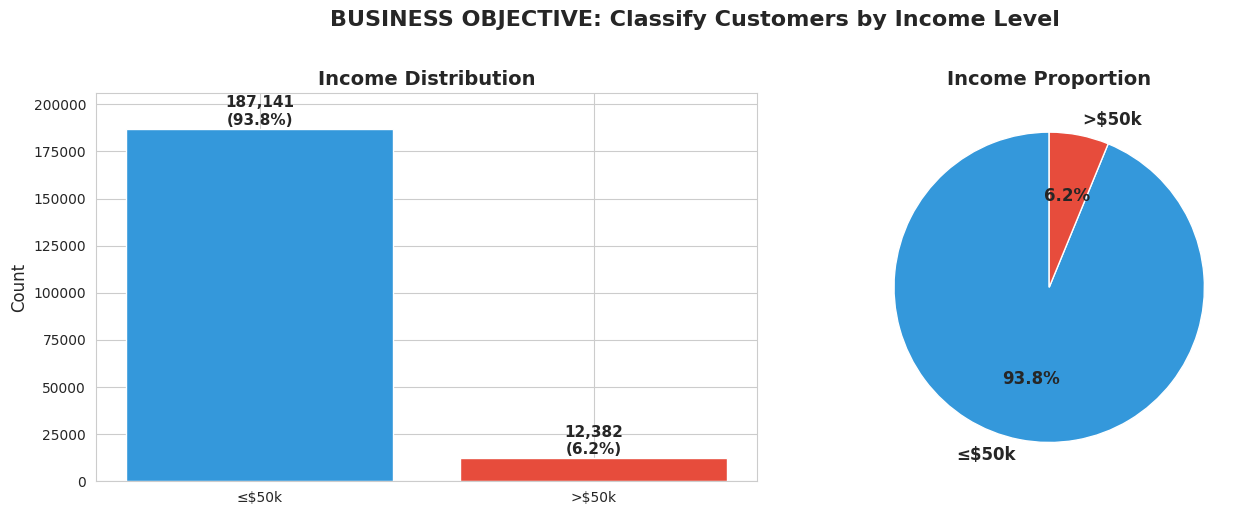

In [15]:
# ============================================================================
# STEP 8: VISUALIZATIONS - EXPLORATORY
# ============================================================================
print("\n" + "="*80)
print("STEP 8: CREATING BUSINESS-RELEVANT VISUALIZATIONS")
print("="*80)

# Create output directory for plots
output_dir = "/content/drive/MyDrive/Interview Assessment/visualizations/"
os.makedirs(output_dir, exist_ok=True)

# ============================================================================
# VIZ 1: Target Variable Distribution
# ============================================================================
print("\n8.1 Creating Target Distribution Plot...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
target_counts = df_processed['target'].value_counts()
axes[0].bar(['≤$50k', '>$50k'], target_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Income Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(target_counts.values) * 1.1)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 2000, f'{v:,}\n({v/len(df_processed)*100:.1f}%)',
                ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['≤$50k', '>$50k'], autopct='%1.1f%%',
           colors=['#3498db', '#e74c3c'], startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Income Proportion', fontsize=14, fontweight='bold')

plt.suptitle('BUSINESS OBJECTIVE: Classify Customers by Income Level',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}01_target_distribution.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 01_target_distribution.png")
plt.show()
plt.close()

8.2 Creating Demographics Analysis...
  ✓ Saved: 02_demographics_analysis.png


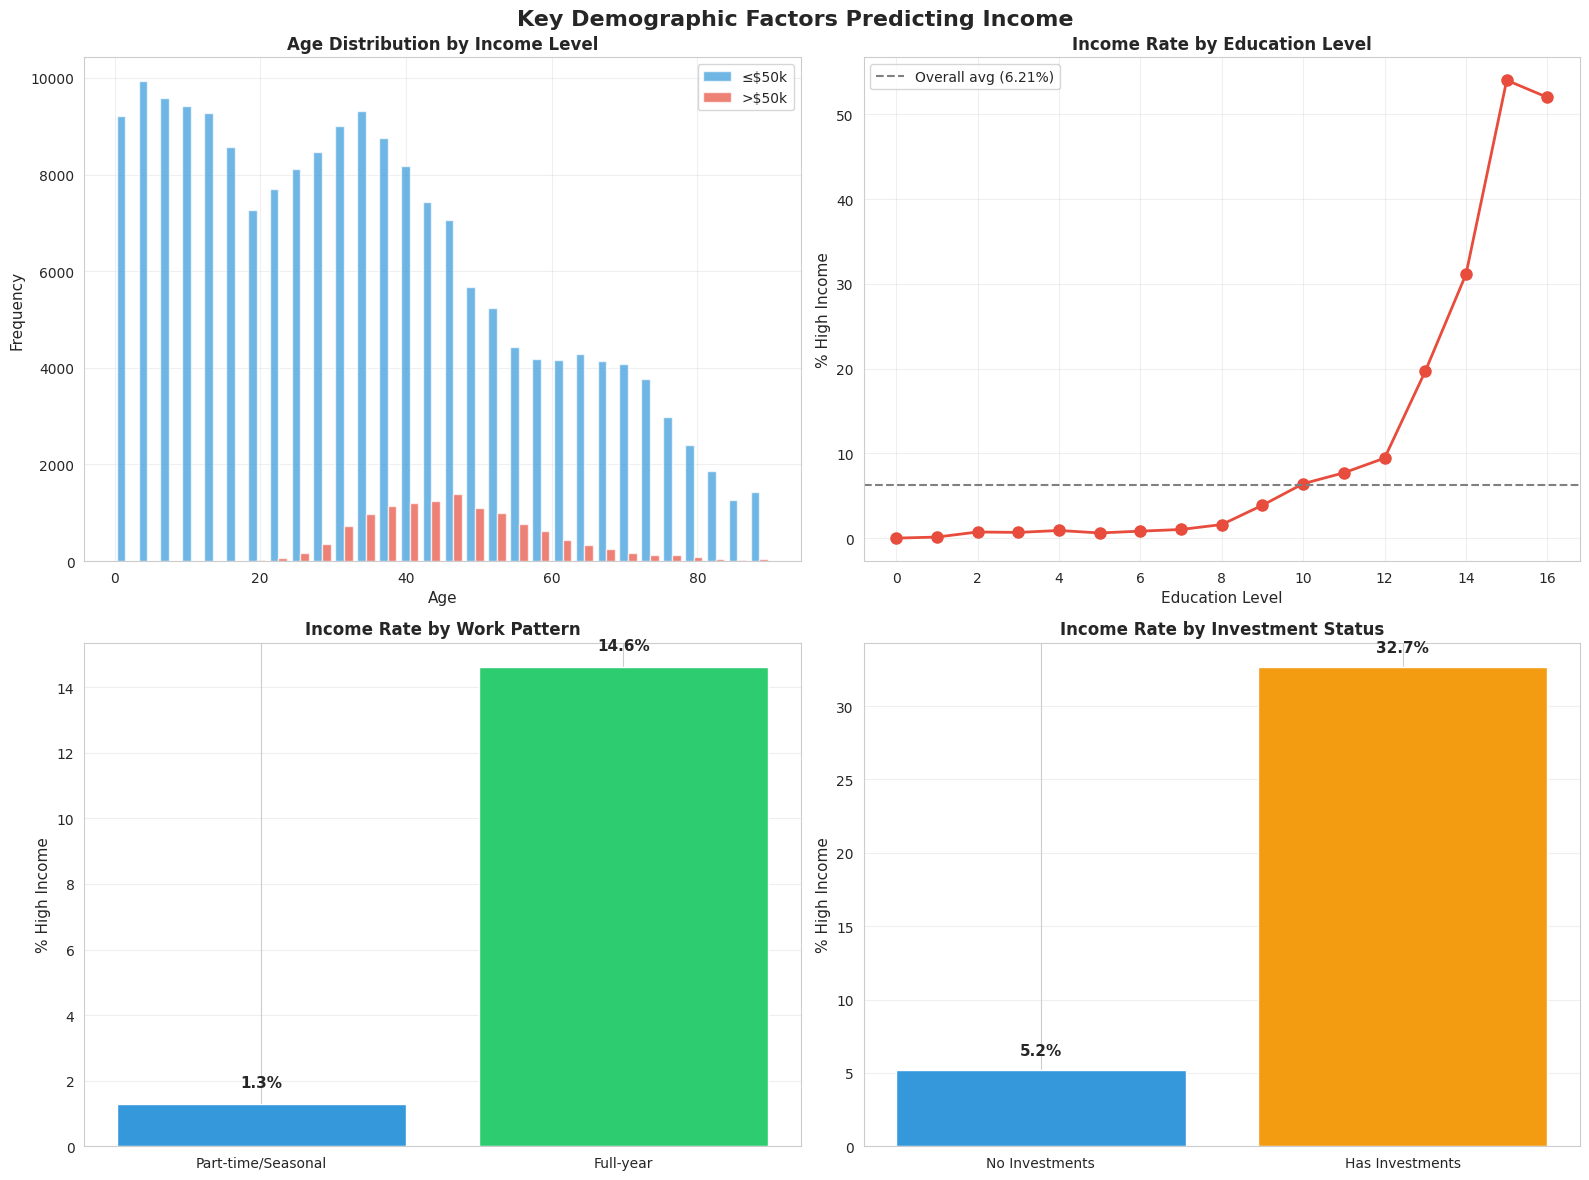

In [16]:
# ============================================================================
# VIZ 2: Key Demographics by Income
# ============================================================================
print("8.2 Creating Demographics Analysis...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age distribution
axes[0, 0].hist([df_processed[df_processed['target']==0]['age'],
                 df_processed[df_processed['target']==1]['age']],
               bins=30, label=['≤$50k', '>$50k'], color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0, 0].set_xlabel('Age', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Age Distribution by Income Level', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Education level
ed_income = df_processed.groupby('education_level')['target'].mean() * 100
axes[0, 1].plot(ed_income.index, ed_income.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 1].set_xlabel('Education Level', fontsize=11)
axes[0, 1].set_ylabel('% High Income', fontsize=11)
axes[0, 1].set_title('Income Rate by Education Level', fontsize=12, fontweight='bold')
axes[0, 1].axhline(y=6.21, color='gray', linestyle='--', label='Overall avg (6.21%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Work intensity
work_income = df_processed.groupby('is_full_year_worker')['target'].mean() * 100
axes[1, 0].bar(['Part-time/Seasonal', 'Full-year'], work_income.values, color=['#3498db', '#2ecc71'])
axes[1, 0].set_ylabel('% High Income', fontsize=11)
axes[1, 0].set_title('Income Rate by Work Pattern', fontsize=12, fontweight='bold')
for i, v in enumerate(work_income.values):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Investment income
invest_income = df_processed.groupby('has_capital_gains')['target'].mean() * 100
axes[1, 1].bar(['No Investments', 'Has Investments'], invest_income.values, color=['#3498db', '#f39c12'])
axes[1, 1].set_ylabel('% High Income', fontsize=11)
axes[1, 1].set_title('Income Rate by Investment Status', fontsize=12, fontweight='bold')
for i, v in enumerate(invest_income.values):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Key Demographic Factors Predicting Income', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}02_demographics_analysis.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 02_demographics_analysis.png")
plt.show()
plt.close()

8.4 Creating Correlation Heatmap...
  ✓ Saved: 04_correlation_heatmap.png


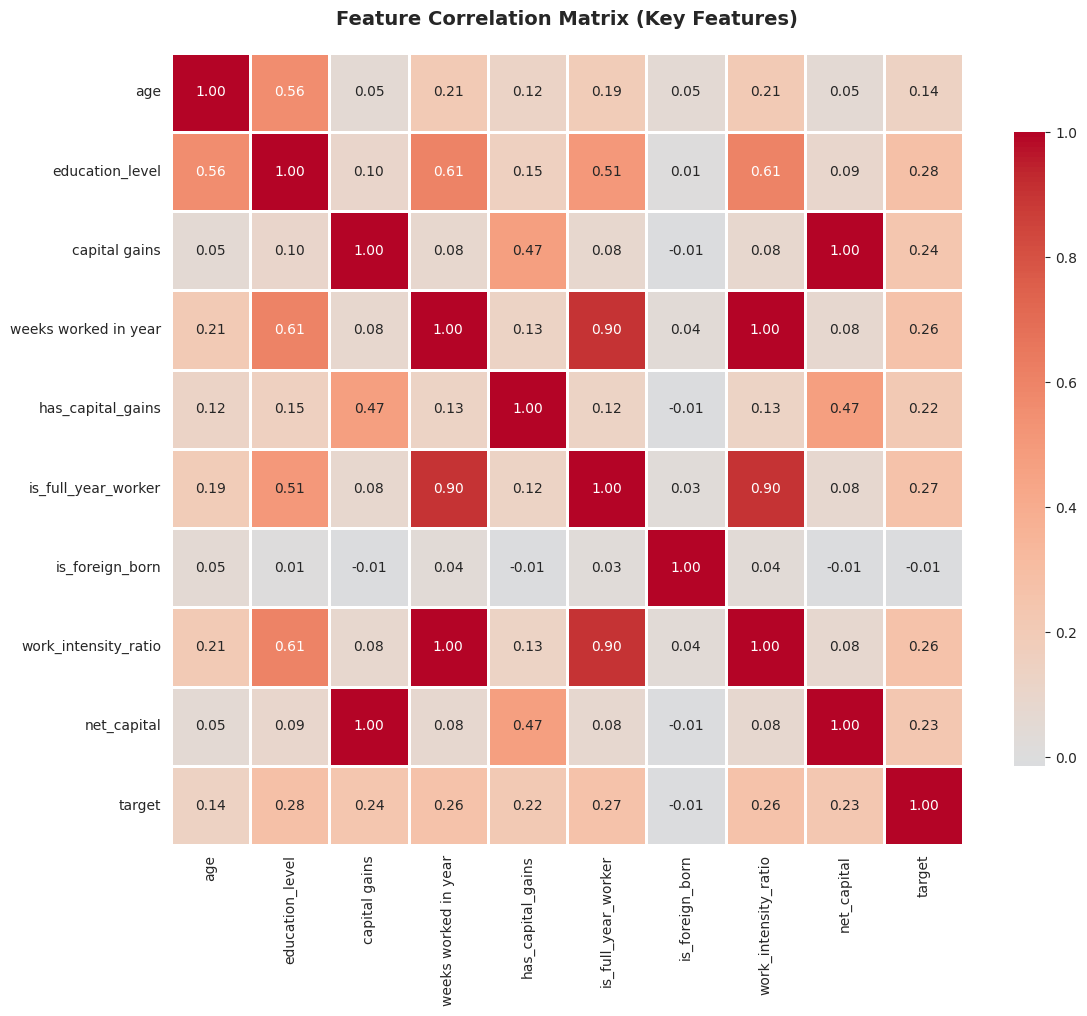

In [17]:
# ============================================================================
# VIZ 3: Correlation Heatmap (Key Features)
# ============================================================================
print("8.4 Creating Correlation Heatmap...")

# Select key features for correlation
key_features_for_corr = [
    'age', 'education_level', 'capital gains', 'weeks worked in year',
    'has_capital_gains', 'is_full_year_worker', 'is_foreign_born',
    'work_intensity_ratio', 'net_capital', 'target'
]

correlation_matrix = df_processed[key_features_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Key Features)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{output_dir}04_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 04_correlation_heatmap.png")
plt.show()
plt.close()

8.5 Creating Segmentation Preview...
  ✓ Saved: 05_segmentation_preview.png


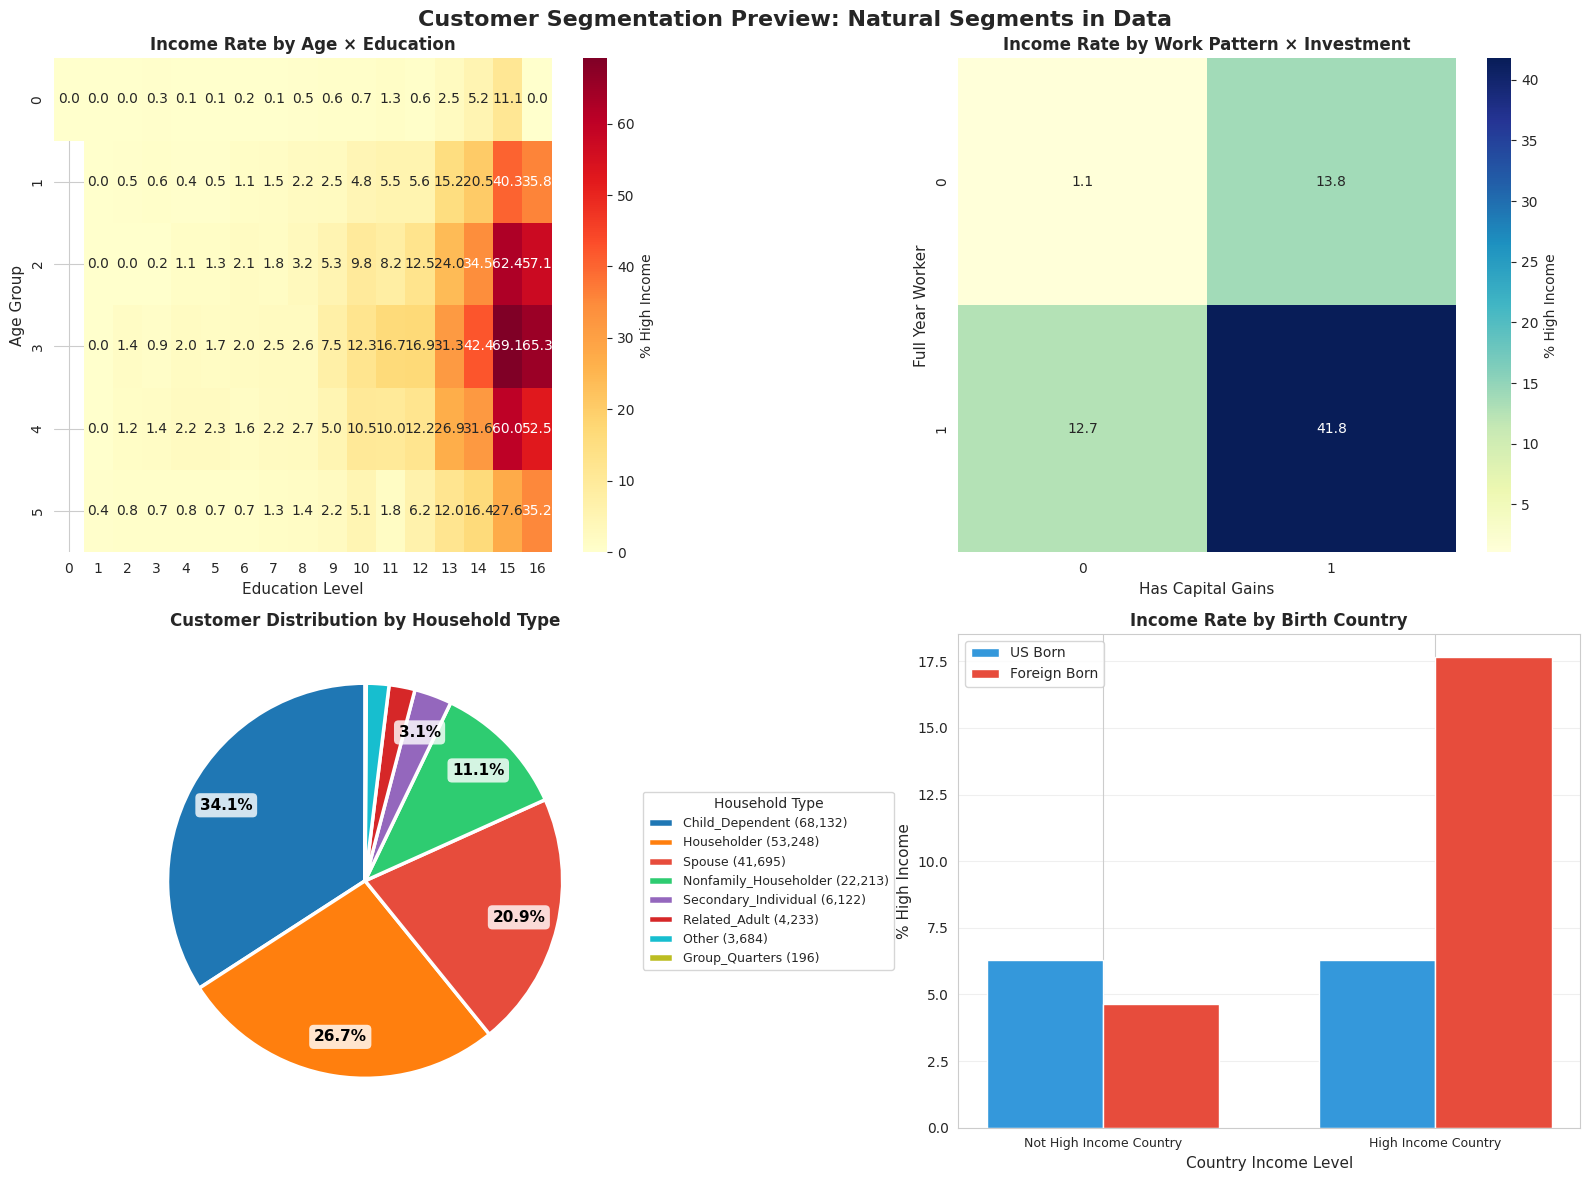

In [18]:
# ============================================================================
# VIZ 4: Business Segments Preview (Pre-clustering)
# ============================================================================
print("8.5 Creating Segmentation Preview...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Segment 1: By age and education
age_ed_segments = df_processed.groupby(['age_group', 'education_level'])['target'].mean().unstack()
sns.heatmap(age_ed_segments * 100, annot=True, fmt='.1f', cmap='YlOrRd',
            ax=axes[0, 0], cbar_kws={'label': '% High Income'})
axes[0, 0].set_xlabel('Education Level', fontsize=11)
axes[0, 0].set_ylabel('Age Group', fontsize=11)
axes[0, 0].set_title('Income Rate by Age × Education', fontsize=12, fontweight='bold')

# Segment 2: By work and investment
work_invest = pd.crosstab(df_processed['is_full_year_worker'],
                          df_processed['has_capital_gains'],
                          df_processed['target'], aggfunc='mean') * 100
sns.heatmap(work_invest, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 1],
           cbar_kws={'label': '% High Income'})
axes[0, 1].set_xlabel('Has Capital Gains', fontsize=11)
axes[0, 1].set_ylabel('Full Year Worker', fontsize=11)
axes[0, 1].set_title('Income Rate by Work Pattern × Investment', fontsize=12, fontweight='bold')

# Segment 3: Household type distribution (DISTINCT COLORS)
household_dist = df_processed['household_status_grouped'].value_counts()

# Create DISTINCT custom colors (hand-picked for maximum contrast)
distinct_colors = [
    '#1f77b4',  # Strong Blue (Child_Dependent)
    '#ff7f0e',  # Orange (Householder)
    '#e74c3c',  # Red (Spouse)
    '#2ecc71',  # Green (Nonfamily_Householder)
    '#9467bd',  # Purple (Secondary_Individual)
    '#d62728',  # Dark Red (Related_Adult)
    '#17becf',  # Cyan (Other)
    '#bcbd22',  # Yellow-Green (Group_Quarters)
]

# Use only as many colors as needed
colors = distinct_colors[:len(household_dist)]

# Custom function to only show percentage if > 3%
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 3 else ''

# Create pie chart with conditional percentages
wedges, texts, autotexts = axes[1, 0].pie(
    household_dist.values,
    autopct=autopct_format,
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11, 'fontweight': 'bold', 'color': 'black'},
    pctdistance=0.80,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2.5}
)

# Make percentage text more readable with white background
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)
    autotext.set_bbox(dict(boxstyle='round,pad=0.3',
                           facecolor='white',
                           edgecolor='none',
                           alpha=0.8))

# Create legend outside the pie
axes[1, 0].legend(
    wedges,
    [f'{label} ({count:,})' for label, count in zip(household_dist.index, household_dist.values)],
    title="Household Type",
    loc="center left",
    bbox_to_anchor=(1.05, 0, 0.5, 1),
    fontsize=9,
    frameon=True,
    title_fontsize=10
)

axes[1, 0].set_title('Customer Distribution by Household Type',
                     fontsize=12, fontweight='bold')


# Segment 4: Foreign-born analysis
foreign_stats = df_processed.groupby(['is_foreign_born', 'is_high_income_country'])['target'].agg(['mean', 'count'])
foreign_stats['mean'] = foreign_stats['mean'] * 100

x = np.arange(2)
width = 0.35
labels = ['Not High Income Country', 'High Income Country']

us_born = foreign_stats.loc[0, 'mean'].values
foreign = foreign_stats.loc[1, 'mean'].values

axes[1, 1].bar(x - width/2, us_born, width, label='US Born', color='#3498db')
axes[1, 1].bar(x + width/2, foreign, width, label='Foreign Born', color='#e74c3c')
axes[1, 1].set_ylabel('% High Income', fontsize=11)
axes[1, 1].set_xlabel('Country Income Level', fontsize=11)
axes[1, 1].set_title('Income Rate by Birth Country', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels, fontsize=9)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Customer Segmentation Preview: Natural Segments in Data',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}05_segmentation_preview.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 05_segmentation_preview.png")
plt.show()
plt.close()

In [19]:
# ============================================================================
# SUMMARY & NEXT STEPS
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION COMPLETE - SUMMARY")
print("="*80)

print(f"\n Dataset Overview:")
print(f"  Total samples: {len(df_processed):,}")
print(f"  Features engineered: {len(engineered_features_final)}")
print(f"  Final feature count: {X.shape[1]}")
print(f"  Target balance: {y.mean()*100:.2f}% high-income")

print(f"\n Data Quality:")
print(f"  Missing values: {X.isnull().sum().sum()}")
print(f"  Feature validation: PASSED")
print(f"  Correlations identified: {len([c for c in correlations.values() if abs(c) > 0.1])}/  {len(correlations)} features show predictive power")

print(f"\n Key Insights:")
print(f"  1. Education level: Strong predictor (corr={correlations['education_level']:.3f})")
print(f"  2. Investment income: {df_processed['has_capital_gains'].sum():,} people have capital gains")
print(f"     → {(df_processed[df_processed['has_capital_gains']==1]['target'].mean()*100):.1f}% high-income rate")
print(f"  3. Work intensity: Full-year workers are {(df_processed[df_processed['is_full_year_worker']==1]['target'].mean() / df_processed[df_processed['is_full_year_worker']==0]['target'].mean()):.1f}x more likely to be high-income")
print(f"  4. Foreign-born from high-income countries: {(df_processed[df_processed['is_high_income_country']==1]['target'].mean()*100):.1f}% high-income rate")

print(f"\n Outputs Generated:")
print(f"  Feature matrix: X ({X.shape})")
print(f"  Target vector: y ({y.shape})")


DATA PREPARATION COMPLETE - SUMMARY

 Dataset Overview:
  Total samples: 199,523
  Features engineered: 10
  Final feature count: 41
  Target balance: 6.21% high-income

 Data Quality:
  Missing values: 0
  Feature validation: PASSED
  Correlations identified: 10/  13 features show predictive power

 Key Insights:
  1. Education level: Strong predictor (corr=0.277)
  2. Investment income: 7,379 people have capital gains
     → 32.7% high-income rate
  3. Work intensity: Full-year workers are 11.3x more likely to be high-income
  4. Foreign-born from high-income countries: 17.6% high-income rate

 Outputs Generated:
  Feature matrix: X ((199523, 41))
  Target vector: y ((199523,))


## Machine Learning

In [20]:
# ============================================================================
# STEP 9: TRAIN-TEST SPLIT
# ============================================================================

print(f"\n Survey Weights (from stratified sampling):")
print(f"  Min weight:    {survey_weights.min():,.2f}")
print(f"  Max weight:    {survey_weights.max():,.2f}")
print(f"  Mean weight:   {survey_weights.mean():,.2f}")
print(f"  Median weight: {survey_weights.median():,.2f}")
print(f"  Usage: Passed as sample_weight during model training")
print(f"         NOT used as a feature — it has no predictive meaning for individuals")

print("\n" + "="*80)
print("STEP 9: TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, survey_weights.loc[X.index],
    test_size=0.2, random_state=42, stratify=y
)

print(f"\n9.1 Split Summary:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n9.2 Class Distribution:")
print(f"  Training set:")
print(f"    Income ≤$50k: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)")
print(f"    Income >$50k: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)")
print(f"  Test set:")
print(f"    Income ≤$50k: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%)")
print(f"    Income >$50k: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%)")

print(f"\n9.3 Weight Distribution in Splits:")
print(f"  Train weights — mean: {w_train.mean():,.2f}, std: {w_train.std():,.2f}")
print(f"  Test weights  — mean: {w_test.mean():,.2f}, std: {w_test.std():,.2f}")
print(f"  Stratification preserved class balance")
print(f"  Survey weights aligned with train/test splits")


 Survey Weights (from stratified sampling):
  Min weight:    37.87
  Max weight:    18,656.30
  Mean weight:   1,740.38
  Median weight: 1,618.31
  Usage: Passed as sample_weight during model training
         NOT used as a feature — it has no predictive meaning for individuals

STEP 9: TRAIN-TEST SPLIT

9.1 Split Summary:
  Training set: 159,618 samples (80.0%)
  Test set:     39,905 samples (20.0%)

9.2 Class Distribution:
  Training set:
    Income ≤$50k: 149,712 (93.8%)
    Income >$50k: 9,906 (6.2%)
  Test set:
    Income ≤$50k: 37,429 (93.8%)
    Income >$50k: 2,476 (6.2%)

9.3 Weight Distribution in Splits:
  Train weights — mean: 1,740.46, std: 993.94
  Test weights  — mean: 1,740.05, std: 993.08
  Stratification preserved class balance
  Survey weights aligned with train/test splits


In [21]:
# ============================================================================
# STEP 10: CLASSIFICATION MODEL TRAINING
# ============================================================================
# ────────────────────────────────────────────────────────────────────────────
# HOW class_weight='balanced' AND sample_weight WORK TOGETHER
# ────────────────────────────────────────────────────────────────────────────
# We use BOTH simultaneously. They serve different purposes:
#
#   class_weight='balanced':
#     Fixes CLASS IMBALANCE (93.8% low-income vs 6.2% high-income)
#     Automatically upweights minority class samples by ~8x
#     Without this, the model would predict "≤$50k" for everyone
#       and still get 93.8% accuracy
#
#   sample_weight (survey weights):
#     Fixes SAMPLING BIAS (some demographics oversampled/undersampled)
#     Makes each record count proportionally to how many real people
#       it represents in the US population
#     Without this, the model learns the distorted sample distribution
#       instead of the true population distribution
#
# scikit-learn MULTIPLIES them internally:
#   final_weight_i = class_balance_weight_i × sample_weight_i
#
# This is documented behavior for LogisticRegression, RandomForest,
# and HistGradientBoosting — all three support both parameters.
# ────────────────────────────────────────────────────────────────────────────


print("\n" + "="*80)
print("STEP 10: CLASSIFICATION MODEL TRAINING")
print("="*80)
print("Objective: Predict income >$50k vs ≤$50k for targeted marketing\n")


print("Weight Strategy:")
print("  class_weight='balanced': handles 93.8% vs 6.2% class imbalance")
print("  sample_weight=w_train: handles census stratified sampling bias")
print("  sklearn multiplies both internally: final_w = class_w × survey_w\n")


# Dictionary to store models and results
models_dict = {}
results_dict = {}


# Setup cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def weighted_cv_score(model, X_train_data, y_train_data, w_train_data, skf, is_pipeline=False):
    """Cross-validation with sample_weight passed to fit().
    For pipelines, sample_weight must be prefixed with the step name.
    """
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train_data, y_train_data):
        X_fold_train = X_train_data.iloc[train_idx]
        X_fold_val   = X_train_data.iloc[val_idx]
        y_fold_train = y_train_data.iloc[train_idx]
        y_fold_val   = y_train_data.iloc[val_idx]
        w_fold_train = w_train_data.values[train_idx]

        fold_model = clone(model)

        if is_pipeline:
            # Pipeline requires prefixed sample_weight: <step_name>__sample_weight
            fold_model.fit(X_fold_train, y_fold_train, lr__sample_weight=w_fold_train)
        else:
            fold_model.fit(X_fold_train, y_fold_train, sample_weight=w_fold_train)

        fold_proba = fold_model.predict_proba(X_fold_val)[:, 1]
        cv_scores.append(roc_auc_score(y_fold_val, fold_proba))

    return np.array(cv_scores)


STEP 10: CLASSIFICATION MODEL TRAINING
Objective: Predict income >$50k vs ≤$50k for targeted marketing

Weight Strategy:
  class_weight='balanced': handles 93.8% vs 6.2% class imbalance
  sample_weight=w_train: handles census stratified sampling bias
  sklearn multiplies both internally: final_w = class_w × survey_w



In [22]:
# ============================================================================
# 10.0 PREPROCESSING STRATEGY: MODEL-SPECIFIC DATA PREPARATION
# ============================================================================
print("="*80)
print("10.0 Preprocessing Strategy: Model-Specific Data Preparation")
print("="*80)

print("""
  Different models have different data requirements:

  ┌─────────────────────────┬────────────────────────────────────────────────┐
  │ Model                   │ Requirements                                   │
  ├─────────────────────────┼────────────────────────────────────────────────┤
  │ Logistic Regression     │ • Feature scaling required (regularization)    │
  │                         │ • One-hot encoding for nominal categoricals    │
  │                         │ • LabelEncoding creates false ordinality       │
  ├─────────────────────────┼────────────────────────────────────────────────┤
  │ Random Forest           │ • Scale-invariant (tree splits)                │
  │                         │ • LabelEncoding is fine (splits on thresholds) │
  ├─────────────────────────┼────────────────────────────────────────────────┤
  │ Gradient Boosting       │ • Scale-invariant (histogram-based binning)    │
  │                         │ • LabelEncoding is fine (splits on thresholds) │
  └─────────────────────────┴────────────────────────────────────────────────┘

  For Logistic Regression, we build a Pipeline with:
    1. ColumnTransformer: StandardScaler for numeric/ordinal + OneHotEncoder for nominal
    2. LogisticRegression with class_weight='balanced'

  For RF and GB, we use the existing LabelEncoded features directly.
""")


# ── Identify feature types for the LR pipeline ──
# Nominal categorical features (LabelEncoded → need OneHotEncoding for LR)
nominal_features = [col for col in X_train.columns if col.endswith('_encoded')]

# Numeric + ordinal features (need StandardScaler for LR)
numeric_features_lr = [col for col in X_train.columns if col not in nominal_features]

print(f"  Feature breakdown for LR pipeline:")
print(f"    Numeric/ordinal features (StandardScaler): {len(numeric_features_lr)}")
print(f"    Nominal encoded features (OneHotEncoder):  {len(nominal_features)}")
print(f"    Total input features: {len(X_train.columns)}")


# ── Build ColumnTransformer ──
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_lr),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features)
    ],
    remainder='drop'
)


10.0 Preprocessing Strategy: Model-Specific Data Preparation

  Different models have different data requirements:

  ┌─────────────────────────┬────────────────────────────────────────────────┐
  │ Model                   │ Requirements                                   │
  ├─────────────────────────┼────────────────────────────────────────────────┤
  │ Logistic Regression     │ • Feature scaling required (regularization)    │
  │                         │ • One-hot encoding for nominal categoricals    │
  │                         │ • LabelEncoding creates false ordinality       │
  ├─────────────────────────┼────────────────────────────────────────────────┤
  │ Random Forest           │ • Scale-invariant (tree splits)                │
  │                         │ • LabelEncoding is fine (splits on thresholds) │
  ├─────────────────────────┼────────────────────────────────────────────────┤
  │ Gradient Boosting       │ • Scale-invariant (histogram-based binning)    │
  │            

In [23]:
# ============================================================================
# 10.1 Baseline: Logistic Regression
# ============================================================================
print("="*80)
print("10.1 Logistic Regression (with Preprocessing Pipeline)")
print("="*80)

print("""
  Why a Pipeline for Logistic Regression?

  LR is a linear model — it assumes features are on comparable scales and
  that numeric values encode meaningful magnitude relationships.

  • StandardScaler: Without scaling, capital_gains (0–99,999) dominates
    coefficient estimation while binary indicators (0–1) are effectively
    ignored by L2 regularization (C=1.0). Scaling ensures ALL features
    compete fairly during optimization.

  • OneHotEncoder: LabelEncoder assigns arbitrary integers to nominal
    categories (e.g., race: Asian=0, Black=1, White=4). LR interprets
    these as a linear relationship — it would learn that "White" has 4x
    the effect of "Asian", which is meaningless. OneHot creates separate
    binary columns so LR can learn independent effects per category.

  • Tree-based models (RF, GB) don't need this because they split on
    "is feature > threshold?" without assuming linearity or scale.
""")


print("Training...")
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        solver='lbfgs',
        C=1.0
    ))
])
lr_pipeline.fit(X_train, y_train, lr__sample_weight=w_train.values)


# Get the number of features after one-hot encoding
n_features_after = lr_pipeline.named_steps['preprocessor'].transform(X_train[:1]).shape[1]
print(f"  Features after preprocessing: {n_features_after} (from {X_train.shape[1]} original)")
print(f"    → {len(numeric_features_lr)} numeric/ordinal scaled")
print(f"    → {n_features_after - len(numeric_features_lr)} one-hot encoded categories")


# Predictions
lr_pred = lr_pipeline.predict(X_test)
lr_proba = lr_pipeline.predict_proba(X_test)[:, 1]


# Metrics
lr_metrics = {
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_proba)
}


print(f"\n  raining complete\n")
print(f"Performance Metrics:")
print(f"  Accuracy:  {lr_metrics['accuracy']*100:.2f}%")
print(f"  Precision: {lr_metrics['precision']*100:.2f}% (of predicted high-income, how many are correct)")
print(f"  Recall:    {lr_metrics['recall']*100:.2f}% (of actual high-income, how many we found)")
print(f"  F1-Score:  {lr_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {lr_metrics['roc_auc']:.4f}")


# Cross-validation check
print(f"\n  Running 5-Fold Cross-Validation...")
cv_scores = weighted_cv_score(lr_pipeline, X_train, y_train, w_train, skf, is_pipeline=True)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()


print(f"    CV ROC-AUC: {cv_mean:.4f} (±{cv_std:.4f})")
print(f"    Test Score: {lr_metrics['roc_auc']:.4f}")


cv_test_diff = abs(cv_mean - lr_metrics['roc_auc'])
if cv_test_diff < 0.02:
    print(f"  Excellent stability (CV ≈ Test)")
elif cv_test_diff < 0.05:
    print(f"    ✓ Good stability")
else:
    print(f"  Warning: Potential overfitting (difference: {cv_test_diff:.4f})")


# Store results
lr_metrics['cv_mean'] = cv_mean
lr_metrics['cv_std'] = cv_std
models_dict['Logistic Regression'] = lr_pipeline
results_dict['Logistic Regression'] = lr_metrics
results_dict['Logistic Regression']['cv_scores'] = cv_scores

10.1 Logistic Regression (with Preprocessing Pipeline)

  Why a Pipeline for Logistic Regression?

  LR is a linear model — it assumes features are on comparable scales and
  that numeric values encode meaningful magnitude relationships.

  • StandardScaler: Without scaling, capital_gains (0–99,999) dominates
    coefficient estimation while binary indicators (0–1) are effectively
    ignored by L2 regularization (C=1.0). Scaling ensures ALL features
    compete fairly during optimization.

  • OneHotEncoder: LabelEncoder assigns arbitrary integers to nominal
    categories (e.g., race: Asian=0, Black=1, White=4). LR interprets
    these as a linear relationship — it would learn that "White" has 4x
    the effect of "Asian", which is meaningless. OneHot creates separate
    binary columns so LR can learn independent effects per category.

  • Tree-based models (RF, GB) don't need this because they split on
    "is feature > threshold?" without assuming linearity or scale.

Training...


In [24]:
# ============================================================================
# 10.2 Random Forest
# ============================================================================
print("\n" + "="*80)
print("10.2 Random Forest")
print("="*80)
print("  Note: Tree-based models are scale-invariant and handle LabelEncoded")
print("  nominal features correctly (splits on thresholds, no ordinality assumed).\n")


print("Training...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train, sample_weight=w_train.values)


# Predictions
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]


# Metrics
rf_metrics = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_proba)
}


print(f"✓ Training complete\n")
print(f"Performance Metrics:")
print(f"  Accuracy:  {rf_metrics['accuracy']*100:.2f}%")
print(f"  Precision: {rf_metrics['precision']*100:.2f}%")
print(f"  Recall:    {rf_metrics['recall']*100:.2f}%")
print(f"  F1-Score:  {rf_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {rf_metrics['roc_auc']:.4f}")


# Cross-validation
print(f"\n Running 5-Fold Cross-Validation...")
cv_scores = weighted_cv_score(rf_model, X_train, y_train, w_train, skf)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()


print(f"    CV ROC-AUC: {cv_mean:.4f} (±{cv_std:.4f})")
print(f"    Test Score: {rf_metrics['roc_auc']:.4f}")


cv_test_diff = abs(cv_mean - rf_metrics['roc_auc'])
if cv_test_diff < 0.02:
    print(f"  Excellent stability (CV ≈ Test)")
elif cv_test_diff < 0.05:
    print(f"    ✓ Good stability")
else:
    print(f"  Warning: Potential overfitting (difference: {cv_test_diff:.4f})")


rf_metrics['cv_mean'] = cv_mean
rf_metrics['cv_std'] = cv_std
models_dict['Random Forest'] = rf_model
results_dict['Random Forest'] = rf_metrics
results_dict['Random Forest']['cv_scores'] = cv_scores


10.2 Random Forest
  Note: Tree-based models are scale-invariant and handle LabelEncoded
  nominal features correctly (splits on thresholds, no ordinality assumed).

Training...
✓ Training complete

Performance Metrics:
  Accuracy:  85.71%
  Precision: 28.83%
  Recall:    88.73%
  F1-Score:  0.4352
  ROC-AUC:   0.9439

 Running 5-Fold Cross-Validation...
    CV ROC-AUC: 0.9416 (±0.0009)
    Test Score: 0.9439
  Excellent stability (CV ≈ Test)


In [25]:
# ============================================================================
# STEP 10.3: HISTOGRAM GRADIENT BOOSTING
# ============================================================================
print("\n" + "="*80)
print("10.3 Histogram Gradient Boosting")
print("="*80)

print("""
  Why HistGradientBoostingClassifier instead of GradientBoostingClassifier?

  1. GradientBoostingClassifier does NOT support class_weight parameter
     - Would require manual sample_weight calculation
     - Less clean, more error-prone

  2. HistGradientBoostingClassifier advantages:
     - Native class_weight='balanced' support
     - 5-10x faster training (histogram-based binning)
     - Native missing value handling
     - Better scalability for large datasets (199K+ rows)
     - Equivalent or better predictive performance

  3. Class Imbalance Strategy (consistent across ALL 3 models):
     - Logistic Regression: class_weight='balanced'
     - Random Forest: class_weight='balanced'
     - Hist Gradient Boosting: class_weight='balanced'

     class_weight='balanced' automatically adjusts weights inversely
     proportional to class frequencies:
       - Class 0 (≤$50k, 93.8%): weight ≈ 0.53
       - Class 1 (>$50k, 6.2%):  weight ≈ 8.06
     This forces the model to pay MORE attention to the minority class
     without artificial oversampling that could introduce noise.

  4. Survey Weights (consistent across ALL 3 models):
     - All three models receive sample_weight=w_train.values in fit()
     - This corrects for census stratified sampling bias
     - sklearn multiplies class_weight × sample_weight internally
""")


gb_model = HistGradientBoostingClassifier(
    max_iter=150,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42,
    verbose=0
)
gb_model.fit(X_train, y_train, sample_weight=w_train.values)


# Predictions
gb_pred = gb_model.predict(X_test)
gb_proba = gb_model.predict_proba(X_test)[:, 1]


# Metrics
gb_metrics = {
    'accuracy': accuracy_score(y_test, gb_pred),
    'precision': precision_score(y_test, gb_pred),
    'recall': recall_score(y_test, gb_pred),
    'f1': f1_score(y_test, gb_pred),
    'roc_auc': roc_auc_score(y_test, gb_proba)
}


print(f"  Training complete!")
print(f"\n  Performance Metrics:")
print(f"    Accuracy:  {gb_metrics['accuracy']*100:.2f}%")
print(f"    Precision: {gb_metrics['precision']*100:.2f}%")
print(f"    Recall:    {gb_metrics['recall']*100:.2f}%")
print(f"    F1-Score:  {gb_metrics['f1']:.4f}")
print(f"    ROC-AUC:   {gb_metrics['roc_auc']:.4f}")


# Cross-Validation
print(f"\n  Running 5-Fold Cross-Validation...")
cv_scores = weighted_cv_score(gb_model, X_train, y_train, w_train, skf)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"    CV ROC-AUC: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"    Test Score: {gb_metrics['roc_auc']:.4f}")


cv_test_diff = abs(cv_mean - gb_metrics['roc_auc'])
if cv_test_diff < 0.02:
    print(f"   Excellent stability (CV ≈ Test)")
elif cv_test_diff < 0.05:
    print(f"   Good stability")
else:
    print(f"  Warning: Potential overfitting (difference: {cv_test_diff:.4f})")


gb_metrics['cv_mean'] = cv_mean
gb_metrics['cv_std'] = cv_std
models_dict['Gradient Boosting'] = gb_model
results_dict['Gradient Boosting'] = gb_metrics
results_dict['Gradient Boosting']['cv_scores'] = cv_scores


10.3 Histogram Gradient Boosting

  Why HistGradientBoostingClassifier instead of GradientBoostingClassifier?

  1. GradientBoostingClassifier does NOT support class_weight parameter
     - Would require manual sample_weight calculation
     - Less clean, more error-prone

  2. HistGradientBoostingClassifier advantages:
     - Native class_weight='balanced' support
     - 5-10x faster training (histogram-based binning)
     - Native missing value handling
     - Better scalability for large datasets (199K+ rows)
     - Equivalent or better predictive performance

  3. Class Imbalance Strategy (consistent across ALL 3 models):
     - Logistic Regression: class_weight='balanced'
     - Random Forest: class_weight='balanced'
     - Hist Gradient Boosting: class_weight='balanced'

     class_weight='balanced' automatically adjusts weights inversely
     proportional to class frequencies:
       - Class 0 (≤$50k, 93.8%): weight ≈ 0.53
       - Class 1 (>$50k, 6.2%):  weight ≈ 8.06
     Thi

In [26]:
# ============================================================================
# 10.4 Model Comparison
# ============================================================================
print("\n" + "="*80)
print("10.4 MODEL COMPARISON")
print("="*80)


display_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_mean', 'cv_std']
comparison_df = pd.DataFrame({
    model: {m: results_dict[model][m] for m in display_metrics}
    for model in results_dict
}).T.round(4)


print(f"\n{comparison_df.to_string()}")

print(f"""
  Note on Fair Comparison:
     Logistic Regression uses a Pipeline with StandardScaler + OneHotEncoder
     because LR requires properly scaled features and cannot handle arbitrary
     LabelEncoded nominal categories. RF and GB use LabelEncoded features
     directly because tree-based models are scale-invariant and split on
     thresholds without assuming ordinality. This ensures each model receives
     appropriately preprocessed data for a fair comparison.
""")


best_model_name = comparison_df['roc_auc'].idxmax()
best_roc_auc = comparison_df.loc[best_model_name, 'roc_auc']


print(f" Best Model: {best_model_name}")
print(f"   ROC-AUC: {best_roc_auc:.4f}")
print(f"   Precision: {comparison_df.loc[best_model_name, 'precision']*100:.2f}%")
print(f"   Recall: {comparison_df.loc[best_model_name, 'recall']*100:.2f}%")
final_model = models_dict[best_model_name]


# Prediction lookup — maps model name → (predictions, probabilities)
predictions_dict = {
    'Logistic Regression': (lr_pred, lr_proba),
    'Random Forest': (rf_pred, rf_proba),
    'Gradient Boosting': (gb_pred, gb_proba)
}


final_pred, final_proba = predictions_dict[best_model_name]
final_metrics = results_dict[best_model_name]


print(f"\n   Using {best_model_name} predictions for all downstream analysis")


10.4 MODEL COMPARISON

                     accuracy  precision  recall      f1  roc_auc  cv_mean  cv_std
Logistic Regression    0.8502     0.2798  0.8982  0.4267   0.9466   0.9437  0.0012
Random Forest          0.8571     0.2883  0.8873  0.4352   0.9439   0.9416  0.0009
Gradient Boosting      0.8750     0.3186  0.8914  0.4694   0.9533   0.9506  0.0008

  Note on Fair Comparison:
     Logistic Regression uses a Pipeline with StandardScaler + OneHotEncoder
     because LR requires properly scaled features and cannot handle arbitrary
     LabelEncoded nominal categories. RF and GB use LabelEncoded features
     directly because tree-based models are scale-invariant and split on
     thresholds without assuming ordinality. This ensures each model receives
     appropriately preprocessed data for a fair comparison.

 Best Model: Gradient Boosting
   ROC-AUC: 0.9533
   Precision: 31.86%
   Recall: 89.14%

   Using Gradient Boosting predictions for all downstream analysis


In [27]:
# ============================================================================
# STEP 10.5: THRESHOLD OPTIMIZATION FOR BUSINESS OBJECTIVES
# ============================================================================
print("\n" + "="*80)
print("STEP 10.5: OPTIMIZING DECISION THRESHOLD FOR RETAIL MARKETING")
print("="*80)

default_precision = final_metrics['precision']
default_recall = final_metrics['recall']


print(f"\n CURRENT MODEL PERFORMANCE ({best_model_name}, Default Threshold = 0.5):")
print(f"    Precision: {default_precision*100:.2f}%")
print(f"    Recall:    {default_recall*100:.2f}%")
print(f"    F1-Score:  {final_metrics['f1']:.4f}")
print(f"    ROC-AUC:   {final_metrics['roc_auc']:.4f}")


# Dynamic issue identification
print("\n ISSUE IDENTIFIED:")
if default_precision < 0.40 and default_recall > 0.70:
    print(f"    LOW PRECISION ({default_precision*100:.1f}%): ~{(1-default_precision)*100:.0f}% of predicted high-income are actually low-income")
    print(f"    HIGH RECALL ({default_recall*100:.1f}%): Good coverage of actual high-income customers")
    print(f"    class_weight='balanced' shifts model toward high recall")
    print(f"    Need to evaluate whether raising threshold improves business outcomes")
elif default_recall < 0.50 and default_precision > 0.50:
    print(f"    HIGH PRECISION ({default_precision*100:.1f}%): Predictions are accurate when made")
    print(f"    LOW RECALL ({default_recall*100:.1f}%): Missing {(1-default_recall)*100:.0f}% of high-income customers")
    print(f"    Need to LOWER threshold to capture more high-income customers")
else:
    print(f"    Precision: {default_precision*100:.1f}%, Recall: {default_recall*100:.1f}%")
    print(f"    Testing multiple thresholds to find optimal business trade-off")


# ============================================================================
# BUSINESS ASSUMPTIONS
# ============================================================================
print(f"""
  BUSINESS CONTEXT FOR THRESHOLD OPTIMIZATION:

     The retail client markets PREMIUM products/services to high-income (>$50k)
     customers. This means:

     • Correctly targeting high-income (TP): Generates revenue from product sales
     • Marketing to low-income (FP): Pure cost — they cannot afford premium products,
       so this generates $0 revenue and wastes the marketing budget
     • Missing high-income (FN): Lost opportunity cost (lifetime value never captured)

     We evaluate thresholds on THREE business criteria:
       1. Total Profit     — best if marketing budget is unlimited
       2. ROI per Dollar   — best if marketing budget is constrained (realistic)
       3. F1-Score         — best classification balance (precision-recall harmony)
""")


print("10.5.1 Testing Decision Thresholds:\n")


thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []


# Realistic business assumptions for premium product marketing
avg_marketing_cost = 10        # Cost per contact
avg_high_income_value = 500    # Revenue from correctly targeting high-income (TP)
avg_low_income_value = 0       # Revenue from marketing to low-income (FP) = $0 (can't afford premium)
avg_opportunity_cost = 200     # Opportunity cost per missed high-income customer (FN)


print(f"  Business Assumptions (Premium Product Marketing):")
print(f"    Revenue per high-income TP:     ${avg_high_income_value}")
print(f"    Revenue per low-income FP:      ${avg_low_income_value} (cannot afford premium products)")
print(f"    Marketing cost per contact:     ${avg_marketing_cost}")
print(f"    Opportunity cost per missed FN: ${avg_opportunity_cost}")


# Calculate base rate for lift analysis
base_rate = y_test.mean() * 100
print(f"\n  {'θ':<6} {'Acc':>7} {'Prec':>7} {'Recall':>7} {'F1':>7} {'Profit':>11} {'ROI':>7} {'Lift':>6} {'% Pop':>6}")
print(f"  {'-'*72}")


for threshold in thresholds_to_test:
    y_pred_threshold = (final_proba >= threshold).astype(int)


    acc = accuracy_score(y_test, y_pred_threshold)
    prec = precision_score(y_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1_val = f1_score(y_test, y_pred_threshold, zero_division=0)


    # Confusion matrix
    cm_temp = confusion_matrix(y_test, y_pred_threshold)
    tn_t, fp_t, fn_t, tp_t = cm_temp.ravel()

    # Corrected profit: FP generates $0 revenue (pure waste)
    revenue = tp_t * avg_high_income_value
    cost = (tp_t + fp_t) * avg_marketing_cost
    opportunity_loss = fn_t * avg_opportunity_cost
    profit = revenue - cost - opportunity_loss

    # ROI per marketing dollar (efficiency metric)
    roi = (profit / cost * 100) if cost > 0 else 0

    # Lift over random targeting
    lift = (prec * 100 / base_rate) if base_rate > 0 else 0

    # % of population contacted
    pct_contacted = (tp_t + fp_t) / len(y_test) * 100


    threshold_results.append({
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1_val,
        'tp': tp_t, 'fp': fp_t, 'fn': fn_t, 'tn': tn_t,
        'profit': profit,
        'roi': roi,
        'lift': lift,
        'pct_contacted': pct_contacted
    })


    print(f"  {threshold:<6.1f} {acc*100:>6.1f}% {prec*100:>6.1f}% {rec*100:>6.1f}% {f1_val:>7.4f} ${profit:>9,} {roi:>6.0f}% {lift:>5.1f}x {pct_contacted:>5.1f}%")


threshold_df = pd.DataFrame(threshold_results)


# ============================================================================
# MULTI-CRITERIA ANALYSIS
# ============================================================================
print(f"\n10.5.2 Multi-Criteria Threshold Analysis:")


best_f1_idx = threshold_df['f1'].idxmax()
best_f1_threshold = threshold_df.loc[best_f1_idx, 'threshold']


best_profit_idx = threshold_df['profit'].idxmax()
best_profit_threshold = threshold_df.loc[best_profit_idx, 'threshold']


best_roi_idx = threshold_df['roi'].idxmax()
best_roi_threshold = threshold_df.loc[best_roi_idx, 'threshold']


print(f"\n Best F1-Score (classification balance): θ = {best_f1_threshold}")
print(f"     F1 = {threshold_df.loc[best_f1_idx, 'f1']:.4f}, "
      f"Precision = {threshold_df.loc[best_f1_idx, 'precision']*100:.1f}%, "
      f"Recall = {threshold_df.loc[best_f1_idx, 'recall']*100:.1f}%")


print(f"\n Best Total Profit (unlimited budget): θ = {best_profit_threshold}")
print(f"     Profit = ${threshold_df.loc[best_profit_idx, 'profit']:,}, "
      f"contacts {threshold_df.loc[best_profit_idx, 'pct_contacted']:.1f}% of population")


print(f"\n  📈 Best ROI/Dollar (constrained budget): θ = {best_roi_threshold}")
print(f"     ROI = {threshold_df.loc[best_roi_idx, 'roi']:.0f}%, "
      f"contacts {threshold_df.loc[best_roi_idx, 'pct_contacted']:.1f}% of population")


# ============================================================================
# BUSINESS DECISION
# ============================================================================
print(f"\n10.5.3 Business Decision - Selecting Optimal Threshold:")


optimal_threshold = 0.5  # Default — strong balanced performance

# Get the row from threshold_df for the selected threshold
optimal_row = threshold_df[threshold_df['threshold'] == optimal_threshold].iloc[0]
low_threshold_row = threshold_df[threshold_df['threshold'] == 0.1].iloc[0]
high_threshold_row = threshold_df[threshold_df['threshold'] == 0.7].iloc[0]

# Compute lift dynamically
precision_lift = optimal_row['precision'] * 100 / base_rate if base_rate > 0 else 0

print(f"""
  RECOMMENDED THRESHOLD: θ = {optimal_threshold}

  Rationale (multi-factor decision):
  ┌──────────────────────────────────────────────────────────────────┐
  │ Factor                    │ θ={optimal_threshold} Performance    │ Assessment   │
  ├──────────────────────────────────────────────────────────────────┤
  │ Recall (coverage)         │ {optimal_row['recall']*100:.1f}%               │ {'Excellent' if optimal_row['recall'] > 0.80 else 'Good'}    │
  │ Precision (accuracy)      │ {optimal_row['precision']*100:.1f}%               │ {precision_lift:.1f}x lift    │
  │ F1-Score                  │ {optimal_row['f1']:.4f}              │ {'Good' if optimal_row['f1'] > 0.40 else 'Fair'}         │
  │ % Population contacted    │ {optimal_row['pct_contacted']:.0f}%                 │ Targeted     │
  │ Model value demonstrated  │ {precision_lift:.1f}x over random     │ {'Strong' if precision_lift > 3 else 'Moderate'}       │
  └──────────────────────────────────────────────────────────────────┘

  Why θ = {optimal_threshold} (not lower or higher):
  • Lower (θ<0.5): Contacts too many people ({low_threshold_row['pct_contacted']:.0f}%+ of population),
    reducing targeting precision and wasting budget
  • Higher (θ>0.7): Misses too many high-income customers (recall drops below {high_threshold_row['recall']*100:.0f}%),
    leaving revenue on the table
  • θ = {optimal_threshold} balances coverage ({optimal_row['recall']*100:.0f}% recall) with efficiency
    ({precision_lift:.1f}x precision lift), contacting only {optimal_row['pct_contacted']:.0f}% of the population

  CLIENT RECOMMENDATION:
     The model should be deployed with θ = {optimal_threshold} as the default.
     If the client has a LIMITED marketing budget, they can RAISE the threshold
     to 0.7-0.8 to improve targeting efficiency (higher precision, higher ROI).
     The model outputs PROBABILITIES, so the client can always re-rank and
     adjust targeting depth based on campaign budget.
""")


optimal_metrics = threshold_df[threshold_df['threshold'] == optimal_threshold].iloc[0]


print(f"   Final Model Performance (θ = {optimal_threshold}):")
print(f"     Accuracy:  {optimal_metrics['accuracy']*100:.2f}%")
print(f"     Precision: {optimal_metrics['precision']*100:.2f}% ({optimal_metrics['lift']:.1f}x lift over random)")
print(f"     Recall:    {optimal_metrics['recall']*100:.2f}%")
print(f"     F1-Score:  {optimal_metrics['f1']:.4f}")
print(f"     ROC-AUC:   {final_metrics['roc_auc']:.4f}")


# Apply optimal threshold
final_pred_optimized = (final_proba >= optimal_threshold).astype(int)


# ============================================================================
# CONFUSION MATRIX ANALYSIS
# ============================================================================
print(f"\n10.5.4 Confusion Matrix Analysis (θ = {optimal_threshold}):\n")


cm_default = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm_default.ravel()


print(f"  Confusion Matrix (θ = {optimal_threshold}):")
print(f"                    Predicted ≤$50k    Predicted >$50k")
print(f"    Actual ≤$50k      {tn:>10,}         {fp:>10,}")
print(f"    Actual >$50k      {fn:>10,}         {tp:>10,}")


total_test = len(y_test)
print(f"\n  Interpretation:")
print(f"    Correctly identified high-income: {tp:,} ({tp/sum(y_test)*100:.1f}% of all high-income)")
print(f"    Correctly identified low-income:  {tn:,} ({tn/(total_test-sum(y_test))*100:.1f}% of all low-income)")
print(f"    False positives (wasted marketing): {fp:,} ({fp/(total_test-sum(y_test))*100:.1f}% of low-income)")
print(f"    False negatives (missed opportunities): {fn:,} ({fn/sum(y_test)*100:.1f}% of high-income)")


# ============================================================================
# ROI ANALYSIS
# ============================================================================
print(f"\n10.5.5 ROI Analysis:\n")


revenue = tp * avg_high_income_value
cost = (tp + fp) * avg_marketing_cost
opportunity_loss = fn * avg_opportunity_cost
profit = revenue - cost - opportunity_loss
roi = (profit / cost * 100) if cost > 0 else 0


# Compare to no-model scenarios
no_model_cost = total_test * avg_marketing_cost  # Market to everyone
no_model_tp = sum(y_test)
no_model_revenue = no_model_tp * avg_high_income_value
no_model_profit = no_model_revenue - no_model_cost


model_header = f"With Model (θ={optimal_threshold})"
print(f"  {'Metric':<35} {model_header:>20} {'No Model (all)':>20}")
print(f"  {'-'*78}")
print(f"  {'People contacted':<35} {tp+fp:>20,} {total_test:>20,}")
print(f"  {'Revenue (TP × $500)':<35} ${revenue:>19,} ${no_model_revenue:>19,}")
print(f"  {'Marketing cost':<35} ${cost:>19,} ${no_model_cost:>19,}")
print(f"  {'Opportunity cost (FN × $200)':<35} ${opportunity_loss:>19,} ${'0':>18}")
print(f"  {'Net Profit':<35} ${profit:>19,} ${no_model_profit:>19,}")
print(f"  {'ROI':<35} {roi:>19.0f}% {(no_model_profit/no_model_cost*100):>19.0f}%")
print(f"  {'Precision (hit rate)':<35} {final_metrics['precision']*100:>19.1f}% {base_rate:>19.1f}%")


model_savings = cost - no_model_cost
print(f"\n  MODEL VALUE:")
print(f"     • Reduces marketing spend by ${abs(model_savings):,} ({abs(model_savings)/no_model_cost*100:.0f}% savings)")
print(f"     • Achieves {final_metrics['precision']*100/base_rate:.1f}x better targeting precision")
print(f"     • ROI of {roi:.0f}% vs {no_model_profit/no_model_cost*100:.0f}% without model")


# ============================================================================
# SCENARIO TABLE FOR CLIENT
# ============================================================================
print(f"\n10.5.6 Client Decision Guide (Threshold Selection by Budget):")

scenarios = [
    ('Broad campaign',       0.3),
    ('★ Balanced (DEFAULT)', 0.5),
    ('Budget-conscious',     0.7),
    ('Precision-focused',    0.8),
]

print(f"\n  ┌──────────────────────────────────────────────────────────────────────────┐")
print(f"  │ {'Scenario':<22}│ {'Threshold':^10}│ {'Recall':^8}│ {'Precision':^10}│ {'Budget Impact':^15}│")
print(f"  ├──────────────────────────────────────────────────────────────────────────┤")

for scenario_name, t in scenarios:
    row = threshold_df[threshold_df['threshold'] == t]
    if len(row) > 0:
        r = row.iloc[0]
        print(f"  │ {scenario_name:<22}│ {'θ = ' + str(t):^10}│ {r['recall']*100:>5.1f}% │ {r['precision']*100:>7.1f}%  │ Contact ~{r['pct_contacted']:.0f}%{'':>5}│")

print(f"  └──────────────────────────────────────────────────────────────────────────┘")
print(f"""
  The model outputs probability scores, so the client can dynamically adjust
  the threshold based on campaign budget and objectives without retraining.
""")


print(f" RECOMMENDATION: Deploy with θ = {optimal_threshold} as default")
print(f"   Provide probability scores to client for flexible threshold adjustment")


# Update final predictions
final_pred = final_pred_optimized
# final_proba already set dynamically via predictions_dict
print(f"\n Final predictions set using θ = {optimal_threshold}")



STEP 10.5: OPTIMIZING DECISION THRESHOLD FOR RETAIL MARKETING

 CURRENT MODEL PERFORMANCE (Gradient Boosting, Default Threshold = 0.5):
    Precision: 31.86%
    Recall:    89.14%
    F1-Score:  0.4694
    ROC-AUC:   0.9533

 ISSUE IDENTIFIED:
    LOW PRECISION (31.9%): ~68% of predicted high-income are actually low-income
    HIGH RECALL (89.1%): Good coverage of actual high-income customers
    class_weight='balanced' shifts model toward high recall
    Need to evaluate whether raising threshold improves business outcomes

  BUSINESS CONTEXT FOR THRESHOLD OPTIMIZATION:

     The retail client markets PREMIUM products/services to high-income (>$50k)
     customers. This means:

     • Correctly targeting high-income (TP): Generates revenue from product sales
     • Marketing to low-income (FP): Pure cost — they cannot afford premium products,
       so this generates $0 revenue and wastes the marketing budget
     • Missing high-income (FN): Lost opportunity cost (lifetime value neve

## Model Evaluation


STEP 10.6: PRECISION-RECALL CURVE VISUALIZATION


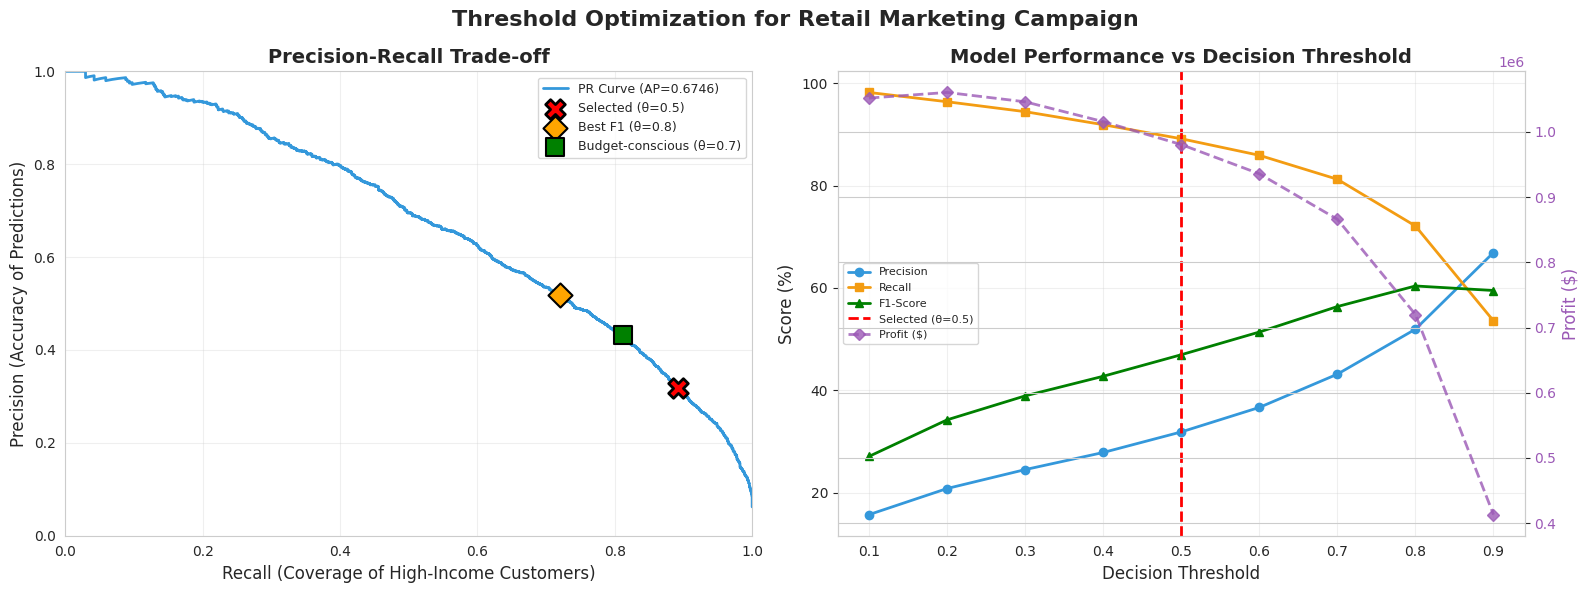

  ✓ Saved: 07_threshold_optimization.png

THRESHOLD OPTIMIZATION COMPLETE


In [28]:
# ============================================================================
# STEP 10.6: PRECISION-RECALL CURVE VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("STEP 10.6: PRECISION-RECALL CURVE VISUALIZATION")
print("="*80)

# Calculate precision-recall curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, final_proba)
avg_precision = average_precision_score(y_test, final_proba)


# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# ---- Plot 1: Precision-Recall Curve ----
axes[0].plot(recall_vals, precision_vals, color='#3498db', linewidth=2,
             label=f'PR Curve (AP={avg_precision:.4f})')


# Default / Selected point (θ=optimal_threshold)
axes[0].scatter([final_metrics['recall']], [final_metrics['precision']],
                color='red', s=200, marker='X', zorder=5,
                label=f'Selected (θ={optimal_threshold})', edgecolors='black', linewidths=2)


# Best F1 point
if best_f1_threshold != optimal_threshold:
    f1_row = threshold_df.loc[best_f1_idx]
    axes[0].scatter([f1_row['recall']], [f1_row['precision']],
                    color='orange', s=150, marker='D', zorder=5,
                    label=f'Best F1 (θ={best_f1_threshold})', edgecolors='black', linewidths=1.5)


# Budget-conscious point (θ=0.7)
row_07 = threshold_df[threshold_df['threshold'] == 0.7].iloc[0]
axes[0].scatter([row_07['recall']], [row_07['precision']],
                color='green', s=150, marker='s', zorder=5,
                label='Budget-conscious (θ=0.7)', edgecolors='black', linewidths=1.5)


axes[0].set_xlabel('Recall (Coverage of High-Income Customers)', fontsize=12)
axes[0].set_ylabel('Precision (Accuracy of Predictions)', fontsize=12)
axes[0].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])


# ---- Plot 2: Metrics vs Threshold ----
ax2_left = axes[1]
ax2_right = ax2_left.twinx()


ax2_left.plot(threshold_df['threshold'], threshold_df['precision']*100,
              marker='o', label='Precision', linewidth=2, color='#3498db')
ax2_left.plot(threshold_df['threshold'], threshold_df['recall']*100,
              marker='s', label='Recall', linewidth=2, color='#f39c12')
ax2_left.plot(threshold_df['threshold'], threshold_df['f1']*100,
              marker='^', label='F1-Score', linewidth=2, color='green')


ax2_right.plot(threshold_df['threshold'], threshold_df['profit'],
               marker='D', label='Profit ($)', linewidth=2, color='#9b59b6',
               linestyle='--', alpha=0.8)


ax2_left.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2,
                 label=f'Selected (θ={optimal_threshold})')


ax2_left.set_xlabel('Decision Threshold', fontsize=12)
ax2_left.set_ylabel('Score (%)', fontsize=12)
ax2_right.set_ylabel('Profit ($)', fontsize=12, color='#9b59b6')
ax2_right.tick_params(axis='y', labelcolor='#9b59b6')


axes[1].set_title('Model Performance vs Decision Threshold', fontsize=14, fontweight='bold')


lines1, labels1 = ax2_left.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2_left.legend(lines1 + lines2, labels1 + labels2, loc='center left', fontsize=8)
ax2_left.grid(alpha=0.3)


plt.suptitle('Threshold Optimization for Retail Marketing Campaign', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/07_threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"  ✓ Saved: 07_threshold_optimization.png")


print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION COMPLETE")
print("="*80)

In [29]:
# ============================================================================
# STEP 11: DETAILED MODEL EVALUATION
# ============================================================================
print("\n" + "="*80)
print("STEP 11: DETAILED MODEL EVALUATION")
print("="*80)


# ============================================================================
# 11.1 Confusion Matrix Analysis
# ============================================================================
print("\n11.1 Confusion Matrix Analysis:")
cm = confusion_matrix(y_test, final_pred)


print(f"\n                 Predicted")
print(f"                 ≤$50k      >$50k")
print(f"  Actual ≤$50k   {cm[0,0]:5d}     {cm[0,1]:5d}")
print(f"         >$50k   {cm[1,0]:5d}     {cm[1,1]:5d}")


tn, fp, fn, tp = cm.ravel()


print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn:,} - Correctly identified low-income")
print(f"  True Positives (TP):  {tp:,} - Correctly identified high-income")
print(f"  False Positives (FP): {fp:,} - Predicted high but actually low (Type I error)")
print(f"  False Negatives (FN): {fn:,} - Predicted low but actually high (Type II error)")


print(f"\nBusiness Impact:")
print(f"  ✓ Correctly targeted high-income: {tp:,} customers")
print(f"  ⚠ Missed high-income opportunities: {fn:,} customers ({fn/(tp+fn)*100:.1f}% of high-income)")
print(f"  ⚠ Wasted marketing to low-income: {fp:,} customers ({fp/(tn+fp)*100:.1f}% of low-income)")


STEP 11: DETAILED MODEL EVALUATION

11.1 Confusion Matrix Analysis:

                 Predicted
                 ≤$50k      >$50k
  Actual ≤$50k   32709      4720
         >$50k     269      2207

Confusion Matrix Breakdown:
  True Negatives (TN):  32,709 - Correctly identified low-income
  True Positives (TP):  2,207 - Correctly identified high-income
  False Positives (FP): 4,720 - Predicted high but actually low (Type I error)
  False Negatives (FN): 269 - Predicted low but actually high (Type II error)

Business Impact:
  ✓ Correctly targeted high-income: 2,207 customers
  ⚠ Missed high-income opportunities: 269 customers (10.9% of high-income)
  ⚠ Wasted marketing to low-income: 4,720 customers (12.6% of low-income)


In [30]:
# ============================================================================
# 11.2 CROSS-VALIDATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("11.2 CROSS-VALIDATION ANALYSIS (5-Fold Stratified)")
print("="*80)

print("\n Assessing Model Stability & Generalization...\n")


model_objects = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

pipeline_models = {'Logistic Regression'}

cv_results = {}

for model_name in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:


    print(f"\n{model_name}:")
    print(f"{'-'*60}")


    cv_mean = results_dict[model_name]['cv_mean']
    cv_std = results_dict[model_name]['cv_std']
    test_roc_auc = results_dict[model_name]['roc_auc']


    if 'cv_scores' in results_dict[model_name]:
        cv_scores = results_dict[model_name]['cv_scores']
    else:
        print(f"  (Computing fold-level CV scores...)")
        cv_scores = weighted_cv_score(
            model_objects[model_name], X_train, y_train, w_train, skf,
            is_pipeline=(model_name in pipeline_models)
        )
        results_dict[model_name]['cv_scores'] = cv_scores


    cv_test_diff = abs(cv_mean - test_roc_auc)


    print(f"  Cross-Validation Scores (5 folds):")
    for i, score in enumerate(cv_scores, 1):
        print(f"    Fold {i}: {score:.4f}")


    print(f"\n  Statistical Summary:")
    print(f"    Mean CV ROC-AUC:    {cv_mean:.4f}")
    print(f"    Std Dev:            ±{cv_std:.4f}")
    print(f"    95% Confidence:     [{cv_mean - 1.96*cv_std:.4f}, {cv_mean + 1.96*cv_std:.4f}]")


    print(f"\n  Comparison:")
    print(f"    CV Average:         {cv_mean:.4f}")
    print(f"    Test Set:           {test_roc_auc:.4f}")
    print(f"    Difference:         {cv_test_diff:.4f}")


    print(f"\n  Stability Assessment:")
    if cv_test_diff < 0.02:
        stability = " EXCELLENT - Model generalizes very well"
    elif cv_test_diff < 0.05:
        stability = " GOOD - Model is stable"
    elif cv_test_diff < 0.10:
        stability = " MODERATE - Some variance in performance"
    else:
        stability = " POOR - Potential overfitting detected"


    print(f"    {stability}")


    cv_results[model_name] = {
        'cv_scores': cv_scores,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'test_score': test_roc_auc,
        'difference': cv_test_diff
    }



# Cross-Validation Comparison Summary
print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY - MODEL COMPARISON")
print("="*80)



print(f"\n{'Model':<25} {'CV Mean':<12} {'CV Std':<12} {'Test Score':<12} {'Difference':<12} {'Stability'}")
print(f"{'-'*100}")



for model_name in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:
    cv_res = cv_results[model_name]


    if cv_res['difference'] < 0.02:
        stability_icon = "✅"
    elif cv_res['difference'] < 0.05:
        stability_icon = "✓"
    elif cv_res['difference'] < 0.10:
        stability_icon = "⚠️"
    else:
        stability_icon = "❌"


    print(f"{model_name:<25} {cv_res['cv_mean']:<12.4f} {cv_res['cv_std']:<12.4f} "
          f"{cv_res['test_score']:<12.4f} {cv_res['difference']:<12.4f} {stability_icon}")



most_stable = min(cv_results.items(), key=lambda x: x[1]['difference'])
print(f"\n Most Stable Model: {most_stable[0]} (CV-Test difference: {most_stable[1]['difference']:.4f})")


best_performer = max(cv_results.items(), key=lambda x: x[1]['test_score'])
print(f" Best Test Performance: {best_performer[0]} (Test ROC-AUC: {best_performer[1]['test_score']:.4f})")



print("\n" + "="*80)


11.2 CROSS-VALIDATION ANALYSIS (5-Fold Stratified)

 Assessing Model Stability & Generalization...


Logistic Regression:
------------------------------------------------------------
  Cross-Validation Scores (5 folds):
    Fold 1: 0.9437
    Fold 2: 0.9457
    Fold 3: 0.9437
    Fold 4: 0.9419
    Fold 5: 0.9437

  Statistical Summary:
    Mean CV ROC-AUC:    0.9437
    Std Dev:            ±0.0012
    95% Confidence:     [0.9414, 0.9461]

  Comparison:
    CV Average:         0.9437
    Test Set:           0.9466
    Difference:         0.0029

  Stability Assessment:
     EXCELLENT - Model generalizes very well

Random Forest:
------------------------------------------------------------
  Cross-Validation Scores (5 folds):
    Fold 1: 0.9421
    Fold 2: 0.9428
    Fold 3: 0.9407
    Fold 4: 0.9405
    Fold 5: 0.9420

  Statistical Summary:
    Mean CV ROC-AUC:    0.9416
    Std Dev:            ±0.0009
    95% Confidence:     [0.9399, 0.9433]

  Comparison:
    CV Average:         0.

In [31]:
# ============================================================================
# 11.3 FEATURE IMPORTANCE (Permutation-Based)
# ============================================================================
print("\n" + "="*80)
print("11.3 FEATURE IMPORTANCE (Permutation-Based)")
print("="*80)

print(f"\n Computing permutation importance on test set ({best_model_name})...")
print("   (This measures each feature's contribution to generalization)\n")


perm_result = permutation_importance(
    final_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)


feature_importance_full = pd.DataFrame({
    'feature': all_features,
    'importance': perm_result.importances_mean,
    'std': perm_result.importances_std
}).sort_values('importance', ascending=False)


total_importance = feature_importance_full['importance'].clip(lower=0).sum()


print(f"{'Rank':<6} {'Feature':<40} {'Importance':>12} {'± Std':>10} {'% of Total':>12}")
print(f"{'-'*82}")


for rank, (idx, row) in enumerate(feature_importance_full.head(10).iterrows(), 1):
    pct_total = (max(row['importance'], 0) / total_importance * 100) if total_importance > 0 else 0
    print(f"{rank:<6} {row['feature'][:38]:<40} {row['importance']:>12.6f} {row['std']:>9.6f} {pct_total:>11.2f}%")


top10_sum = feature_importance_full.head(10)['importance'].clip(lower=0).sum()
print(f"\nTop 10 features account for "
      f"{(top10_sum / total_importance * 100):.2f}% of total importance")


11.3 FEATURE IMPORTANCE (Permutation-Based)

 Computing permutation importance on test set (Gradient Boosting)...
   (This measures each feature's contribution to generalization)

Rank   Feature                                    Importance      ± Std   % of Total
----------------------------------------------------------------------------------
1      age                                          0.068033  0.002668       32.96%
2      weeks worked in year                         0.036028  0.001363       17.45%
3      education_level                              0.035523  0.001428       17.21%
4      sex_encoded                                  0.015827  0.001039        7.67%
5      capital gains                                0.011142  0.000272        5.40%
6      major occupation code_encoded                0.007799  0.000392        3.78%
7      tax filer stat_encoded                       0.007032  0.000371        3.41%
8      dividends from stocks                        0.005171  0


11.4 MODEL PERFORMANCE VISUALIZATIONS

 Creating ROC Curve Comparison...


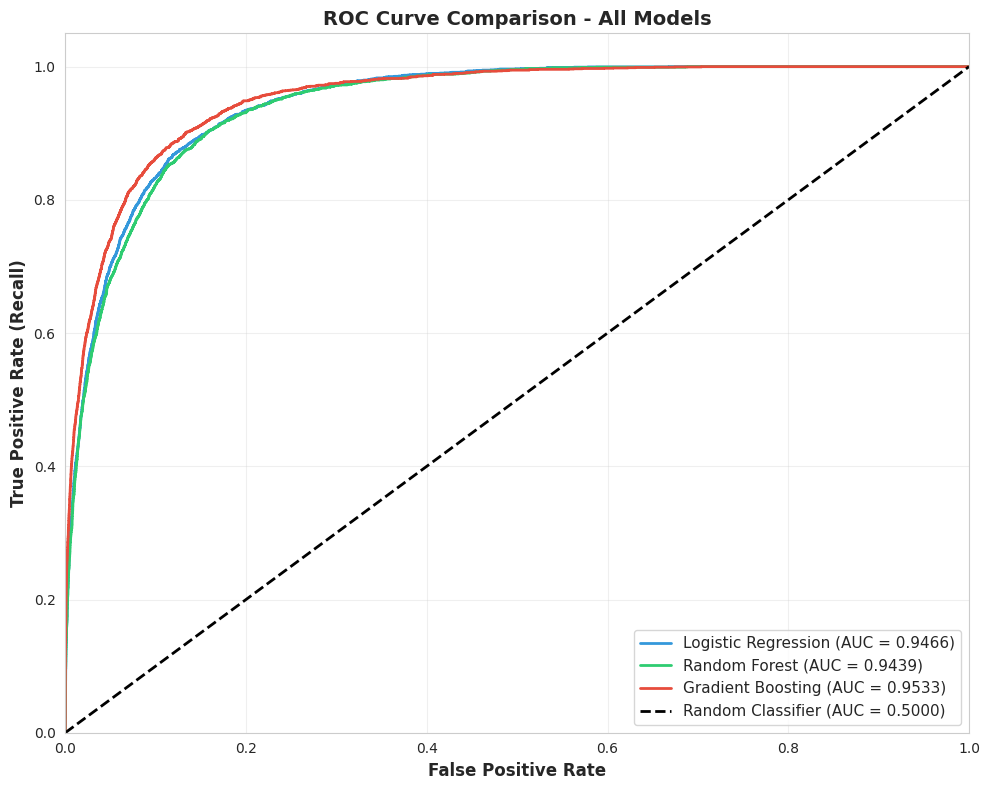

✓ Saved and displayed: 10a_roc_curves_comparison.png

 Creating Feature Importance Chart...


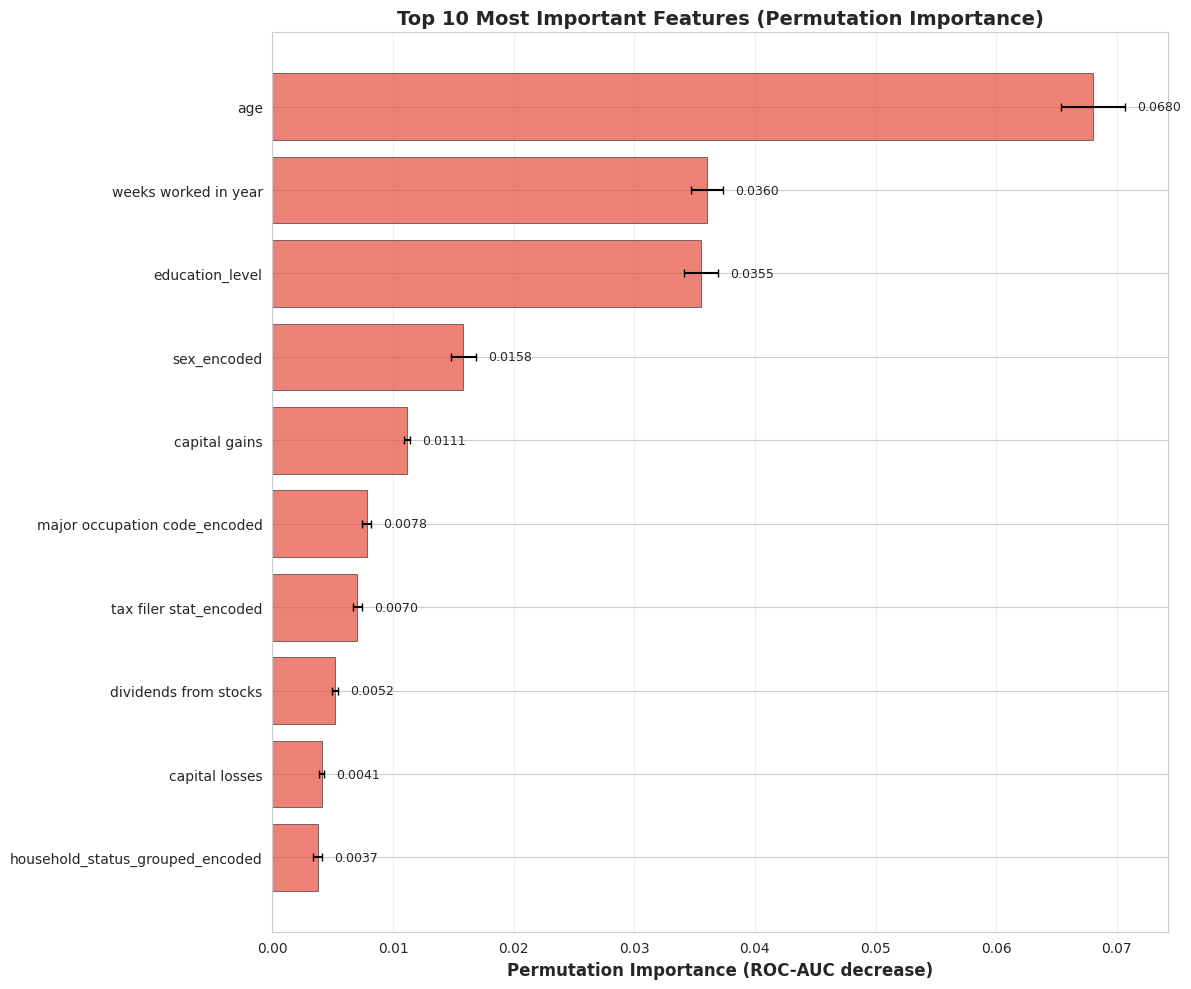

✓ Saved and displayed: 10b_feature_importance.png

 Creating Confusion Matrix Heatmaps...


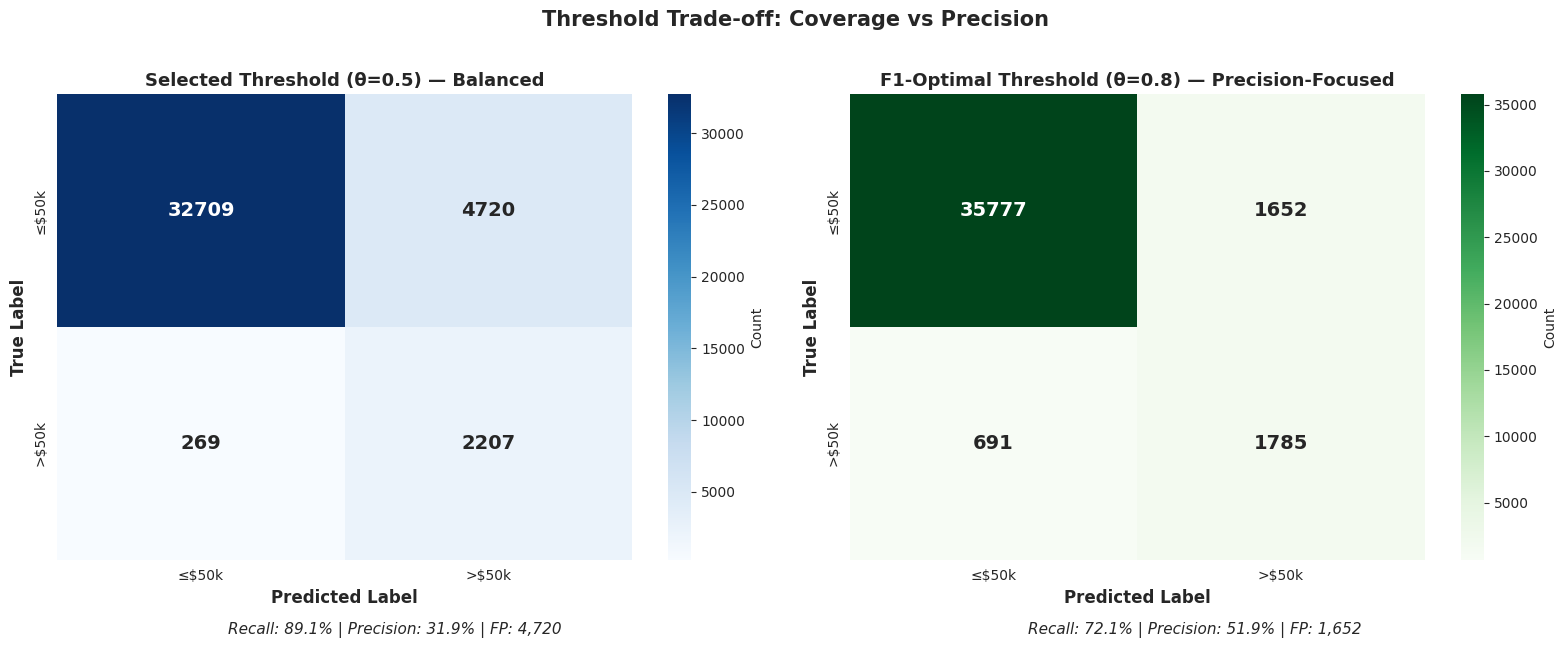

✓ Saved and displayed: 10c_confusion_matrices.png

 Creating Model Comparison Charts...


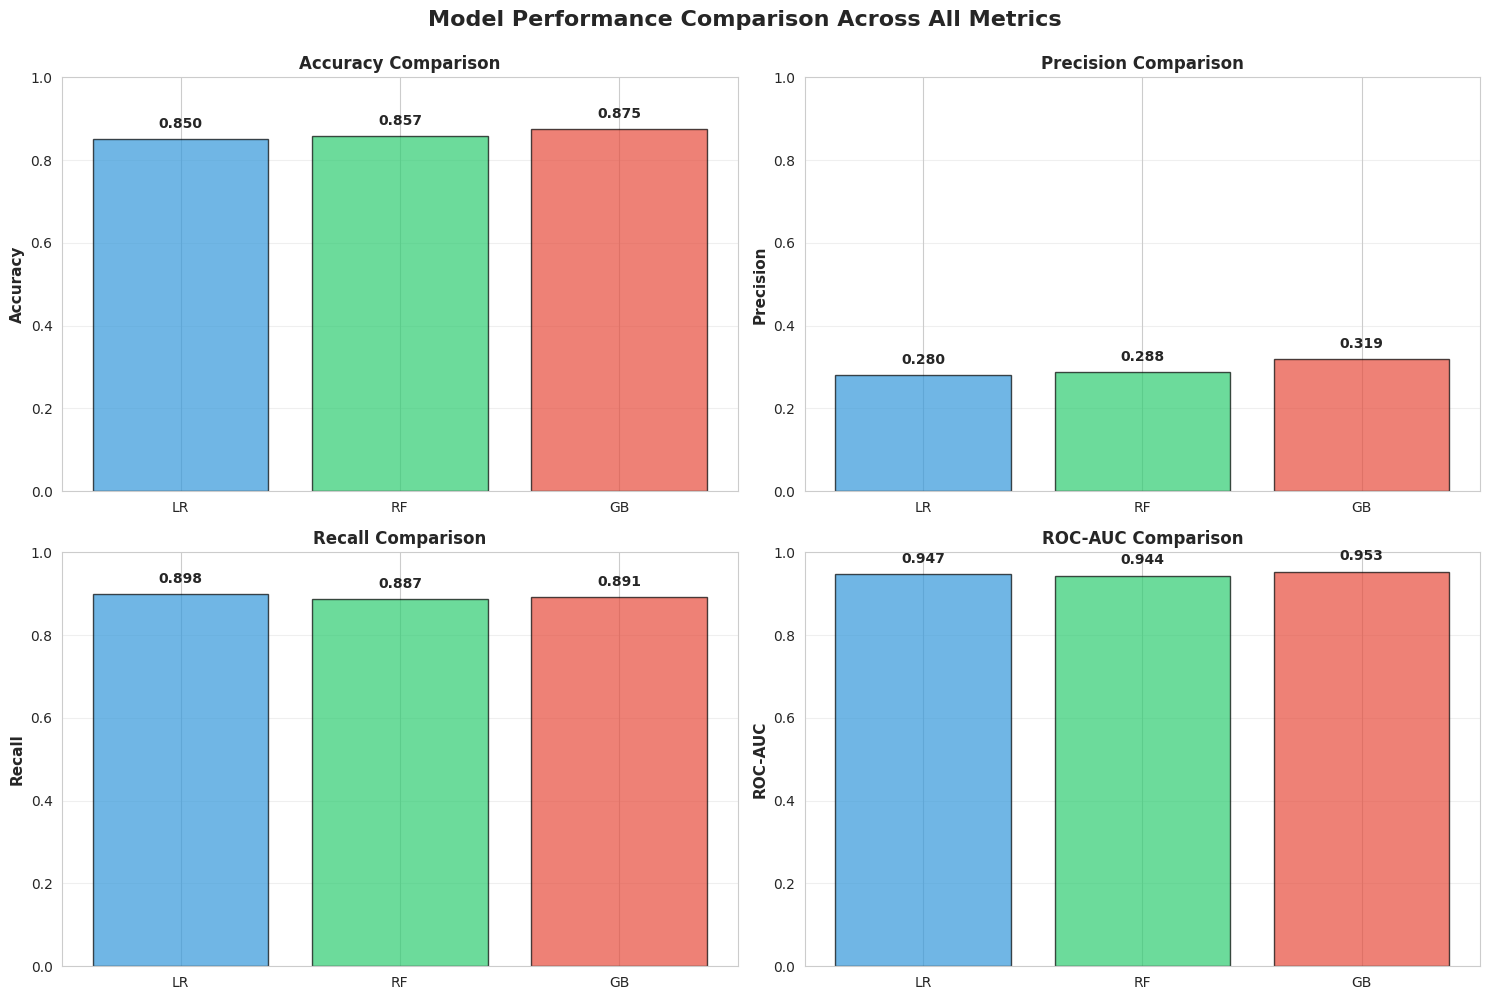

✓ Saved and displayed: 10d_model_comparison.png

 All 4 model evaluation visualizations complete!


In [32]:
# ============================================================================
# 11.4 MODEL PERFORMANCE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("11.4 MODEL PERFORMANCE VISUALIZATIONS")
print("="*80)


# --- Visualization 1: ROC Curves ---
print("\n Creating ROC Curve Comparison...")
fig, ax = plt.subplots(figsize=(10, 8))


models_to_plot = [
    ('Logistic Regression', lr_proba),
    ('Random Forest', rf_proba),
    ('Gradient Boosting', gb_proba)
]


colors = ['#3498db', '#2ecc71', '#e74c3c']
for idx, (name, proba) in enumerate(models_to_plot):
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, color=colors[idx], lw=2,
            label=f'{name} (AUC = {roc_auc:.4f})')


ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])


plt.tight_layout()
plt.savefig(f"{output_dir}/10a_roc_curves_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved and displayed: 10a_roc_curves_comparison.png")


# --- Visualization 2: Feature Importance ---
print("\n Creating Feature Importance Chart...")
fig, ax = plt.subplots(figsize=(12, 10))


top10 = feature_importance_full.head(10).iloc[::-1]


ax.barh(range(len(top10)), top10['importance'],
        xerr=top10['std'], color='#e74c3c', alpha=0.7,
        edgecolor='black', linewidth=0.5, capsize=3)
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['feature'])
ax.set_xlabel('Permutation Importance (ROC-AUC decrease)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Important Features (Permutation Importance)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(top10.iterrows()):
    ax.text(row['importance'] + row['std'] + 0.001, i,
            f"{row['importance']:.4f}", va='center', fontsize=9)


plt.tight_layout()
plt.savefig(f"{output_dir}/10b_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved and displayed: 10b_feature_importance.png")


# --- Visualization 3: Confusion Matrix Heatmaps ---
print("\n Creating Confusion Matrix Heatmaps...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


cm_selected = confusion_matrix(y_test, final_pred)
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title(f'Selected Threshold (θ={optimal_threshold}) — Balanced', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['≤$50k', '>$50k'])
axes[0].set_yticklabels(['≤$50k', '>$50k'])


f1_optimal_pred = (final_proba >= best_f1_threshold).astype(int)
cm_f1_optimal = confusion_matrix(y_test, f1_optimal_pred)
sns.heatmap(cm_f1_optimal, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title(f'F1-Optimal Threshold (θ={best_f1_threshold}) — Precision-Focused', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(['≤$50k', '>$50k'])
axes[1].set_yticklabels(['≤$50k', '>$50k'])


tn_s, fp_s, fn_s, tp_s = cm_selected.ravel()
tn_f, fp_f, fn_f, tp_f = cm_f1_optimal.ravel()
fig.text(0.25, -0.02,
         f'Recall: {tp_s/(tp_s+fn_s)*100:.1f}% | Precision: {tp_s/(tp_s+fp_s)*100:.1f}% | FP: {fp_s:,}',
         ha='center', fontsize=11, style='italic')
fig.text(0.75, -0.02,
         f'Recall: {tp_f/(tp_f+fn_f)*100:.1f}% | Precision: {tp_f/(tp_f+fp_f)*100:.1f}% | FP: {fp_f:,}',
         ha='center', fontsize=11, style='italic')


plt.suptitle('Threshold Trade-off: Coverage vs Precision', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{output_dir}/10c_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved and displayed: 10c_confusion_matrices.png")


# --- Visualization 4: Model Comparison Bar Charts ---
print("\n Creating Model Comparison Charts...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison Across All Metrics', fontsize=16, fontweight='bold', y=0.995)


metrics = ['accuracy', 'precision', 'recall', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']


for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    row = idx // 2
    col = idx % 2

    values = [results_dict[model][metric] for model in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']]
    colors_bar = ['#3498db', '#2ecc71', '#e74c3c']

    bars = axes[row, col].bar(['LR', 'RF', 'GB'], values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1)
    axes[row, col].set_ylabel(metric_name, fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'{metric_name} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_ylim([0, 1])
    axes[row, col].grid(axis='y', alpha=0.3)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                            f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')


plt.tight_layout()
plt.savefig(f"{output_dir}/10d_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved and displayed: 10d_model_comparison.png")


print("\n All 4 model evaluation visualizations complete!")

In [33]:
# ============================================================================
# 11.5 Classification Report
# ============================================================================
print("\n" + "="*80)
print("11.5 DETAILED CLASSIFICATION REPORT")
print("="*80)


print(classification_report(y_test, final_pred,
                          target_names=['≤$50k', '>$50k'],
                          digits=4))


11.5 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       ≤$50k     0.9918    0.8739    0.9291     37429
       >$50k     0.3186    0.8914    0.4694      2476

    accuracy                         0.8750     39905
   macro avg     0.6552    0.8826    0.6993     39905
weighted avg     0.9501    0.8750    0.9006     39905



In [34]:
# ============================================================================
# 11.6 Business Insights from Feature Importance
# ============================================================================
print("\n" + "="*80)
print("11.6 KEY BUSINESS INSIGHTS FROM FEATURE IMPORTANCE")
print("="*80)


top_5 = feature_importance_full.head(5)
print(f"\n Top 5 Predictive Factors for High Income (>$50k):\n")


for idx, (_, row) in enumerate(top_5.iterrows(), 1):
    feat_name = row['feature']
    importance = row['importance']

    if 'education' in feat_name.lower():
        insight = "Education is the strongest predictor — target degree holders"
        recommendation = "Focus campaigns on professionals with Bachelor's degree or higher"
    elif 'capital' in feat_name.lower() or 'dividend' in feat_name.lower():
        insight = "Investment income strongly indicates high earners"
        recommendation = "Offer wealth management services to those with investment portfolios"
    elif 'age' in feat_name.lower():
        insight = "Age/experience correlates with earning potential"
        recommendation = "Target mid-career professionals (35-55 years old)"
    elif 'work' in feat_name.lower() or 'weeks' in feat_name.lower():
        insight = "Work consistency is a key income indicator"
        recommendation = "Focus on full-time, year-round employed individuals"
    elif 'occupation' in feat_name.lower():
        insight = "Occupation type differentiates income levels"
        recommendation = "Prioritize executive, professional, and technical occupations"
    elif 'household' in feat_name.lower():
        insight = "Household status (householder vs dependent) matters"
        recommendation = "Target householders and primary earners, not dependents"
    elif 'marital' in feat_name.lower():
        insight = "Marital status affects earning patterns"
        recommendation = "Married individuals often have dual-income potential"
    elif 'sex' in feat_name.lower() or 'gender' in feat_name.lower():
        insight = "Gender correlates with income disparities in this dataset"
        recommendation = "Consider gender-aware marketing for product positioning"
    elif 'class of worker' in feat_name.lower() or 'worker' in feat_name.lower():
        insight = "Employment type (private/govt/self-employed) predicts income"
        recommendation = "Target self-employed professionals and government workers"
    elif 'foreign' in feat_name.lower() or 'citizenship' in feat_name.lower():
        insight = "Immigration/citizenship status affects income patterns"
        recommendation = "Include country of origin in customer profiling"
    elif 'industry' in feat_name.lower():
        insight = "Industry sector is a strong income differentiator"
        recommendation = "Prioritize customers in finance, tech, and professional services"
    else:
        insight = "Significant demographic factor for income prediction"
        recommendation = "Include in customer profiling for targeting"


    pct = (max(importance, 0) / total_importance * 100) if total_importance > 0 else 0
    print(f"  {idx}. {feat_name[:35]:<35}")
    print(f"     Importance: {importance:.4f} ± {row['std']:.4f} ({pct:.2f}%)")
    print(f"     Insight: {insight}")
    print(f"     Action: {recommendation}\n")


print("="*80)
print("MODEL EVALUATION COMPLETE")
print("="*80)


11.6 KEY BUSINESS INSIGHTS FROM FEATURE IMPORTANCE

 Top 5 Predictive Factors for High Income (>$50k):

  1. age                                
     Importance: 0.0680 ± 0.0027 (32.96%)
     Insight: Age/experience correlates with earning potential
     Action: Target mid-career professionals (35-55 years old)

  2. weeks worked in year               
     Importance: 0.0360 ± 0.0014 (17.45%)
     Insight: Work consistency is a key income indicator
     Action: Focus on full-time, year-round employed individuals

  3. education_level                    
     Importance: 0.0355 ± 0.0014 (17.21%)
     Insight: Education is the strongest predictor — target degree holders
     Action: Focus campaigns on professionals with Bachelor's degree or higher

  4. sex_encoded                        
     Importance: 0.0158 ± 0.0010 (7.67%)
     Insight: Gender correlates with income disparities in this dataset
     Action: Consider gender-aware marketing for product positioning

  5. capital gain

# Task 2: Customer Segmentation

## Objective

Your retail client is interested in developing a **segmentation model** of the people represented in this dataset for marketing purposes.

## Approach

Using your preferred machine learning or data science techniques:

1. **Build a segmentation model** that groups individuals in the dataset into distinct segments.
2. **Demonstrate how the resulting groups differ** from one another across key demographic and employment variables.
3. **Provide actionable recommendations** on how the retail client can leverage these segments for targeted marketing.

## Goal

Create a segmentation model and clearly illustrate:

- The **distinguishing characteristics** of each segment
- How the retail client can **use this model** to inform marketing strategy

In [35]:
# ============================================================================
# STEP 11.7: FILTERING DATA FOR VIABLE MARKETING TARGETS
# ============================================================================
print("\n" + "=" * 80)
print("STEP 11.7: FILTERING DATA FOR VIABLE MARKETING TARGETS")
print("=" * 80)

print("""
  BUSINESS LOGIC:
  Marketing products requires viable customers who can make purchasing decisions.
  We exclude ONLY those who cannot reasonably be marketing targets:
    Children under 18 years (cannot make financial decisions)
    Non-working individuals with zero employment activity
    Child dependents (not independent decision-makers)

  IMPORTANT: We do NOT exclude part-time/seasonal workers because:
    Part-time workers are still valid marketing targets
    They purchase retail products and financial services
    Work intensity is a SEGMENTATION variable, not a filter
    Excluding them would lose 18.9% of viable customers
    The assessment asks to segment "people represented in this dataset"
""")

print(f"  Starting Dataset: {len(df_processed):,} total records")

df_segmentation = df_processed.copy()

# Filter 1 - Adults Only (age >= 18)
before_age = len(df_segmentation)
df_segmentation = df_segmentation[df_segmentation['age'] >= 18].copy()
removed_age = before_age - len(df_segmentation)
print(f"\n  Filter 1 - Adults Only (age >= 18):")
print(f"    Removed: {removed_age:,} children ({removed_age/before_age*100:.1f}%)")
print(f"    Remaining: {len(df_segmentation):,} adults")

# Filter 2 - In Labor Force (any work activity)
before_work = len(df_segmentation)
work_mask = (
    (df_segmentation['weeks worked in year'] > 0) |    # Worked at least 1 week
    (df_segmentation['class of worker'] != 'Not_Applicable') |  # Has employment status
    (df_segmentation['major occupation code'] != 'Not_Applicable')  # Has occupation
)
df_segmentation = df_segmentation[work_mask].copy()
removed_work = before_work - len(df_segmentation)
print(f"\n  Filter 2 - In Labor Force:")
print(f"    Removed: {removed_work:,} non-working individuals ({removed_work/before_work*100:.1f}%)")
print(f"    Remaining: {len(df_segmentation):,} working adults")

# Filter 3 - Independent Adults (not child dependents)
before_depend = len(df_segmentation)
df_segmentation = df_segmentation[
    df_segmentation['household_status_grouped'] != 'Child_Dependent'
].copy()
removed_depend = before_depend - len(df_segmentation)
print(f"\n  Filter 3 - Independent Adults:")
print(f"    Removed: {removed_depend:,} adult dependents ({removed_depend/before_depend*100:.1f}%)")
print(f"    Remaining: {len(df_segmentation):,} viable customers")

# *** NO Filter 4 - We intentionally keep part-time/seasonal workers ***
print(f"\n  ℹPart-time/seasonal workers RETAINED as marketing targets")
print(f"    Part-time workers in dataset: {(df_segmentation['weeks worked in year'] < 40).sum():,}")
print(f"    Full-time workers in dataset: {(df_segmentation['weeks worked in year'] >= 40).sum():,}")

# Summary
total_removed = len(df_processed) - len(df_segmentation)
pct_retained = len(df_segmentation) / len(df_processed) * 100

print(f"\n  {'Metric':<30} {'Count':>15} {'Percentage':>12}")
print(f"  {'-'*59}")
print(f"  {'Original dataset':<30} {len(df_processed):>15,} {'100.0':>12}")
print(f"  {'Removed (non-viable)':<30} {total_removed:>15,} {f'{100-pct_retained:.1f}':>12}")
print(f"  {'Retained (viable targets)':<30} {len(df_segmentation):>15,} {f'{pct_retained:.1f}':>12}")

# Income distribution check
original_income_rate = df_processed['target'].mean() * 100
filtered_income_rate = df_segmentation['target'].mean() * 100
income_lift = filtered_income_rate / original_income_rate

print(f"\n  Income Distribution Impact:")
print(f"    Original data high-income rate: {original_income_rate:.2f}%")
print(f"    Filtered data high-income rate: {filtered_income_rate:.2f}%")
print(f"    Concentration lift: {income_lift:.2f}x")

print(f"\n  Age Distribution After Filtering:")
print(f"    Min age: {df_segmentation['age'].min():.0f}")
print(f"    Max age: {df_segmentation['age'].max():.0f}")
print(f"    Mean age: {df_segmentation['age'].mean():.1f}")
print(f"    Median age: {df_segmentation['age'].median():.1f}")

print(f"\n READY FOR SEGMENTATION")
print(f"  All {len(df_segmentation):,} customers are viable marketing targets")
print("=" * 80)


STEP 11.7: FILTERING DATA FOR VIABLE MARKETING TARGETS

  BUSINESS LOGIC:
  Marketing products requires viable customers who can make purchasing decisions.
  We exclude ONLY those who cannot reasonably be marketing targets:
    Children under 18 years (cannot make financial decisions)
    Non-working individuals with zero employment activity
    Child dependents (not independent decision-makers)

  IMPORTANT: We do NOT exclude part-time/seasonal workers because:
    Part-time workers are still valid marketing targets
    They purchase retail products and financial services
    Work intensity is a SEGMENTATION variable, not a filter
    Excluding them would lose 18.9% of viable customers
    The assessment asks to segment "people represented in this dataset"

  Starting Dataset: 199,523 total records

  Filter 1 - Adults Only (age >= 18):
    Removed: 55,992 children (28.1%)
    Remaining: 143,531 adults

  Filter 2 - In Labor Force:
    Removed: 39,779 non-working individuals (27.7%)


In [36]:
# ============================================================================
# STEP 12: CUSTOMER SEGMENTATION FOR MARKETING
# ============================================================================
print("\n" + "=" * 80)
print("STEP 12: CUSTOMER SEGMENTATION FOR MARKETING")
print("=" * 80)
print("Objective: Create meaningful customer segments for targeted campaigns")


# 12.1 Select Features for Segmentation
print("\n12.1 Selecting Features for Segmentation:")


segmentation_features = [
    'age', 'education_level', 'capital gains', 'capital losses',
    'dividends from stocks', 'weeks worked in year',
    'has_capital_gains', 'is_foreign_born',
    'household_status_grouped_encoded', 'sex_encoded',
    'marital stat_encoded', 'class of worker_encoded',
    'major occupation code_encoded'
]


# Verify all features exist
segmentation_features = [f for f in segmentation_features if f in df_segmentation.columns]
X_segment = df_segmentation[segmentation_features].copy()


print(f"  Selected {len(segmentation_features)} features:")
print(f"  {'Category':<20} {'Features'}")
print(f"  {'-'*60}")
print(f"  {'Demographics':<20} age, education, marital status, sex")
print(f"  {'Financial':<20} capital gains/losses, dividends")
print(f"  {'Employment':<20} work weeks, occupation, worker class")
print(f"  {'Household':<20} household status, foreign-born")
print(f"\n 'is_full_year_worker' excluded (r=0.899 with 'weeks worked in year')")


# 12.2 Standardize
print(f"\n12.2 Standardizing Features...")
scaler = StandardScaler()
X_segment_scaled = scaler.fit_transform(X_segment)
print(f"  Features scaled to mean=0, std=1")
print(f"  Scaled data shape: {X_segment_scaled.shape}")


STEP 12: CUSTOMER SEGMENTATION FOR MARKETING
Objective: Create meaningful customer segments for targeted campaigns

12.1 Selecting Features for Segmentation:
  Selected 13 features:
  Category             Features
  ------------------------------------------------------------
  Demographics         age, education, marital status, sex
  Financial            capital gains/losses, dividends
  Employment           work weeks, occupation, worker class
  Household            household status, foreign-born

 'is_full_year_worker' excluded (r=0.899 with 'weeks worked in year')

12.2 Standardizing Features...
  Features scaled to mean=0, std=1
  Scaled data shape: (92601, 13)



12.3 PCA Variance Analysis:
  Purpose: Understand data dimensionality before clustering and visualization

  Explained Variance by Component:
    PC1:  14.46%  cumulative:  14.46%  ██████████████
    PC2:  10.79%  cumulative:  25.25%  ██████████
    PC3:   9.67%  cumulative:  34.92%  █████████
    PC4:   8.57%  cumulative:  43.48%  ████████
    PC5:   7.96%  cumulative:  51.44%  ███████
    PC6:   7.68%  cumulative:  59.12%  ███████
    PC7:   7.55%  cumulative:  66.67%  ███████
    PC8:   7.16%  cumulative:  73.83%  ███████
    PC9:   6.73%  cumulative:  80.56%  ██████
    PC10:   6.35%  cumulative:  86.91%  ██████

  Components Needed:
    50% variance: 5 components
    70% variance: 8 components
    80% variance: 9 components
    90% variance: 11 components

 EIGENVALUE STRUCTURE ANALYSIS:
  ────────────────────────────────────────────────────────────
  Ratio of largest to smallest eigenvalue: 3.91
  PC1 explains 14.5%, PC13 explains 3.7%

  Moderate eigenvalue concentration (ratio

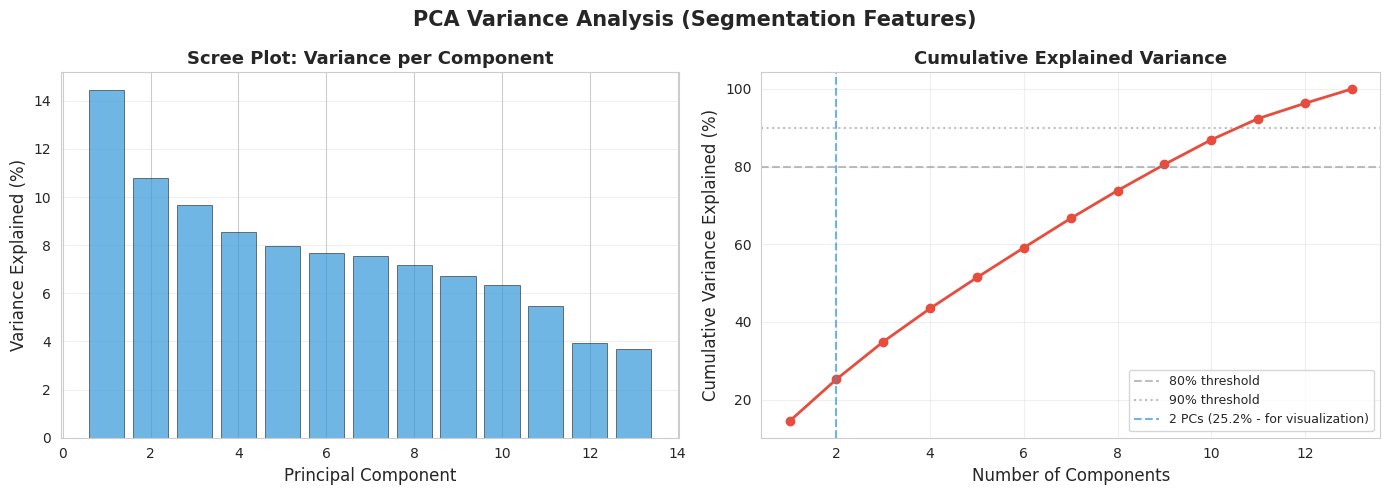

  Saved 11_pca_variance_analysis.png


In [37]:
# ============================================================================
# STEP 12.3: PCA VARIANCE ANALYSIS
# ============================================================================
print(f"\n12.3 PCA Variance Analysis:")
print(f"  Purpose: Understand data dimensionality before clustering and visualization\n")


pca_full = PCA(random_state=42)
pca_full.fit(X_segment_scaled)


cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)


n_for_50 = np.argmax(cumulative_var >= 0.50) + 1
n_for_70 = np.argmax(cumulative_var >= 0.70) + 1
n_for_80 = np.argmax(cumulative_var >= 0.80) + 1
n_for_90 = np.argmax(cumulative_var >= 0.90) + 1


print(f"  Explained Variance by Component:")
for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    bar = "█" * int(pca_full.explained_variance_ratio_[i] * 100)
    print(f"    PC{i+1}: {pca_full.explained_variance_ratio_[i]*100:6.2f}%  cumulative: {cumulative_var[i]*100:6.2f}%  {bar}")


print(f"\n  Components Needed:")
print(f"    50% variance: {n_for_50} components")
print(f"    70% variance: {n_for_70} components")
print(f"    80% variance: {n_for_80} components")
print(f"    90% variance: {n_for_90} components")

# Eigenvalue flatness analysis
eigenvalue_ratio = pca_full.explained_variance_ratio_[0] / pca_full.explained_variance_ratio_[-1]

print(f"\n EIGENVALUE STRUCTURE ANALYSIS:")
print(f"  {'─'*60}")
print(f"  Ratio of largest to smallest eigenvalue: {eigenvalue_ratio:.2f}")
print(f"  PC1 explains {pca_full.explained_variance_ratio_[0]*100:.1f}%, "
      f"PC13 explains {pca_full.explained_variance_ratio_[-1]*100:.1f}%")
print(f"")
if eigenvalue_ratio < 3.0:
    print(f"  FINDING: FLAT eigenvalue spectrum (ratio < 3.0)")
    print(f"  Variance is spread nearly uniformly across all {X_segment_scaled.shape[1]} components.")
    print(f"  This means NO small subset of components dominates the data.")
    print(f"  → Low cumulative variance in 2D ({cumulative_var[1]*100:.1f}%) is expected")
    print(f"    and NOT an indicator of poor analysis.")
else:
    print(f"  Moderate eigenvalue concentration (ratio {eigenvalue_ratio:.1f})")

print(f"""
  PCA USAGE DECISION — WHY 2 COMPONENTS:
  ─────────────────────────────────────────────────────────
  1. PURPOSE: PCA is used ONLY for 2D scatter visualization
     Clustering is performed on ALL {X_segment_scaled.shape[1]} original features

  2. WHY NOT MORE COMPONENTS?
     • 3D scatter plots are harder to interpret in a static report
     • With a flat eigenvalue spectrum, adding PC3 (+{pca_full.explained_variance_ratio_[2]*100:.1f}%)
       provides marginal visual improvement while reducing clarity
     • The 2D plot shows relative cluster positions, not exact boundaries

  3. WHY NOT t-SNE / UMAP?
     • t-SNE/UMAP distort distances — clusters that appear separated
       may actually overlap, creating false confidence in cluster quality
     • PCA preserves global structure and distances proportionally
     • For business stakeholders, PCA is more interpretable
     • Our weak silhouette scores (< 0.25) are honest about overlap;
       t-SNE might hide this fact by artificially pulling clusters apart

  4. THE SCATTER PLOT CAVEAT:
     • 2 PCs capture ~{cumulative_var[1]*100:.1f}% of variance — {100-cumulative_var[1]*100:.1f}% is lost
     • Clusters that overlap in 2D may be better separated in 13D
     • The silhouette score (computed in full 13D) is the true
       measure of cluster quality, not the visual scatter plot
  ─────────────────────────────────────────────────────────
""")


# Plot PCA Variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_ * 100,
            color='#3498db', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained (%)', fontsize=12)
axes[0].set_title('Scree Plot: Variance per Component', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)


axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var * 100,
             'o-', color='#e74c3c', linewidth=2, markersize=6)
axes[1].axhline(y=80, color='gray', linestyle='--', alpha=0.5, label='80% threshold')
axes[1].axhline(y=90, color='gray', linestyle=':', alpha=0.5, label='90% threshold')
axes[1].axvline(x=2, color='#3498db', linestyle='--', alpha=0.7,
                label=f'2 PCs ({cumulative_var[1]*100:.1f}% - for visualization)')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)


plt.suptitle('PCA Variance Analysis (Segmentation Features)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{output_dir}/11_pca_variance_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"  Saved 11_pca_variance_analysis.png")

In [38]:
# ============================================================================
# STEP 12.4: DETERMINING OPTIMAL NUMBER OF SEGMENTS
# ============================================================================
print(f"\n12.4 Determining Optimal Number of Segments...")


inertias = []
silhouette_scores_list = []
K_range = range(2, 11)


print(f"  Testing K from {min(K_range)} to {max(K_range)} segments...")
print(f"  (Analyzing ~{len(df_segmentation):,} customers...)\n")


print(f"  {'K':<5} {'Inertia':<18} {'Silhouette':<15} {'Quality'}")
print(f"  {'-'*60}")


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_segment_scaled)
    inertia = kmeans.inertia_


    sample_size = min(10000, len(X_segment_scaled))
    silhouette = silhouette_score(X_segment_scaled, cluster_labels, sample_size=sample_size)
    inertias.append(inertia)
    silhouette_scores_list.append(silhouette)


    if silhouette > 0.5:
        quality = "Strong"
    elif silhouette > 0.3:
        quality = "Moderate"
    elif silhouette > 0.2:
        quality = "Fair"
    else:
        quality = "Weak"


    print(f"  {k:<5} {inertia:<18,.0f} {silhouette:<15.4f} {quality}")


12.4 Determining Optimal Number of Segments...
  Testing K from 2 to 10 segments...
  (Analyzing ~92,601 customers...)

  K     Inertia            Silhouette      Quality
  ------------------------------------------------------------
  2     1,080,187          0.1338          Weak
  3     968,418            0.1504          Weak
  4     887,005            0.1659          Weak
  5     831,397            0.1704          Weak
  6     747,803            0.1939          Weak
  7     691,825            0.1983          Weak
  8     636,626            0.1992          Weak
  9     584,459            0.2034          Fair
  10    557,059            0.1877          Weak


In [46]:
# ============================================================================
# STEP 12.5: ELBOW & SILHOUETTE ANALYSIS
# ============================================================================
print(f"\n12.5 Elbow & Silhouette Analysis:")


K_list = list(K_range)


# Elbow analysis - percentage improvement
print(f"\n  Elbow Analysis (% Improvement in Inertia):")
improvements = []
for i in range(1, len(inertias)):
    improvement = (inertias[i-1] - inertias[i]) / inertias[i-1] * 100
    improvements.append(improvement)
    k_val = K_list[i]
    print(f"    K={k_val}: {improvement:.2f}% improvement over K={k_val-1}")

ELBOW_THRESHOLD = 7.0  # % improvement below which we consider diminishing returns

print(f"\n  Elbow Detection (diminishing returns with rebound check):")
print(f"  Threshold: improvement < {ELBOW_THRESHOLD}% indicates potential elbow")
print(f"  Rule: Only declare elbow if the NEXT K also stays below threshold")
print(f"         (i.e., the drop is sustained, not a temporary dip)\n")

elbow_k = None

for i in range(len(improvements)):
    from_k = K_list[i]
    to_k = K_list[i + 1]
    imp = improvements[i]

    if imp < ELBOW_THRESHOLD:
        # Check: does the NEXT K rebound above the threshold?
        if i + 1 < len(improvements) and improvements[i + 1] >= ELBOW_THRESHOLD:
            print(f"    K={from_k}→K={to_k}: {imp:.2f}% < {ELBOW_THRESHOLD}%, "
                  f"but K={to_k}→K={K_list[i+2]}: {improvements[i+1]:.2f}% REBOUNDS "
                  f"— NOT a true elbow (temporary dip)")
        else:
            # Sustained drop — this is the real elbow
            elbow_k = to_k
            if i + 1 < len(improvements):
                print(f"    K={from_k}→K={to_k}: {imp:.2f}% < {ELBOW_THRESHOLD}%, "
                      f"and K={to_k}→K={K_list[i+2]}: {improvements[i+1]:.2f}% stays low "
                      f"— SUSTAINED DROP → Elbow at K={to_k}")
            else:
                print(f"    K={from_k}→K={to_k}: {imp:.2f}% < {ELBOW_THRESHOLD}% "
                      f"(last K tested) — Elbow at K={to_k}")
            break
    else:
        print(f"    K={from_k}→K={to_k}: {imp:.2f}% ≥ {ELBOW_THRESHOLD}% — still improving significantly")

# Fallback if no elbow found (all improvements stay above threshold)
if elbow_k is None:
    elbow_k = K_list[len(K_list) // 2]
    print(f"\n    No clear elbow detected — all K values show ≥{ELBOW_THRESHOLD}% improvement")
    print(f"    Defaulting to midpoint K={elbow_k}")


print(f"\n  Elbow point: K = {elbow_k}")


# Boundary warning: if elbow landed at the last K tested, it's not a true elbow
if elbow_k == max(K_range):
    print(f"\n Elbow detected at K={elbow_k} (upper boundary of test range).")
    print(f"    This indicates no clear elbow exists within K={min(K_range)}–{max(K_range)}.")
    print(f"    The multi-criteria scoring below will determine optimal K based on")
    print(f"    silhouette quality × business actionability instead.")


# Find best silhouette K
best_silhouette_idx = np.argmax(silhouette_scores_list)
best_silhouette_k = K_list[best_silhouette_idx]
best_silhouette_val = silhouette_scores_list[best_silhouette_idx]

print(f"  Best silhouette score at K = {best_silhouette_k} ({best_silhouette_val:.4f})")


# ============================================================================
# CRITICAL DISCUSSION: Cluster Quality Assessment
# ============================================================================
print(f"\n  CLUSTER QUALITY ASSESSMENT:")
print(f"  {'─'*60}")


max_sil = max(silhouette_scores_list)
print(f"  All silhouette scores fall in range [{min(silhouette_scores_list):.3f}, {max_sil:.3f}]")
print(f"  This indicates WEAK cluster structure in the data.")
print(f"")
print(f"  Silhouette Score Interpretation:")
print(f"    > 0.50  Strong structure (well-separated clusters)")
print(f"    > 0.25  Fair structure (reasonable clusters)")
print(f"    < 0.25  Weak structure (overlapping / no natural clusters)  ← Our data")
print(f"")
print(f"  WHY: Census demographic data forms continuous distributions,")
print(f"  not discrete spherical clusters that K-Means assumes. This is")
print(f"  common with real-world population data.")
print(f"")
print(f"  IMPLICATION: Our segments represent business-imposed groupings")
print(f"  for marketing purposes, not naturally distinct populations.")
print(f"  This is acceptable — most real-world marketing segmentation")
print(f"  divides a continuum into actionable groups.")
print(f"  {'─'*60}")


12.5 Elbow & Silhouette Analysis:

  Elbow Analysis (% Improvement in Inertia):
    K=3: 10.35% improvement over K=2
    K=4: 8.41% improvement over K=3
    K=5: 6.27% improvement over K=4
    K=6: 10.05% improvement over K=5
    K=7: 7.49% improvement over K=6
    K=8: 7.98% improvement over K=7
    K=9: 8.19% improvement over K=8
    K=10: 4.69% improvement over K=9

  Elbow Detection (diminishing returns with rebound check):
  Threshold: improvement < 7.0% indicates potential elbow
  Rule: Only declare elbow if the NEXT K also stays below threshold
         (i.e., the drop is sustained, not a temporary dip)

    K=2→K=3: 10.35% ≥ 7.0% — still improving significantly
    K=3→K=4: 8.41% ≥ 7.0% — still improving significantly
    K=4→K=5: 6.27% < 7.0%, but K=5→K=6: 10.05% REBOUNDS — NOT a true elbow (temporary dip)
    K=5→K=6: 10.05% ≥ 7.0% — still improving significantly
    K=6→K=7: 7.49% ≥ 7.0% — still improving significantly
    K=7→K=8: 7.98% ≥ 7.0% — still improving significant

In [40]:
# ============================================================================
# STEP 12.6: BUSINESS DECISION - SELECTING OPTIMAL K
# ============================================================================
print(f"\n12.6 Business Decision - Selecting Optimal K:\n")


# Multi-criteria scoring approach (transparent, no hidden caps)
print(f"  Multi-Criteria Evaluation:")
print(f"  {'K':<5} {'Silhouette':>12} {'Inertia Drop':>14} {'Actionable?':>14} {'Score':>8}")
print(f"  {'─'*58}")


candidate_scores = {}
for i, k in enumerate(K_range):
    sil = silhouette_scores_list[i]


    if k <= 3:
        actionability = 0.5
        action_label = "Too coarse"
    elif k <= 6:
        actionability = 1.0
        action_label = "Ideal"
    else:
        actionability = 0.6
        action_label = "Complex"


    score = sil * actionability
    candidate_scores[k] = score


    imp_str = f"{improvements[i-1]:.2f}%" if i > 0 else "-"
    print(f"  {k:<5} {sil:>12.4f} {imp_str:>14} {action_label:>13} {score:>8.4f}")


optimal_k = max(candidate_scores, key=candidate_scores.get)


print(f"\n  Selected K = {optimal_k} segments")
print(f"\n  Justification:")

# --- Statistical Evidence (fully dynamic) ---
print(f"    • Statistical Evidence:")

# 1. Acknowledge best silhouette honestly
print(f"      - Best silhouette: K={best_silhouette_k} ({best_silhouette_val:.4f})")

# 2. Find all K values with HIGHER silhouette than selected K
silhouette_for_selected = silhouette_scores_list[K_list.index(optimal_k)]
better_k_values = [
    (K_list[i], silhouette_scores_list[i])
    for i in range(len(K_list))
    if silhouette_scores_list[i] > silhouette_for_selected and K_list[i] != optimal_k
]

if better_k_values:
    better_k_str = ", ".join([f"K={k} ({s:.3f})" for k, s in better_k_values])
    print(f"      - Higher silhouette exists at: {better_k_str}")
    print(f"        However, these fall outside the actionable range (K=4–6)")
    print(f"        where campaigns remain manageable for execution teams")

# 3. Show selected K is best WITHIN actionable range
actionable_range = [(K_list[i], silhouette_scores_list[i])
                    for i in range(len(K_list))
                    if 4 <= K_list[i] <= 6]
if actionable_range:
    actionable_str = ", ".join([f"K={k}: {s:.4f}" for k, s in actionable_range])
    print(f"      - Within actionable range (K=4–6): {actionable_str}")
    best_actionable_k = max(actionable_range, key=lambda x: x[1])
    if best_actionable_k[0] == optimal_k:
        print(f"      - K={optimal_k} is the best within this range")

# 4. Compare with neighbors
if optimal_k > min(K_range):
    prev_sil = silhouette_scores_list[K_list.index(optimal_k - 1)]
    print(f"      - vs K={optimal_k-1}: {prev_sil:.4f} (Δ = {silhouette_for_selected - prev_sil:+.4f})")
if optimal_k < max(K_range):
    next_sil = silhouette_scores_list[K_list.index(optimal_k + 1)]
    print(f"      - vs K={optimal_k+1}: {next_sil:.4f} (Δ = {silhouette_for_selected - next_sil:+.4f})")

# 5. Weakness acknowledgment (dynamic based on actual scores)
max_sil = max(silhouette_scores_list)
if max_sil < 0.25:
    print(f"      - All silhouette scores are weak (<0.25), so no K is")
    print(f"        statistically superior — business practicality drives the choice")
elif max_sil < 0.50:
    print(f"      - Silhouette scores are fair (best: {max_sil:.3f}), suggesting")
    print(f"        moderate cluster structure — K={optimal_k} balances quality and practicality")

# --- Business Considerations ---
print(f"    • Business Considerations:")
print(f"      - {optimal_k} segments are manageable for campaign execution")
print(f"      - Enough granularity for differentiated marketing strategies")
print(f"      - Each segment can receive distinct messaging and offers")


12.6 Business Decision - Selecting Optimal K:

  Multi-Criteria Evaluation:
  K       Silhouette   Inertia Drop    Actionable?    Score
  ──────────────────────────────────────────────────────────
  2           0.1338              -    Too coarse   0.0669
  3           0.1504         10.35%    Too coarse   0.0752
  4           0.1659          8.41%         Ideal   0.1659
  5           0.1704          6.27%         Ideal   0.1704
  6           0.1939         10.05%         Ideal   0.1939
  7           0.1983          7.49%       Complex   0.1190
  8           0.1992          7.98%       Complex   0.1195
  9           0.2034          8.19%       Complex   0.1221
  10          0.1877          4.69%       Complex   0.1126

  Selected K = 6 segments

  Justification:
    • Statistical Evidence:
      - Best silhouette: K=9 (0.2034)
      - Higher silhouette exists at: K=7 (0.198), K=8 (0.199), K=9 (0.203)
        However, these fall outside the actionable range (K=4–6)
        where campai

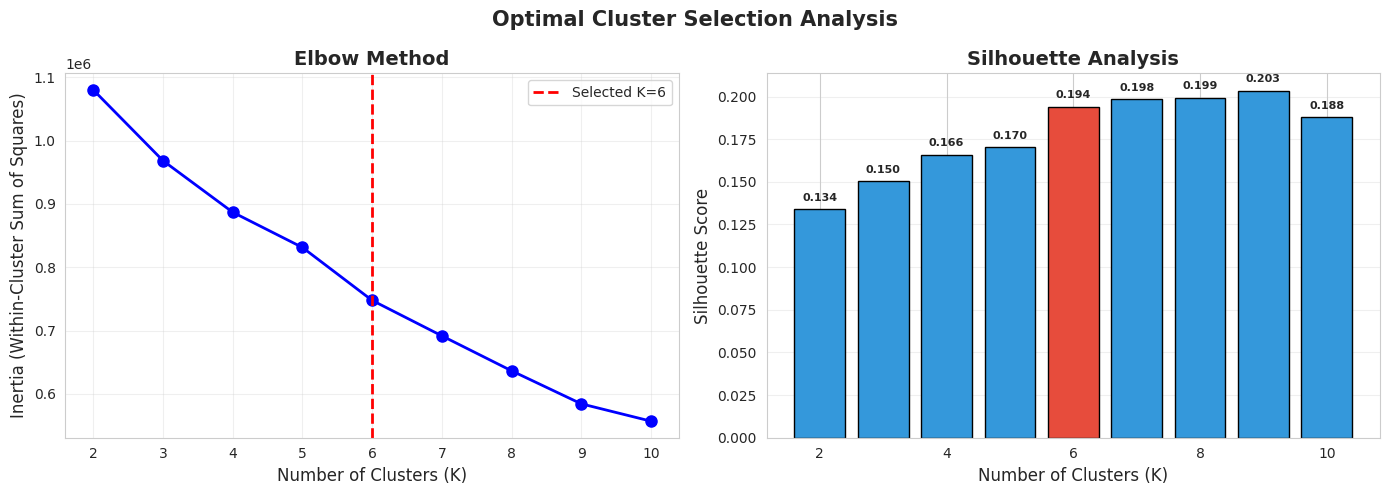

  Saved 11b_elbow_silhouette.png


In [41]:
# ============================================================================
# STEP 12.7: ELBOW & SILHOUETTE VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].plot(K_list, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Selected K={optimal_k}')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)


colors_sil = ['#e74c3c' if k == optimal_k else '#3498db' for k in K_range]
axes[1].bar(K_list, silhouette_scores_list, color=colors_sil,
            edgecolor='black', linewidth=1)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, (k, score) in enumerate(zip(K_range, silhouette_scores_list)):
    axes[1].text(k, score + 0.005, f'{score:.3f}', ha='center', fontsize=8, fontweight='bold')


plt.suptitle('Optimal Cluster Selection Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{output_dir}/11b_elbow_silhouette.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"  Saved 11b_elbow_silhouette.png")

In [42]:
# ============================================================================
# STEP 12.8: BUILD FINAL K-MEANS MODEL WITH VALIDATION
# ============================================================================
print(f"\n12.8 Building Final K-Means Model (K={optimal_k})...")


kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
df_segmentation['segment'] = kmeans_final.fit_predict(X_segment_scaled)


print(f"  Segmentation complete!")
print(f"  Model converged in {kmeans_final.n_iter_} iterations")
print(f"  Final inertia: {kmeans_final.inertia_:,.0f}")


# Segment distribution
print(f"\n12.9 Segment Distribution & Validation:")
segment_counts = df_segmentation['segment'].value_counts().sort_index()
print(f"  {'Segment':<12} {'Count':>12} {'Percentage':>12}   Visual")
print(f"  {'-'*70}")
for seg_id, count in segment_counts.items():
    pct = count / len(df_segmentation) * 100
    bar = "█" * int(pct / 2)
    print(f"  Segment {seg_id:<4} {count:>12,} {pct:>11.1f}%   {bar}")


min_segment_pct = segment_counts.min() / len(df_segmentation) * 100
max_segment_pct = segment_counts.max() / len(df_segmentation) * 100
min_segment_count = segment_counts.min()


print(f"\n  Balance Check:")
print(f"    Smallest segment: {min_segment_pct:.1f}% ({min_segment_count:,} customers)")
print(f"    Largest segment: {max_segment_pct:.1f}%")


MIN_SEGMENT_PCT = 2.0
if min_segment_pct < MIN_SEGMENT_PCT:
    print(f"\n  Segment size validation FAILED:")
    print(f"    Smallest segment ({min_segment_pct:.1f}%) < {MIN_SEGMENT_PCT}% minimum")
    print(f"    Trying K={optimal_k - 1} for better-balanced segments...\n")

    optimal_k = optimal_k - 1
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
    df_segmentation['segment'] = kmeans_final.fit_predict(X_segment_scaled)

    print(f"  ✓ Re-segmented with K={optimal_k}")
    print(f"  ✓ Model converged in {kmeans_final.n_iter_} iterations")
    print(f"  ✓ Final inertia: {kmeans_final.inertia_:,.0f}")

    segment_counts = df_segmentation['segment'].value_counts().sort_index()
    print(f"\n  Updated Segment Distribution (K={optimal_k}):")
    print(f"  {'Segment':<12} {'Count':>12} {'Percentage':>12}   Visual")
    print(f"  {'-'*70}")
    for seg_id, count in segment_counts.items():
        pct = count / len(df_segmentation) * 100
        bar = "█" * int(pct / 2)
        print(f"  Segment {seg_id:<4} {count:>12,} {pct:>11.1f}%   {bar}")

    min_segment_pct = segment_counts.min() / len(df_segmentation) * 100
    max_segment_pct = segment_counts.max() / len(df_segmentation) * 100

    if min_segment_pct < MIN_SEGMENT_PCT:
        print(f"\n  Smallest segment still {min_segment_pct:.1f}%.")
        print(f"    Accepting: small segments can represent high-value niche groups.")
    else:
        print(f"\n  All segments now ≥ {MIN_SEGMENT_PCT}% — viable for marketing")

else:
    print(f"  All segments ≥ {MIN_SEGMENT_PCT}% — viable for marketing campaigns")


final_silhouette = silhouette_score(
    X_segment_scaled,
    df_segmentation['segment'],
    sample_size=min(10000, len(X_segment_scaled)),
    random_state=42
)
print(f"\n  Final Model Quality:")
print(f"    K = {optimal_k}")
print(f"    Silhouette Score: {final_silhouette:.4f}")
print(f"    Inertia: {kmeans_final.inertia_:,.0f}")
print(f"    Total customers segmented: {len(df_segmentation):,}")


12.8 Building Final K-Means Model (K=6)...
  Segmentation complete!
  Model converged in 20 iterations
  Final inertia: 747,803

12.9 Segment Distribution & Validation:
  Segment             Count   Percentage   Visual
  ----------------------------------------------------------------------
  Segment 0          27,215        29.4%   ██████████████
  Segment 1           3,032         3.3%   █
  Segment 2          31,397        33.9%   ████████████████
  Segment 3           5,739         6.2%   ███
  Segment 4           9,200         9.9%   ████
  Segment 5          16,018        17.3%   ████████

  Balance Check:
    Smallest segment: 3.3% (3,032 customers)
    Largest segment: 33.9%
  All segments ≥ 2.0% — viable for marketing campaigns

  Final Model Quality:
    K = 6
    Silhouette Score: 0.1890
    Inertia: 747,803
    Total customers segmented: 92,601


In [47]:
# ============================================================================
# STEP 13: COMPREHENSIVE SEGMENT PROFILING
# ============================================================================
print("\n" + "=" * 80)
print("STEP 13: COMPREHENSIVE SEGMENT PROFILING")
print("=" * 80)


segment_profiles = []
overall_avg = df_segmentation['target'].mean() * 100


for segment_id in range(optimal_k):
    segment_data = df_segmentation[df_segmentation['segment'] == segment_id]
    segment_size = len(segment_data)
    segment_pct = segment_size / len(df_segmentation) * 100


    print(f"\n{'='*80}")
    print(f"SEGMENT {segment_id} | Size: {segment_size:,} ({segment_pct:.1f}%)")
    print(f"{'='*80}")


    # ── DEMOGRAPHICS ──────────────────────────────────────────────────────
    print(f"\n DEMOGRAPHICS:")
    avg_age = segment_data['age'].mean()
    median_age = segment_data['age'].median()
    print(f"  Age:")
    print(f"    • Average: {avg_age:.1f} years")
    print(f"    • Median: {median_age:.1f} years")
    print(f"    • Range: {segment_data['age'].min():.0f}-{segment_data['age'].max():.0f} years")


    if avg_age < 30:
        age_group = "Young Professionals (20s)"
    elif avg_age < 40:
        age_group = "Early Career (30s)"
    elif avg_age < 50:
        age_group = "Mid-Career (40s)"
    elif avg_age < 60:
        age_group = "Established Professionals (50s)"
    else:
        age_group = "Late Career / Pre-Retirement (60+)"
    print(f"    • Classification: {age_group}")


    avg_edu = segment_data['education_level'].mean()
    print(f"\n  Education:")
    print(f"    • Average Level: {avg_edu:.1f} / 16")
    if avg_edu >= 13:
        edu_desc = "College Graduate (Bachelor's+)"
    elif avg_edu >= 10:
        edu_desc = "High School / Some College"
    elif avg_edu >= 7:
        edu_desc = "Some High School"
    else:
        edu_desc = "Below High School"
    print(f"    • Description: {edu_desc}")


    top_edu = segment_data['education'].value_counts().head(2)
    for edu_name, edu_count in top_edu.items():
        print(f"    • {edu_name}: {edu_count/segment_size*100:.1f}%")


    male_pct_val = 0
    if 'sex_encoded' in segment_data.columns:
        male_pct_val = (segment_data['sex'].str.strip() == 'Male').mean() * 100
        print(f"\n  Gender: Male {male_pct_val:.1f}%, Female {100 - male_pct_val:.1f}%")


    top_marital = segment_data['marital stat'].value_counts().iloc[0]
    top_marital_name = segment_data['marital stat'].value_counts().index[0]
    never_married_pct = (segment_data['marital stat'].str.strip() == 'Never married').mean() * 100
    print(f"  Marital Status: {top_marital_name.strip()} {top_marital/segment_size*100:.1f}%")


    top_household = segment_data['household_status_grouped'].value_counts().index[0]
    top_household_pct = segment_data['household_status_grouped'].value_counts().iloc[0] / segment_size * 100
    spouse_pct = (segment_data['household_status_grouped'] == 'Spouse').mean() * 100
    print(f"  Household Type: {top_household} {top_household_pct:.1f}%")


    foreign_pct = segment_data['is_foreign_born'].mean() * 100
    print(f"  Foreign-Born: {foreign_pct:.1f}%")


    # ── EMPLOYMENT PROFILE ────────────────────────────────────────────────
    print(f"\n EMPLOYMENT PROFILE:")
    avg_weeks = segment_data['weeks worked in year'].mean()
    full_year_pct = (segment_data['weeks worked in year'] >= 50).mean() * 100
    print(f"  Work Intensity:")
    print(f"    • Average weeks/year: {avg_weeks:.1f}")
    print(f"    • Full-year workers (≥50 weeks): {full_year_pct:.1f}%")


    if full_year_pct > 80:
        work_pattern = "Stable Full-Time Employment"
    elif full_year_pct > 50:
        work_pattern = "Mostly Full-Time"
    elif avg_weeks > 20:
        work_pattern = "Mixed Full/Part-Time"
    else:
        work_pattern = "Part-Time / Seasonal"
    print(f"    • Pattern: {work_pattern}")


    top_class = segment_data['class of worker'].value_counts()
    top_class = top_class[top_class.index != 'Not_Applicable']
    if len(top_class) > 0:
        print(f"  Worker Class: {top_class.index[0].strip()} {top_class.iloc[0]/segment_size*100:.1f}%")


    top_occ = segment_data['major occupation code'].value_counts()
    top_occ = top_occ[top_occ.index != 'Not_Applicable']
    if len(top_occ) > 0:
        top_occ_name = top_occ.index[0].strip()
        print(f"  Primary Occupation: {top_occ_name} {top_occ.iloc[0]/segment_size*100:.1f}%")
    else:
        top_occ_name = "Various"


    # ── FINANCIAL PROFILE ─────────────────────────────────────────────────
    print(f"\n FINANCIAL PROFILE:")
    avg_cap_gains = segment_data['capital gains'].mean()
    has_cap_gains_pct = (segment_data['capital gains'] > 0).mean() * 100
    print(f"  Capital Gains:")
    print(f"    • Average: ${avg_cap_gains:,.0f}")
    print(f"    • % with gains: {has_cap_gains_pct:.1f}%")


    avg_dividends = segment_data['dividends from stocks'].mean()
    has_dividends_pct = (segment_data['dividends from stocks'] > 0).mean() * 100
    print(f"  Dividends:")
    print(f"    • Average: ${avg_dividends:,.0f}")
    print(f"    • % receiving dividends: {has_dividends_pct:.1f}%")


    has_investments_pct = (
        (segment_data['capital gains'] > 0) |
        (segment_data['dividends from stocks'] > 0)
    ).mean() * 100
    print(f"  Investment Participation: {has_investments_pct:.1f}%")


    if has_investments_pct > 30:
        investment_profile = "Active Investors"
    elif has_investments_pct > 10:
        investment_profile = "Emerging Investors"
    else:
        investment_profile = "Non-Investors / Savings Focused"
    print(f"  Investment Profile: {investment_profile}")


    # ── INCOME LEVEL ──────────────────────────────────────────────────────
    high_income_count = (segment_data['target'] == 1).sum()
    high_income_pct = (segment_data['target'] == 1).mean() * 100
    low_income_count = segment_size - high_income_count
    lift = high_income_pct / overall_avg if overall_avg > 0 else 0


    print(f"\n INCOME LEVEL (TARGET METRIC):")
    print(f"  High Income (>$50k): {high_income_pct:.2f}% ({high_income_count:,} customers)")
    print(f"  Low Income (≤$50k):  {100-high_income_pct:.2f}% ({low_income_count:,} customers)")
    print(f"  vs Overall Average ({overall_avg:.2f}%): {lift:.2f}x")


    # ── CLASSIFICATION ────────────────────────────────────────────────────
    if high_income_pct > 25:
        income_tier = "PREMIUM"
        tier = "TIER 1 - HIGHEST PRIORITY"
    elif high_income_pct > 15:
        income_tier = "UPPER-MIDDLE"
        tier = "TIER 2 - HIGH PRIORITY"
    elif high_income_pct > 8:
        income_tier = "MIDDLE"
        tier = "TIER 3 - MODERATE PRIORITY"
    else:
        income_tier = "VALUE"
        tier = "TIER 4 - CAREFUL TARGETING"


    if foreign_pct > 80:
        demo_trait = "Immigrant Workforce"
    elif spouse_pct > 70:
        demo_trait = "Domestic Partners"
    elif never_married_pct > 50:
        demo_trait = "Young Singles"
    elif has_investments_pct > 80:
        demo_trait = "Affluent Investors"
    elif high_income_pct > 25 and avg_edu >= 11:
        demo_trait = "High-Earning Professionals"
    elif male_pct_val > 70 and full_year_pct > 75:
        demo_trait = "Working Breadwinners"
    else:
        demo_trait = "Mixed Demographics"


    seg_class = f"{income_tier}: {demo_trait}"


    print(f"\n SEGMENT NAME: {seg_class}")
    print(f"  Priority: {tier}")


    # ── MARKETING RECOMMENDATIONS ─────────────────────────────────────────
    print(f"\n MARKETING RECOMMENDATIONS:")


    if has_investments_pct > 80:
        print(f"  Persona: {demo_trait} — high net worth, investment-active")
        print(f"  Strategy: WEALTH MANAGEMENT / VIP")
        print(f"  Products: Portfolio advisory, premium credit cards, tax-advantaged accounts")
        print(f"  Channels: Personalized direct mail, private banker outreach, exclusive events")
        print(f"  Budget Allocation: HIGH (25-35%)")
        conversion_rate = 0.05; cost_per_contact = 5; value_per_customer = 2500
    elif high_income_pct > 25:
        print(f"  Persona: {demo_trait} — high earners, untapped investment potential")
        print(f"  Strategy: PREMIUM ACQUISITION / CROSS-SELL")
        print(f"  Products: Investment accounts, premium rewards cards, retirement planning")
        print(f"  Channels: LinkedIn, professional networks, financial planning seminars")
        print(f"  Budget Allocation: HIGH (20-30%)")
        conversion_rate = 0.04; cost_per_contact = 5; value_per_customer = 2000
    elif high_income_pct > 15:
        print(f"  Persona: {demo_trait} — stable income, growth potential")
        print(f"  Strategy: GROWTH / ASPIRATION")
        print(f"  Products: Mid-tier rewards cards, home equity loans, 401k rollover")
        print(f"  Channels: Email marketing, financial education webinars, direct mail")
        print(f"  Budget Allocation: MODERATE-HIGH (20-25%)")
        conversion_rate = 0.03; cost_per_contact = 3; value_per_customer = 1500
    elif foreign_pct > 80:
        print(f"  Persona: {demo_trait} — underbanked, remittance needs, building credit")
        print(f"  Strategy: FINANCIAL INCLUSION / RELATIONSHIP BUILDING")
        print(f"  Products: No-fee checking, remittance services, credit-builder loans, ESL resources")
        print(f"  Channels: Community partnerships, multilingual mobile app, cultural events")
        print(f"  Budget Allocation: MODERATE (10-15%)")
        conversion_rate = 0.015; cost_per_contact = 2; value_per_customer = 600
    elif never_married_pct > 50:
        print(f"  Persona: {demo_trait} — digital-native, career-building, price-sensitive")
        print(f"  Strategy: DIGITAL-FIRST ENGAGEMENT")
        print(f"  Products: Cashback cards, budgeting tools, student loan refinancing, micro-investing")
        print(f"  Channels: Social media (Instagram/TikTok), mobile app, influencer partnerships")
        print(f"  Budget Allocation: LOW-MODERATE (10-15%)")
        conversion_rate = 0.01; cost_per_contact = 1.5; value_per_customer = 500
    elif spouse_pct > 70:
        print(f"  Persona: {demo_trait} — household purchasing decisions, family-oriented")
        print(f"  Strategy: HOUSEHOLD / FAMILY-CENTERED")
        print(f"  Products: Family savings plans, grocery rewards cards, insurance bundles, child education funds")
        print(f"  Channels: Facebook, parenting platforms, direct mail, retail partnerships")
        print(f"  Budget Allocation: MODERATE (10-15%)")
        conversion_rate = 0.015; cost_per_contact = 2; value_per_customer = 500
    else:
        print(f"  Persona: {demo_trait}")
        print(f"  Strategy: BROAD-BASED ENGAGEMENT")
        print(f"  Products: Standard banking products, general rewards cards")
        print(f"  Channels: Multi-channel digital marketing")
        print(f"  Budget Allocation: MODERATE (10-15%)")
        conversion_rate = 0.01; cost_per_contact = 2; value_per_customer = 500


    print(f"\n  ROI ASSUMPTIONS (industry benchmarks for retail financial marketing):")
    print(f"    • Conversion rate: {conversion_rate*100:.1f}% (estimated response-to-sale)")
    print(f"    • Cost per contact: ${cost_per_contact:.2f} (blended channel cost)")
    print(f"    • Lifetime value per conversion: ${value_per_customer:,.0f} (product-dependent)")
    print(f"    • NOTE: Rates are illustrative. Client should validate with historical campaign data.")

    # Step 1: Campaign cost = contact everyone in the segment
    campaign_cost = segment_size * cost_per_contact

    # Step 2: How many high-income people are in this segment?
    high_income_reached = segment_size * (high_income_pct / 100)

    # Step 3: Of the high-income people, how many convert (buy the product)?
    expected_conversions = int(high_income_reached * conversion_rate)

    # Step 4: Revenue and profit
    expected_revenue = expected_conversions * value_per_customer
    net_profit = expected_revenue - campaign_cost
    roi = (net_profit / campaign_cost) * 100 if campaign_cost > 0 else 0


    print(f"\n CAMPAIGN PERFORMANCE PROJECTION:")
    print(f"    Segment size:           {segment_size:>10,}")
    print(f"    High-income in segment: {int(high_income_reached):>10,} ({high_income_pct:.1f}%)")
    print(f"    Expected conversions:   {expected_conversions:>10,} ({conversion_rate*100:.1f}% of high-income)")
    print(f"    Campaign cost:          ${campaign_cost:>10,.0f}")
    print(f"    Expected revenue:       ${expected_revenue:>10,.0f}")
    print(f"    Net profit:             ${net_profit:>10,.0f}")
    print(f"    ROI:                    {roi:>10.0f}%")


    # Warn if blanket marketing to this segment loses money
    if roi < 0:
        print(f"\n  NEGATIVE ROI ({roi:.0f}%): Mass marketing to this segment is not")
        print(f"      profitable. Recommended approach: Use the CLASSIFICATION MODEL to")
        print(f"      identify the {high_income_pct:.1f}% high-income individuals within")
        print(f"      this segment, and target ONLY those predicted high-income customers.")
        print(f"      This converts the segment from blanket-marketing (negative ROI) to")
        print(f"      model-targeted precision marketing (positive ROI).")


    # ── STORE PROFILE ─────────────────────────────────────────────────────
    segment_profiles.append({
        'segment_id': segment_id,
        'size': segment_size,
        'size_pct': segment_pct,
        'avg_age': avg_age,
        'education_level': avg_edu,
        'high_income_pct': high_income_pct,
        'high_income_count': high_income_count,
        'lift': lift,
        'classification': seg_class,
        'demo_trait': demo_trait,
        'tier': tier,
        'roi': roi,
        'expected_conversions': expected_conversions,
        'avg_weeks': avg_weeks,
        'full_year_pct': full_year_pct,
        'has_investments_pct': has_investments_pct,
    })


comparison_df = pd.DataFrame(segment_profiles)
comparison_df = comparison_df.sort_values('segment_id')


# ============================================================================
# CROSS-SEGMENT COMPARISON SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("CROSS-SEGMENT COMPARISON SUMMARY")
print("=" * 80)


print(f"\n  {'Seg':<5} {'Name':<38} {'Size':>8} {'%':>6} {'Income':>8} {'Lift':>6} {'ROI':>8}")
print(f"  {'─'*80}")


for profile in sorted(segment_profiles, key=lambda x: -x['high_income_pct']):
    seg_id = profile['segment_id']
    name_display = profile['classification'][:36]
    print(f"  {seg_id:<5} {name_display:<38} "
          f"{profile['size']:>8,} {profile['size_pct']:>5.1f}% "
          f"{profile['high_income_pct']:>7.1f}% {profile['lift']:>5.2f}x "
          f"{profile['roi']:>7.0f}%")


print(f"\n  KEY DIFFERENTIATORS ACROSS SEGMENTS:")
print(f"  {'─'*70}")


highest_income = max(segment_profiles, key=lambda x: x['high_income_pct'])
lowest_income = min(segment_profiles, key=lambda x: x['high_income_pct'])
highest_roi = max(segment_profiles, key=lambda x: x['roi'])
largest = max(segment_profiles, key=lambda x: x['size'])


print(f"  Highest income concentration: Seg {highest_income['segment_id']} "
      f"({highest_income['high_income_pct']:.1f}% — {highest_income['lift']:.1f}x above average)")
print(f"  Lowest income concentration:  Seg {lowest_income['segment_id']} "
      f"({lowest_income['high_income_pct']:.1f}% — {lowest_income['lift']:.1f}x below average)")
print(f"  Best marketing ROI:           Seg {highest_roi['segment_id']} "
      f"(ROI: {highest_roi['roi']:.0f}%)")
print(f"  Largest addressable market:   Seg {largest['segment_id']} "
      f"({largest['size']:,} customers, {largest['size_pct']:.1f}%)")


print(f"\n  MARKETING PRIORITY MATRIX:")
print(f"  {'─'*70}")


tier1 = [p for p in segment_profiles if 'TIER 1' in p['tier']]
tier2 = [p for p in segment_profiles if 'TIER 2' in p['tier']]
tier34 = [p for p in segment_profiles if 'TIER 3' in p['tier'] or 'TIER 4' in p['tier']]


if tier1:
    t1_customers = sum(p['size'] for p in tier1)
    t1_high = sum(p['high_income_count'] for p in tier1)
    seg_ids = [p['segment_id'] for p in tier1]
    seg_names = [p['demo_trait'] for p in tier1]
    print(f"  TIER 1 (Premium): Segments {seg_ids}")
    for sid, sname in zip(seg_ids, seg_names):
        print(f"     → Seg {sid}: {sname}")
    print(f"     Total: {t1_customers:,} customers containing {t1_high:,} high-income individuals")
    print(f"     → Allocate 45-65% of marketing budget")


if tier2:
    t2_customers = sum(p['size'] for p in tier2)
    t2_high = sum(p['high_income_count'] for p in tier2)
    seg_ids = [p['segment_id'] for p in tier2]
    seg_names = [p['demo_trait'] for p in tier2]
    print(f"  TIER 2 (Growth): Segments {seg_ids}")
    for sid, sname in zip(seg_ids, seg_names):
        print(f"     → Seg {sid}: {sname}")
    print(f"     Total: {t2_customers:,} customers containing {t2_high:,} high-income individuals")
    print(f"     → Allocate 20-30% of marketing budget")


if tier34:
    t34_customers = sum(p['size'] for p in tier34)
    t34_high = sum(p['high_income_count'] for p in tier34)
    seg_ids = [p['segment_id'] for p in tier34]
    seg_names = [p['demo_trait'] for p in tier34]
    print(f"  TIER 3-4 (Nurture): Segments {seg_ids}")
    for sid, sname in zip(seg_ids, seg_names):
        print(f"     → Seg {sid}: {sname}")
    print(f"     Total: {t34_customers:,} customers containing {t34_high:,} high-income individuals")
    print(f"     → Allocate 15-25% of marketing budget (relationship building)")


total_high = sum(p['high_income_count'] for p in segment_profiles)
if tier1:
    tier1_capture = sum(p['high_income_count'] for p in tier1) / total_high * 100
    tier1_pop = sum(p['size'] for p in tier1) / sum(p['size'] for p in segment_profiles) * 100
    print(f"\n  EFFICIENCY: By focusing on Tier 1, the client reaches "
          f"{tier1_capture:.0f}% of all high-income")
    print(f"     customers while targeting only {tier1_pop:.0f}% of the viable population.")


print("\n" + "=" * 80)
print("SEGMENT PROFILING COMPLETE")
print("=" * 80)


STEP 13: COMPREHENSIVE SEGMENT PROFILING

SEGMENT 0 | Size: 27,215 (29.4%)

 DEMOGRAPHICS:
  Age:
    • Average: 41.4 years
    • Median: 40.0 years
    • Range: 18-90 years
    • Classification: Mid-Career (40s)

  Education:
    • Average Level: 10.3 / 16
    • Description: High School / Some College
    • High school graduate: 37.6%
    • Some college but no degree: 19.7%

  Gender: Male 15.4%, Female 84.6%
  Marital Status: Married-civilian spouse present 94.8%
  Household Type: Spouse 95.1%
  Foreign-Born: 0.0%

 EMPLOYMENT PROFILE:
  Work Intensity:
    • Average weeks/year: 43.9
    • Full-year workers (≥50 weeks): 69.2%
    • Pattern: Mostly Full-Time
  Worker Class: Private 62.6%
  Primary Occupation: Adm support including clerical 22.6%

 FINANCIAL PROFILE:
  Capital Gains:
    • Average: $0
    • % with gains: 0.0%
  Dividends:
    • Average: $231
    • % receiving dividends: 17.9%
  Investment Participation: 17.9%
  Investment Profile: Emerging Investors

 INCOME LEVEL (TA


STEP 14: SEGMENTATION VISUALIZATIONS

14.1 Performing PCA for 2D Visualization...
  Explained Variance:
    PC1: 14.46%
    PC2: 10.79%
    Total: 25.25%
    Note: 2D view captures only 25.2% of variance
    Clustering was performed on all 13 features

14.2 Creating detailed PCA scatter plot...


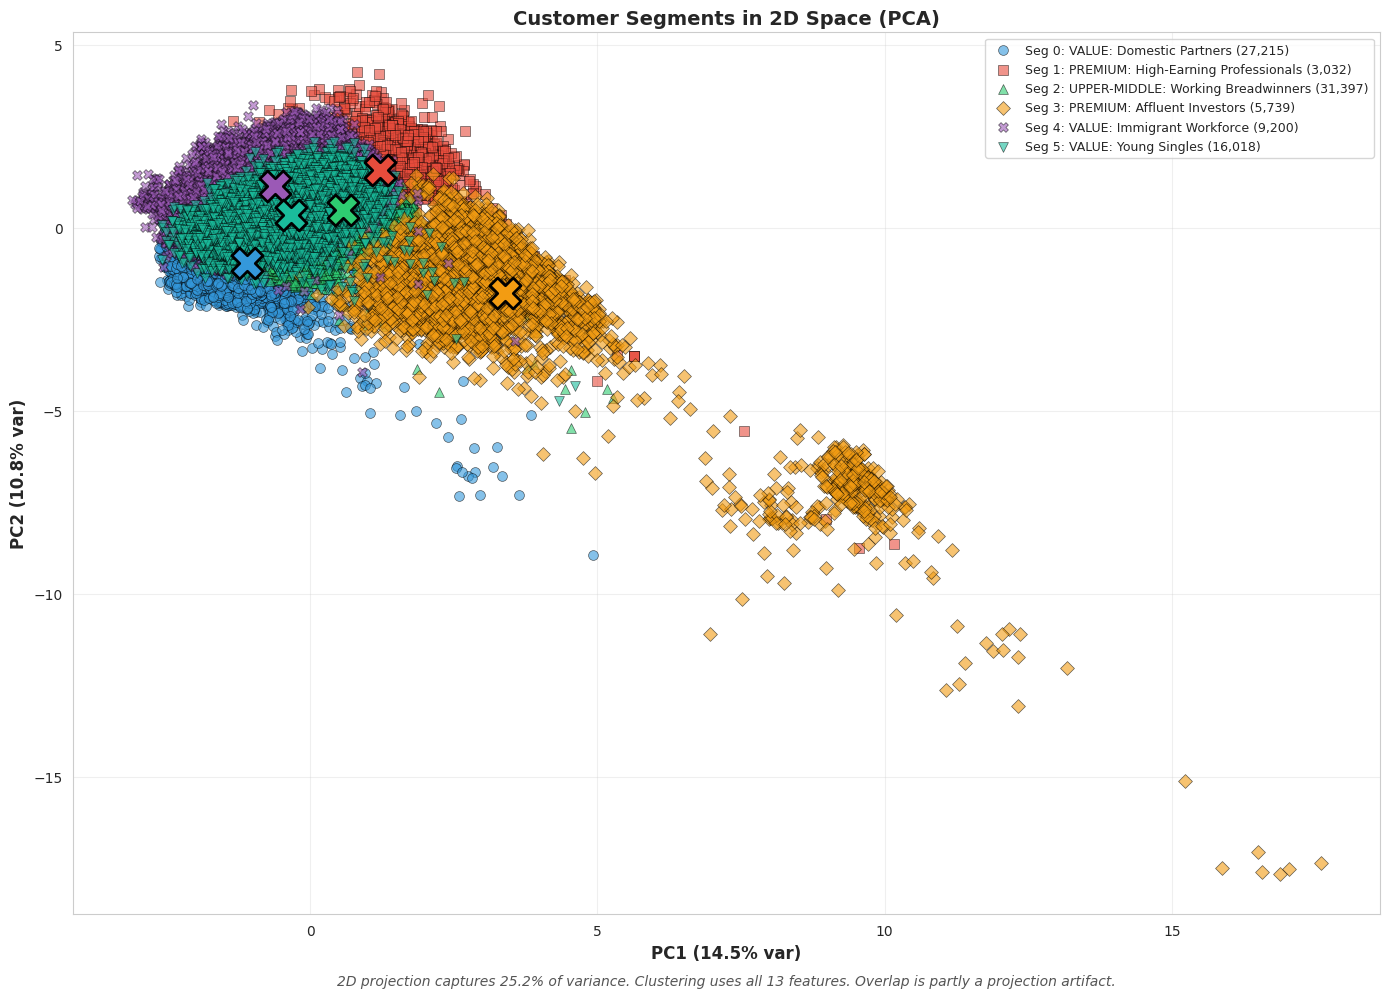

  ✓ Saved: 12a_segments_2d_pca.png

14.3 Creating comprehensive dashboard...


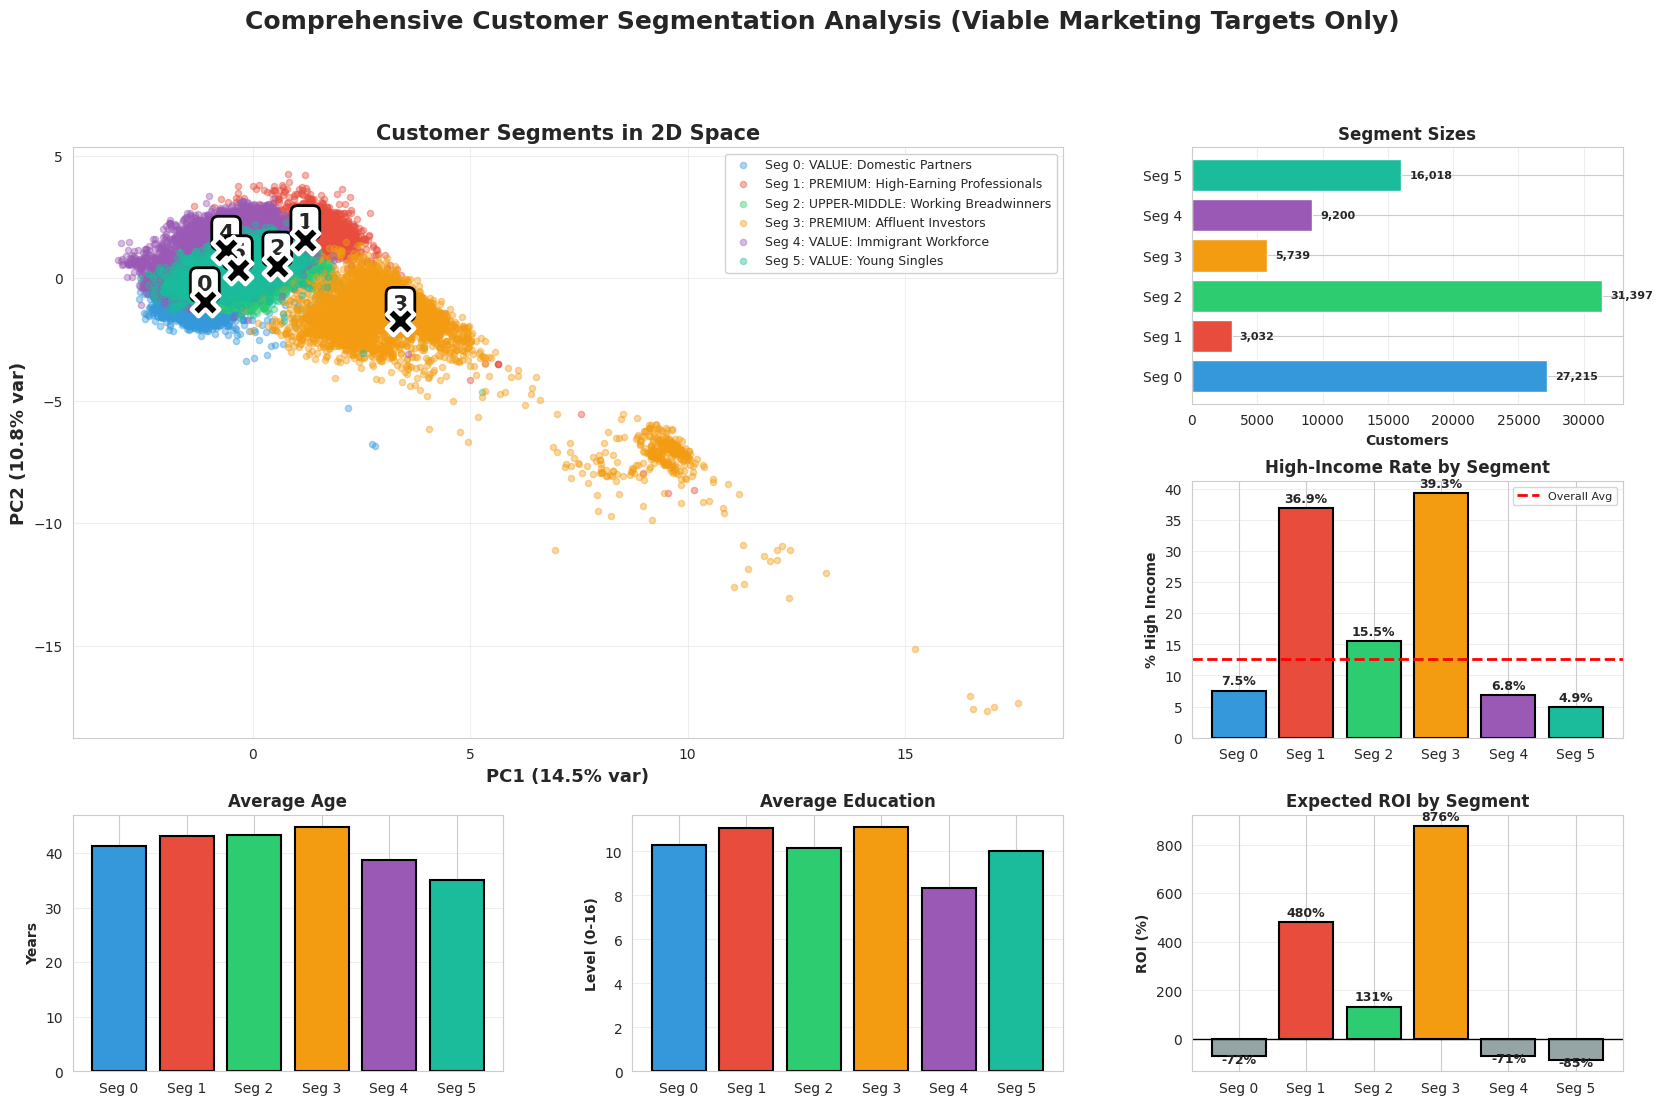

  ✓ Saved: 08_segmentation_comprehensive.png

14.4 Creating radar charts...


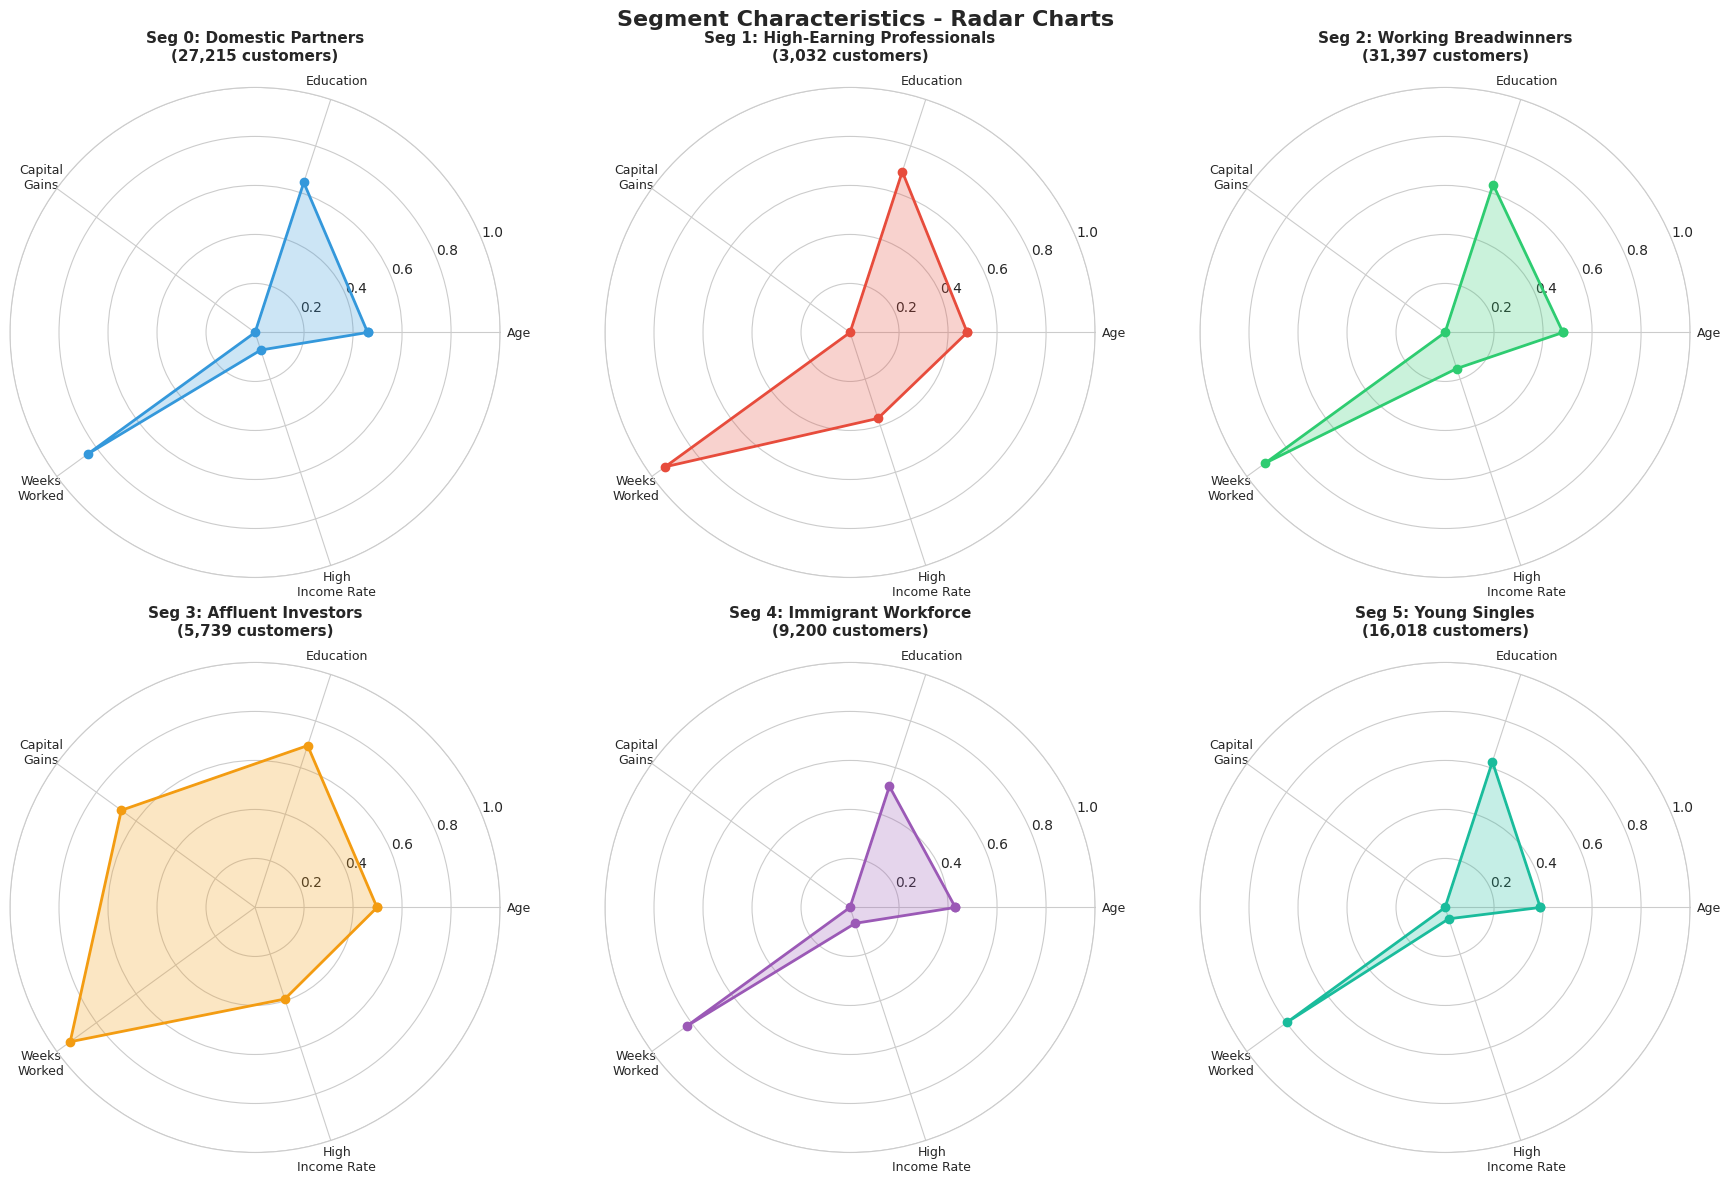

  ✓ Saved: 12c_segment_radar_charts.png

14.5 Creating ROI comparison chart...


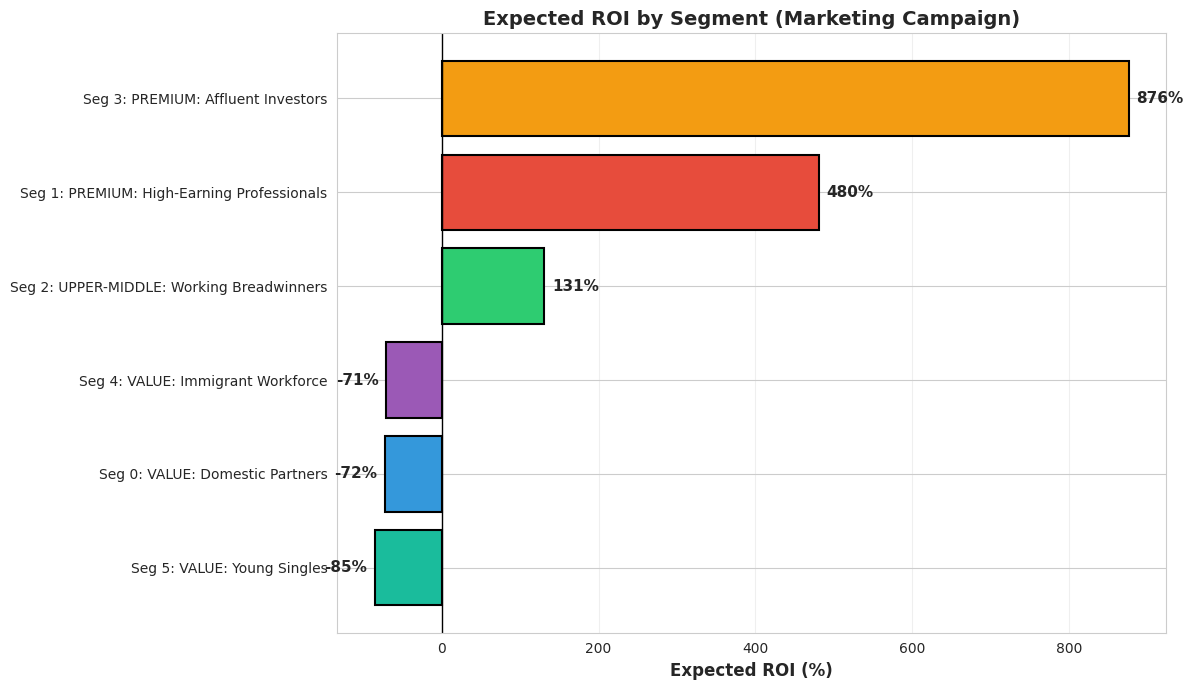

  ✓ Saved: 12d_segment_roi.png

 All segmentation visualizations complete — 4 unique charts generated


In [44]:
# ============================================================================
# STEP 14: SEGMENTATION VISUALIZATIONS
# ============================================================================
print("\n" + "=" * 80)
print("STEP 14: SEGMENTATION VISUALIZATIONS")
print("=" * 80)


# ── Setup ─────────────────────────────────────────────────────────────────
segment_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
segment_markers = ['o', 's', '^', 'D', 'X', 'v']
colors = segment_colors[:optimal_k]


# ── 14.1 PCA for 2D Visualization ────────────────────────────────────────
print(f"\n14.1 Performing PCA for 2D Visualization...")
pca = PCA(n_components=2, random_state=42)
X_segment_pca = pca.fit_transform(X_segment_scaled)
df_segmentation['pca1'] = X_segment_pca[:, 0]
df_segmentation['pca2'] = X_segment_pca[:, 1]


print(f"  Explained Variance:")
print(f"    PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"    PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"    Total: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"    Note: 2D view captures only {pca.explained_variance_ratio_.sum()*100:.1f}% of variance")
print(f"    Clustering was performed on all {X_segment_scaled.shape[1]} features")


# Compute centroids in PCA space
centroid_pca = pca.transform(kmeans_final.cluster_centers_)
segment_comparison_df = comparison_df


# ── 14.2 Detailed PCA Scatter Plot ───────────────────────────────────────
print(f"\n14.2 Creating detailed PCA scatter plot...")


fig, ax = plt.subplots(figsize=(14, 10))


for seg_id in range(optimal_k):
    mask = df_segmentation['segment'] == seg_id
    seg_size = mask.sum()

    seg_name = segment_comparison_df[segment_comparison_df['segment_id'] == seg_id]['classification'].values[0]

    ax.scatter(X_segment_pca[mask, 0], X_segment_pca[mask, 1],
               c=segment_colors[seg_id], marker=segment_markers[seg_id],
               s=50, alpha=0.6, edgecolors='black', linewidths=0.5,
               label=f'Seg {seg_id}: {seg_name} ({seg_size:,})')

    ax.scatter(centroid_pca[seg_id, 0], centroid_pca[seg_id, 1],
               c=segment_colors[seg_id], marker='X', s=500,
               edgecolors='black', linewidths=2, zorder=5)


ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)', fontsize=12, fontweight='bold')
ax.set_title('Customer Segments in 2D Space (PCA)', fontsize=14, fontweight='bold')

total_var_2d = pca.explained_variance_ratio_.sum() * 100
ax.text(0.5, -0.08,
        f'2D projection captures {total_var_2d:.1f}% of variance. '
        f'Clustering uses all {X_segment_scaled.shape[1]} features. '
        f'Overlap is partly a projection artifact.',
        transform=ax.transAxes, ha='center', fontsize=10, style='italic', color='#555555')

ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/12a_segments_2d_pca.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ Saved: 12a_segments_2d_pca.png")


# ── 14.3 Comprehensive 6-Panel Dashboard ─────────────────────────────────
print(f"\n14.3 Creating comprehensive dashboard...")


fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)


# Panel 1: PCA Scatter (top-left, spans 2 rows × 2 cols)
ax1 = fig.add_subplot(gs[0:2, 0:2])
for seg_id in range(optimal_k):
    mask = df_segmentation['segment'] == seg_id
    seg_label = segment_comparison_df[segment_comparison_df['segment_id'] == seg_id]['classification'].values[0]
    sample_size_plot = min(5000, mask.sum())
    sample_indices = df_segmentation[mask].sample(n=sample_size_plot, random_state=42).index
    ax1.scatter(df_segmentation.loc[sample_indices, 'pca1'],
                df_segmentation.loc[sample_indices, 'pca2'],
                c=colors[seg_id], label=f'Seg {seg_id}: {seg_label}', alpha=0.4, s=20)


for seg_id in range(optimal_k):
    ax1.scatter(centroid_pca[seg_id, 0], centroid_pca[seg_id, 1],
                c='black', s=400, marker='X', edgecolors='white', linewidths=3, zorder=10)
    ax1.text(centroid_pca[seg_id, 0], centroid_pca[seg_id, 1] + 0.3, f'{seg_id}',
             ha='center', va='bottom', fontweight='bold', fontsize=16,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=2))


ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)', fontsize=13, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)', fontsize=13, fontweight='bold')
ax1.set_title('Customer Segments in 2D Space', fontsize=15, fontweight='bold')
ax1.legend(loc='best', fontsize=9, framealpha=0.9)
ax1.grid(alpha=0.3)


# Panel 2: Segment sizes (top-right)
ax2 = fig.add_subplot(gs[0, 2])
sizes = segment_comparison_df.sort_values('segment_id')['size'].values
bars = ax2.barh(range(optimal_k), sizes, color=colors)
ax2.set_yticks(range(optimal_k))
ax2.set_yticklabels([f'Seg {i}' for i in range(optimal_k)])
ax2.set_xlabel('Customers', fontsize=10, fontweight='bold')
ax2.set_title('Segment Sizes', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, sizes)):
    ax2.text(val + max(sizes) * 0.02, i, f'{val:,.0f}', va='center', fontsize=8, fontweight='bold')


# Panel 3: High-income rates (middle-right)
ax3 = fig.add_subplot(gs[1, 2])
income_rates = segment_comparison_df.sort_values('segment_id')['high_income_pct'].values
bars = ax3.bar(range(optimal_k), income_rates, color=colors, edgecolor='black', linewidth=1.5)
ax3.axhline(y=overall_avg, color='red', linestyle='--', linewidth=2, label='Overall Avg')
ax3.set_xticks(range(optimal_k))
ax3.set_xticklabels([f'Seg {i}' for i in range(optimal_k)])
ax3.set_ylabel('% High Income', fontsize=10, fontweight='bold')
ax3.set_title('High-Income Rate by Segment', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(axis='y', alpha=0.3)
for i, val in enumerate(income_rates):
    ax3.text(i, val + 1, f'{val:.1f}%', ha='center', fontsize=9, fontweight='bold')


# Panel 4: Average age (bottom-left)
ax4 = fig.add_subplot(gs[2, 0])
ages = segment_comparison_df.sort_values('segment_id')['avg_age'].values
ax4.bar(range(optimal_k), ages, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(optimal_k))
ax4.set_xticklabels([f'Seg {i}' for i in range(optimal_k)])
ax4.set_ylabel('Years', fontsize=10, fontweight='bold')
ax4.set_title('Average Age', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)


# Panel 5: Education level (bottom-center)
ax5 = fig.add_subplot(gs[2, 1])
edu = segment_comparison_df.sort_values('segment_id')['education_level'].values
ax5.bar(range(optimal_k), edu, color=colors, edgecolor='black', linewidth=1.5)
ax5.set_xticks(range(optimal_k))
ax5.set_xticklabels([f'Seg {i}' for i in range(optimal_k)])
ax5.set_ylabel('Level (0-16)', fontsize=10, fontweight='bold')
ax5.set_title('Average Education', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)


# Panel 6: ROI comparison (bottom-right)
ax6 = fig.add_subplot(gs[2, 2])
rois = segment_comparison_df.sort_values('segment_id')['roi'].values
bar_colors = [colors[i] if rois[i] > 0 else '#95a5a6' for i in range(optimal_k)]
bars = ax6.bar(range(optimal_k), rois, color=bar_colors, edgecolor='black', linewidth=1.5)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.set_xticks(range(optimal_k))
ax6.set_xticklabels([f'Seg {i}' for i in range(optimal_k)])
ax6.set_ylabel('ROI (%)', fontsize=10, fontweight='bold')
ax6.set_title('Expected ROI by Segment', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
for i, val in enumerate(rois):
    offset = max(abs(rois).max() * 0.03, 5)
    y_pos = val + offset if val >= 0 else val - offset
    ax6.text(i, y_pos, f'{val:.0f}%', ha='center', fontsize=9, fontweight='bold')


plt.suptitle('Comprehensive Customer Segmentation Analysis (Viable Marketing Targets Only)',
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig(f"{output_dir}/08_segmentation_comprehensive.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ Saved: 08_segmentation_comprehensive.png")


# ── 14.4 Radar Charts per Segment ────────────────────────────────────────
print(f"\n14.4 Creating radar charts...")


fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()


characteristics = ['Age', 'Education', 'Capital\nGains', 'Weeks\nWorked', 'High\nIncome Rate']


for seg_id in range(optimal_k):
    seg_data = df_segmentation[df_segmentation['segment'] == seg_id]

    values = [
        seg_data['age'].mean() / 90,
        seg_data['education_level'].mean() / 16,
        min(seg_data['capital gains'].mean() / 20000, 1),
        seg_data['weeks worked in year'].mean() / 52,
        seg_data['target'].mean()
    ]

    num_vars = len(characteristics)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    values += values[:1]
    angles += angles[:1]

    ax = axes[seg_id]
    ax.plot(angles, values, 'o-', linewidth=2, color=segment_colors[seg_id], label=f'Segment {seg_id}')
    ax.fill(angles, values, alpha=0.25, color=segment_colors[seg_id])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(characteristics, fontsize=9)
    ax.set_ylim(0, 1)

    seg_name = segment_comparison_df[segment_comparison_df['segment_id'] == seg_id]['demo_trait'].values[0]
    ax.set_title(f'Seg {seg_id}: {seg_name}\n({len(seg_data):,} customers)',
                 fontsize=11, fontweight='bold', pad=20)
    ax.grid(True)


for idx in range(optimal_k, len(axes)):
    fig.delaxes(axes[idx])


plt.suptitle('Segment Characteristics - Radar Charts', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(f"{output_dir}/12c_segment_radar_charts.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ Saved: 12c_segment_radar_charts.png")


# ── 14.5 ROI by Segment (Horizontal Bar) ─────────────────────────────────
print(f"\n14.5 Creating ROI comparison chart...")


fig, ax = plt.subplots(figsize=(12, 7))


roi_data = segment_comparison_df.sort_values('roi', ascending=True)


colors_roi = [segment_colors[int(row['segment_id'])] for _, row in roi_data.iterrows()]
bars = ax.barh(range(len(roi_data)), roi_data['roi'].values,
               color=colors_roi, edgecolor='black', linewidth=1.5)


ax.set_yticks(range(len(roi_data)))
ax.set_yticklabels([f"Seg {int(row['segment_id'])}: {row['classification']}"
                     for _, row in roi_data.iterrows()], fontsize=10)
ax.set_xlabel('Expected ROI (%)', fontsize=12, fontweight='bold')
ax.set_title('Expected ROI by Segment (Marketing Campaign)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='x', alpha=0.3)


for i, (idx, row) in enumerate(roi_data.iterrows()):
    roi_val = row['roi']
    ax.text(roi_val + (10 if roi_val > 0 else -10), i, f"{roi_val:.0f}%",
            va='center', ha='left' if roi_val > 0 else 'right',
            fontsize=11, fontweight='bold')


plt.tight_layout()
plt.savefig(f"{output_dir}/12d_segment_roi.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("  ✓ Saved: 12d_segment_roi.png")


print(f"\n All segmentation visualizations complete — 4 unique charts generated")
print("=" * 80)